In [1]:
import os
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, LSTM
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, History
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import random
import logging
from functools import reduce
from operator import add
import matplotlib.pyplot as plt

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
#config.allow_soft_placement = True
#config.log_device_placement = True
set_session(tf.Session(config = config))

%matplotlib inline

C:\Users\vales\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [16]:
### Prepare Data, Compile Model, Train and Score Model
def replace_obj(x):
    try:
        return float(x.replace(',',''))
    except:
        return x

def process_data(train_csv, cv_csv):
    train_raw = pd.read_csv(train_csv, sep = ';', low_memory = False)
    cv_raw = pd.read_csv(cv_csv, sep = ';', low_memory = False)
    
    seed = 19

    train_raw.fillna(-999, inplace = True)
    cv_raw.fillna(-999, inplace = True)

    train_raw['buyin'] = train_raw['buyin'].apply(lambda x: replace_obj(x))

    train_cols = ['buyin', 'year', 'tournament_id', 'player_id', 'salary', 'elapsed_days', 'dk_type_dummy', 'wins_last_30_events',
                 'result_0', 'result_1', 'result_2', 'result_3', 'result_4', 'result_5', 'result_6', 'result_7', 'result_8', 
                 'result_9', 'own_0', 'own_1', 'own_2', 'own_3', 'own_4', 'own_5', 'own_6', 'own_7', 'own_8', 'own_9', 'owgr_curr',
                 'owgr_avg_3', 'owgr_avg_10', 'owgr_avg_25', 'owgr_avg_50', 'num_tourny_appear', 'tourny_wins', 'tourny_cut_percent',
                 'tourny_top_20_percent', 'appear_0', 'appear_1', 'appear_2', 'appear_3', 'appear_4', 'appear_5', 'appear_6', 
                 'appear_7', 'appear_8', 'appear_9']

    X = train_raw[train_cols].as_matrix()
    Y = train_raw['ownership'].as_matrix()

    X = shuffle(X, random_state = seed)
    Y = shuffle(Y, random_state = seed)

    cv_X = cv_raw[train_cols].as_matrix()
    cv_Y = cv_raw['ownership'].as_matrix()

    standard_scaler = StandardScaler()
    standard_scaler.fit(X)

    X_scaled = standard_scaler.transform(X)
    cv_X_scaled = standard_scaler.transform(cv_X)
    
    input_shape = (len(train_cols),)
    
    return X_scaled, Y, cv_X_scaled, cv_Y, input_shape



def compile_model(network, input_shape):
    # Create and compile Model

    # Args: network (dict) of params

    nb_layers = network['nb_layers']
    nb_neurons = network['nb_neurons']
    activation = network['activation']
    optimizer = network['optimizer']
    dropout_percent = network['dropout_percent']

    model = Sequential()

    for l in range(nb_layers):
        if l == 0:
            model.add(Dense(nb_neurons, activation = activation, kernel_initializer = 'normal', input_shape = input_shape))
            model.add(Dropout(dropout_percent))
        else:
            model.add(Dense(nb_neurons, activation = activation, kernel_initializer = 'normal'))

    model.add(Dense(1, kernel_initializer = 'normal'))

    model.compile(loss = 'mean_squared_error', optimizer = optimizer)

    return model


def train_and_score_single(network, train_csv, cv_csv):
    #early_stopper = EarlyStopping(patience = 20)
    history = History()
    
    X_scaled, Y, cv_X_scaled, cv_Y, input_shape = process_data(train_csv, cv_csv)
    
    #model = KerasRegressor(build_fn = compile_model, epochs = 2500, batch_size = 2400, verbose = 1, 
    #                       validation_split = network['validation_split'], callbacks = [history],
    #                      network = network, input_shape = input_shape)
    
    model = compile_model(network, input_shape)
    
    model.fit(X_scaled, Y, epochs = 5500, batch_size = 3200, verbose = 1, validation_split = network['validation_split'], 
              callbacks = [history])
    
    score = model.evaluate(cv_X_scaled, cv_Y, verbose = 0)
    
    return model, history

def train_and_score(network, train_csv, cv_csv):
    #early_stopper = EarlyStopping(patience = 20)
    history = History()
    
    X_scaled, Y, cv_X_scaled, cv_Y, input_shape = process_data(train_csv, cv_csv)
    
    #model = KerasRegressor(build_fn = compile_model, epochs = 750, batch_size = 2400, verbose = 0, 
    #                       validation_split = network['validation_split'], #callbacks = [early_stopper],
    #                      network = network, input_shape = input_shape, callbacks = [history])
    
    model = compile_model(network, input_shape)
    
    model.fit(X_scaled, Y, epochs = 1000, batch_size = 3200, verbose = 0, validation_split = network['validation_split'], 
              callbacks = [history])
    
    score = sum(history.history['val_loss'][-20:]) / 20
    
    print('Validation Loss {} for newtork parameters {}'.format(score, network))
    
    return score

In [10]:
## Create networks and iterate through generations

class Network():
    ## Represent a network and let us operate on it.
    
    def __init__(self, nn_param_choices = None):
        
        ## Initialize the network
        
        ## Args:
        ##     nn_param_choices (dict): Parameters for the network, includes:
        ##     nb_neurons, nb_layers, nb_activation, optimizer, validation_split
        
        self.accuracy = 0
        self.nn_param_choices = nn_param_choices
        self.network = {}
        
    def create_random(self):
        for key in self.nn_param_choices:
            self.network[key] = random.choice(self.nn_param_choices[key])
            
    def create_set(self, network):
        ## Set network properties
        
        self.network = network
        
        print(self.network)
    
    def train(self, train_csv, cv_csv):
        if self.accuracy == 0:
            self.accuracy = train_and_score(self.network, train_csv, cv_csv)
            
    def print_network(self):
        # print network
        logging.info(self.network)
        logging.info("CV loss: {}".format(self.accuracy))
        
        
class Optimizer():
    ## implement genetic algorithm
    
    def __init__(self, nn_param_choices, retain = 0.4, random_select = 0.1, mutate_chance = 0.2):
        
        #Create optimizer
        
        self.mutate_chance = mutate_chance
        self.random_select = random_select
        self.retain = retain
        self.nn_param_choices = nn_param_choices
        
    def create_population(self, count):
        #Creates population of random networks
        
        population = []
        
        for _ in range(0, count):
            network = Network(self.nn_param_choices)
            network.create_random()
            
            population.append(network)
            
        return population
    
    @staticmethod
    def fitness(network):
        return network.accuracy
    
    def grade(self, population):
        ##Args population of networks
        ##Returns the avg accuracy of the population
        
        summed = reduce(add, (self.fitness(network) for network in population))
        
        return summed / float((len(pop)))
        
    def breed(self, mother, father):
        ## Makes two children network from mother and father
        ## Returns list of 2 network objects
        
        children = []
        
        for _ in range(2):
            
            child = {}
            
            for param in self.nn_param_choices:
                child[param] = random.choice([mother.network[param], father.network[param]])
                
            network = Network(self.nn_param_choices)
            network.create_set(child)
            
            children.append(network)
            
        return children
    
    def mutate(self, network):
        #Randomly mutate one part of the network
        
        mutation = random.choice(list(self.nn_param_choices.keys()))
        
        #Mutate one param
        network.network[mutation] = random.choice(self.nn_param_choices[mutation])
        
        return network
    
    def evolve(self, population):
        ## evolve a population of networks
        ## Args population: a list of network parameters
        ## Returns an evolved population of networks
        
        ## get scores for each network
        graded = [(self.fitness(network), network) for network in population]
        
        graded = [x[1] for x in sorted(graded, key = lambda x: x[0])]
        
        # get num of networks we want to retain for next generation
        retain_length = int(len(graded) * self.retain)
        
        # get parents, ie every network we want to keep
        parents = graded[:retain_length]
        
        # for the throwaways, keep some at random
        for individual in graded[retain_length:]:
            if self.random_select > random.random():
                parents.append(individual)
                
        # randomly mutate some of the saved networks
        for individual in parents:
            if self.mutate_chance > random.random():
                individual = self.mutate(individual)
                
        # find out how many new networks are needed
        parents_length = len(parents)
        desired_length = len(population) - parents_length
        children = []
        
        while len(children) < desired_length:
            
            # Get a random mother and father
            male = random.randint(0, parents_length - 1)
            female = random.randint(0, parents_length - 1)
            
            # make sure they aren't the same network
            
            if male != female:
                male = parents[male]
                female = parents[female]
                
                #breed them
                babies = self.breed(male,female)
                
                for baby in babies:
                    if len(children) < desired_length:
                        children.append(baby)
                        
        parents.extend(children)
        
        return parents            
            

In [11]:
### run the simulation

## Setup logging

logging.basicConfig(
        format='%(asctime)s - %(levelname)s - %(message)s',
        datefmt='%m/%d/%Y %I:%M:%S %p',
        level=logging.DEBUG,
        filename='log1.txt')

def train_networks(networks, train_csv, cv_csv):
    pbar = tqdm(total = len(networks))
    
    for network in networks:
        network.train(train_csv, cv_csv)
        pbar.update(1)
        
    pbar.close()
    
def get_average_accuracy(networks):
    
    total_accuracy = 0
    
    for network in networks:
        total_accuracy += network.accuracy
        
    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices, train_csv, cv_csv):
    optimizer = Optimizer(nn_param_choices)
    networks = optimizer.create_population(population)
    
    ## Evolve Generation
    
    for i in range(generations):
        
        logging.info('*** Doing Generation {} of {} ***'.format(i + 1, generations))
        
        ## Train and get accuracy for networks
        train_networks(networks, train_csv, cv_csv)
        
        ## Get the average accuracy each generation
        average_accuracy = get_average_accuracy(networks)
        
        # Print out the average accuracy each generation
        logging.info('Generation average: {}'.format(average_accuracy * 100))
        logging.info('-' * 80)
        
        # Evolve, except the last iteration
        if i != generations - 1:
            networks = optimizer.evolve(networks)
            
    #sort final population
    networks = sorted(networks, key = lambda x: x.accuracy)
    
    print_networks(networks[:5])
    
def print_networks(networks):
    # print list of networks

    logging.info('-'*80)
    for network in networks:
        network.print_network()

def main():
    #Evolve Network
    generations = 7
    population = 20

    train_csv = 'D:/data/combo_df.csv'
    cv_csv = 'D:/data/shell_df.csv'

    nn_param_choices = {
        'nb_neurons': [128, 256, 512, 768, 1024],
        'nb_layers': [1,2,3,4,5],
        'activation': ['relu', 'elu', 'tanh'],
        'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad'],
        'validation_split': [0.15, 0.25, 0.35], 
        'dropout_percent': [0.10, 0.20, 0.40, 0.80]
    }

    logging.info('*** Evolving {} generations with population {}'.format(generations, population))

    generate(generations, population, nn_param_choices, train_csv, cv_csv)

        

In [12]:
main()

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Validation Loss 0.0043094551786146944 for newtork parameters {'nb_layers': 3, 'validation_split': 0.25, 'activation': 'elu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 128}


  5%|████▏                                                                              | 1/20 [01:39<31:39, 99.99s/it]

Validation Loss 0.0014175351777402743 for newtork parameters {'nb_layers': 2, 'validation_split': 0.35, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.2, 'nb_neurons': 768}


 10%|████████▏                                                                         | 2/20 [05:27<41:28, 138.26s/it]

Validation Loss 0.0037812572883937426 for newtork parameters {'nb_layers': 2, 'validation_split': 0.25, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_percent': 0.8, 'nb_neurons': 128}


 15%|████████████▎                                                                     | 3/20 [06:59<35:12, 124.27s/it]

Validation Loss 0.004629057596898913 for newtork parameters {'nb_layers': 2, 'validation_split': 0.15, 'activation': 'tanh', 'optimizer': 'adagrad', 'dropout_percent': 0.1, 'nb_neurons': 256}


 20%|████████████████▍                                                                 | 4/20 [08:56<32:35, 122.23s/it]

Validation Loss 0.005531381446501115 for newtork parameters {'nb_layers': 1, 'validation_split': 0.35, 'activation': 'elu', 'optimizer': 'adagrad', 'dropout_percent': 0.4, 'nb_neurons': 1024}


 25%|████████████████████▌                                                             | 5/20 [11:22<32:18, 129.23s/it]

Validation Loss 0.003537319478627446 for newtork parameters {'nb_layers': 3, 'validation_split': 0.35, 'activation': 'elu', 'optimizer': 'adam', 'dropout_percent': 0.8, 'nb_neurons': 1024}


 30%|████████████████████████▌                                                         | 6/20 [19:18<54:28, 233.44s/it]

Validation Loss 0.03875923116937867 for newtork parameters {'nb_layers': 5, 'validation_split': 0.35, 'activation': 'elu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 768}


 35%|████████████████████████████                                                    | 7/20 [28:02<1:09:28, 320.66s/it]

Validation Loss 0.0014029257202455513 for newtork parameters {'nb_layers': 3, 'validation_split': 0.35, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.1, 'nb_neurons': 768}


 40%|████████████████████████████████                                                | 8/20 [33:30<1:04:33, 322.76s/it]

Validation Loss 0.0049809656058963465 for newtork parameters {'nb_layers': 3, 'validation_split': 0.25, 'activation': 'elu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 256}


 45%|████████████████████████████████████▉                                             | 9/20 [35:45<48:51, 266.50s/it]

Validation Loss 0.004422353975597459 for newtork parameters {'nb_layers': 1, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.1, 'nb_neurons': 768}


 50%|████████████████████████████████████████▌                                        | 10/20 [38:09<38:16, 229.70s/it]

Validation Loss 0.004605851295072741 for newtork parameters {'nb_layers': 2, 'validation_split': 0.35, 'activation': 'tanh', 'optimizer': 'adagrad', 'dropout_percent': 0.4, 'nb_neurons': 128}


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:34<27:55, 186.20s/it]

Validation Loss 0.0020768538714175167 for newtork parameters {'nb_layers': 1, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 60%|████████████████████████████████████████████████▌                                | 12/20 [41:42<22:29, 168.65s/it]

Validation Loss 0.00224804465711005 for newtork parameters {'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adagrad', 'dropout_percent': 0.2, 'nb_neurons': 512}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [44:43<20:07, 172.47s/it]

Validation Loss 0.0013187811761621766 for newtork parameters {'nb_layers': 5, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.1, 'nb_neurons': 512}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [50:13<21:58, 219.80s/it]

Validation Loss 0.0035535188972779033 for newtork parameters {'nb_layers': 4, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [58:22<25:02, 300.44s/it]

Validation Loss 0.0029613221069600647 for newtork parameters {'nb_layers': 2, 'validation_split': 0.15, 'activation': 'elu', 'optimizer': 'rmsprop', 'dropout_percent': 0.1, 'nb_neurons': 256}


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:00:24<16:27, 246.97s/it]

Validation Loss 0.01430734049740583 for newtork parameters {'nb_layers': 3, 'validation_split': 0.25, 'activation': 'elu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 1024}


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:08:58<16:21, 327.08s/it]

Validation Loss 0.01767818713522815 for newtork parameters {'nb_layers': 3, 'validation_split': 0.35, 'activation': 'elu', 'optimizer': 'rmsprop', 'dropout_percent': 0.1, 'nb_neurons': 768}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:14:27<10:55, 327.68s/it]

Validation Loss 0.005338334693120326 for newtork parameters {'nb_layers': 5, 'validation_split': 0.25, 'activation': 'elu', 'optimizer': 'sgd', 'dropout_percent': 0.2, 'nb_neurons': 512}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:19:43<05:24, 324.03s/it]

Validation Loss 0.004312884595244119 for newtork parameters {'nb_layers': 5, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_percent': 0.1, 'nb_neurons': 1024}


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:33:08<00:00, 468.51s/it]


{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 1024}
{'nb_layers': 4, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.2, 'nb_neurons': 768}
{'nb_layers': 4, 'validation_split': 0.35, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.2, 'nb_neurons': 768}
{'nb_layers': 2, 'validation_split': 0.25, 'activation': 'elu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 1024}
{'nb_layers': 3, 'validation_split': 0.25, 'activation': 'elu', 'optimizer': 'rmsprop', 'dropout_percent': 0.1, 'nb_neurons': 256}
{'nb_layers': 1, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 256}
{'nb_layers': 2, 'validation_split': 0.15, 'activation': 'elu', 'optimizer': 'adam', 

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Validation Loss 0.0010999638223366845 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 50%|█████████████████████████████████████████                                         | 10/20 [04:04<04:04, 24.43s/it]

Validation Loss 0.0011783316310132526 for newtork parameters {'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 1024}


 55%|████████████████████████████████████████████▌                                    | 11/20 [10:15<19:15, 128.39s/it]

Validation Loss 0.0013021903491008738 for newtork parameters {'nb_layers': 4, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.2, 'nb_neurons': 768}


 60%|████████████████████████████████████████████████▌                                | 12/20 [18:04<30:44, 230.51s/it]

Validation Loss 0.001408577075463545 for newtork parameters {'nb_layers': 4, 'validation_split': 0.35, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.2, 'nb_neurons': 768}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [25:09<33:43, 289.02s/it]

Validation Loss 0.008004523042230455 for newtork parameters {'nb_layers': 2, 'validation_split': 0.25, 'activation': 'elu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 1024}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [30:45<30:17, 302.95s/it]

Validation Loss 0.004966549337307132 for newtork parameters {'nb_layers': 3, 'validation_split': 0.25, 'activation': 'elu', 'optimizer': 'rmsprop', 'dropout_percent': 0.1, 'nb_neurons': 256}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [32:55<20:56, 251.28s/it]

Validation Loss 0.002288861523750137 for newtork parameters {'nb_layers': 1, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 256}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [34:37<13:45, 206.36s/it]

Validation Loss 0.002099347946789333 for newtork parameters {'nb_layers': 2, 'validation_split': 0.15, 'activation': 'elu', 'optimizer': 'adam', 'dropout_percent': 0.1, 'nb_neurons': 512}


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [37:43<10:00, 200.24s/it]

Validation Loss 0.0034728123203129303 for newtork parameters {'nb_layers': 1, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adagrad', 'dropout_percent': 0.2, 'nb_neurons': 512}


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [39:45<05:53, 176.94s/it]

Validation Loss 0.006770271052353387 for newtork parameters {'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adagrad', 'dropout_percent': 0.4, 'nb_neurons': 512}


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [42:45<02:57, 177.68s/it]

Validation Loss 0.0015227320779283176 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adagrad', 'dropout_percent': 0.1, 'nb_neurons': 512}


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [48:34<00:00, 229.25s/it]


{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.2, 'nb_neurons': 768}
{'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}
{'nb_layers': 3, 'validation_split': 0.35, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.1, 'nb_neurons': 512}
{'nb_layers': 1, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.1, 'nb_neurons': 1024}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adagrad', 'dropout_percent': 0.1, 'nb_neurons': 512}
{'nb_layers': 5, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'rmsprop'

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Validation Loss 0.001096435855272067 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 50%|█████████████████████████████████████████                                         | 10/20 [04:13<04:13, 25.32s/it]

Validation Loss 0.0011417198329499337 for newtork parameters {'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.2, 'nb_neurons': 768}


 55%|████████████████████████████████████████████▌                                    | 11/20 [08:55<15:22, 102.49s/it]

Validation Loss 0.0011279551808822826 for newtork parameters {'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}


 60%|████████████████████████████████████████████████▌                                | 12/20 [12:11<17:24, 130.62s/it]

Validation Loss 0.0014242199953950797 for newtork parameters {'nb_layers': 3, 'validation_split': 0.35, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [17:58<22:47, 195.34s/it]

Validation Loss 0.001124369957644776 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.1, 'nb_neurons': 512}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [24:04<24:39, 246.54s/it]

Validation Loss 0.0039542349441423295 for newtork parameters {'nb_layers': 1, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.1, 'nb_neurons': 1024}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [27:00<18:47, 225.47s/it]

Validation Loss 0.0015424558317446325 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adagrad', 'dropout_percent': 0.1, 'nb_neurons': 512}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [33:01<17:44, 266.21s/it]

Validation Loss 0.0013213890541708827 for newtork parameters {'nb_layers': 5, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.1, 'nb_neurons': 512}


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [38:43<14:26, 288.97s/it]

Validation Loss 0.0010690670240882819 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [47:40<12:06, 363.17s/it]

Validation Loss 0.00243781677078021 for newtork parameters {'nb_layers': 1, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 768}


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [50:25<05:03, 303.68s/it]

Validation Loss 0.0019470868572748136 for newtork parameters {'nb_layers': 1, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.1, 'nb_neurons': 1024}


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [53:35<00:00, 269.62s/it]


{'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adagrad', 'dropout_percent': 0.1, 'nb_neurons': 512}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 1024}
{'nb_layers': 1, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.1, 'nb_neurons': 512}
{'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 1024}
{'nb_layers': 1, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 1024}
{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'd

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Validation Loss 0.003081109181181893 for newtork parameters {'nb_layers': 2, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adagrad', 'dropout_percent': 0.1, 'nb_neurons': 512}


 50%|█████████████████████████████████████████                                         | 10/20 [03:14<03:14, 19.41s/it]

Validation Loss 0.0010096708775132637 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}


 55%|████████████████████████████████████████████▌                                    | 11/20 [09:31<19:02, 126.90s/it]

Validation Loss 0.0012166902142120605 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 1024}


 60%|████████████████████████████████████████████████▌                                | 12/20 [25:11<49:25, 370.67s/it]

Validation Loss 0.0019974078739427394 for newtork parameters {'nb_layers': 1, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.1, 'nb_neurons': 512}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [27:31<35:10, 301.54s/it]

Validation Loss 0.001125306905715158 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 1024}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [40:27<44:22, 443.78s/it]

Validation Loss 0.004085919930336785 for newtork parameters {'nb_layers': 1, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 1024}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [43:26<30:21, 364.34s/it]

Validation Loss 0.001062228758270516 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [47:46<22:12, 333.01s/it]

Validation Loss 0.001085996783799152 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [52:08<15:35, 311.93s/it]

Validation Loss 0.0032778807126912493 for newtork parameters {'nb_layers': 4, 'validation_split': 0.25, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:00:30<12:17, 368.80s/it]

Validation Loss 0.001158061708905933 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 512}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:04:45<05:34, 334.84s/it]

Validation Loss 0.001101811893461501 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:10:09<00:00, 331.32s/it]


{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}
{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}
{'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 768}
{'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_per

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Validation Loss 0.0011007560072113407 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 45%|█████████████████████████████████████▎                                             | 9/20 [04:23<05:21, 29.26s/it]

Validation Loss 0.005209718417995357 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_percent': 0.4, 'nb_neurons': 512}


 50%|█████████████████████████████████████████                                         | 10/20 [08:30<15:46, 94.70s/it]

Validation Loss 0.001071296929820528 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 55%|████████████████████████████████████████████▌                                    | 11/20 [14:53<27:08, 181.00s/it]

Validation Loss 0.0010207239286268708 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}


 60%|████████████████████████████████████████████████▌                                | 12/20 [19:16<27:25, 205.67s/it]

Validation Loss 0.0011134322743132977 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [26:15<31:27, 269.62s/it]

Validation Loss 0.001143884585288156 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 768}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [35:19<35:11, 351.97s/it]

Validation Loss 0.001081667028882016 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [40:45<28:41, 344.22s/it]

Validation Loss 0.0010821124682399502 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [46:11<22:35, 338.84s/it]

Validation Loss 0.0010934775566418824 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [50:38<15:51, 317.21s/it]

Validation Loss 0.005318678228831659 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_percent': 0.4, 'nb_neurons': 512}


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [54:48<09:53, 296.96s/it]

Validation Loss 0.004452416880600628 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_percent': 0.1, 'nb_neurons': 512}


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [58:57<04:42, 282.66s/it]

Validation Loss 0.0011472675737807228 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_percent': 0.4, 'nb_neurons': 512}


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:03:16<00:00, 275.73s/it]


{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}
{'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 768}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_pe

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Validation Loss 0.0010023465530872929 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}


 45%|█████████████████████████████████████▎                                             | 9/20 [04:27<05:27, 29.73s/it]

Validation Loss 0.0010703989776493716 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 50%|████████████████████████████████████████▌                                        | 10/20 [09:56<19:54, 119.42s/it]

Validation Loss 0.0011036744897882154 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 55%|████████████████████████████████████████████▌                                    | 11/20 [15:24<27:19, 182.19s/it]

Validation Loss 0.0010738422939847705 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 60%|████████████████████████████████████████████████▌                                | 12/20 [19:53<27:44, 208.05s/it]

Validation Loss 0.0011435104918284208 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 768}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [31:02<40:24, 346.36s/it]

Validation Loss 0.0010797376852391721 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [42:09<44:15, 442.53s/it]

Validation Loss 0.0010605451243552956 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [48:38<35:32, 426.57s/it]

Validation Loss 0.0010876447598831475 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [53:08<25:17, 379.44s/it]

Validation Loss 0.0010964347854209378 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [58:37<18:13, 364.53s/it]

Validation Loss 0.0011009639165748008 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:04:08<11:48, 354.37s/it]

Validation Loss 0.0010817803082281596 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:08:38<05:29, 329.14s/it]

Validation Loss 0.0010718781138138519 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:14:10<00:00, 330.03s/it]


{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}
{'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}
{'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}
{'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_pe

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Validation Loss 0.0010106986567337227 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}


 45%|█████████████████████████████████████▎                                             | 9/20 [04:32<05:33, 30.29s/it]

Validation Loss 0.0011107215845494772 for newtork parameters {'nb_layers': 4, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 768}


 50%|████████████████████████████████████████▌                                        | 10/20 [13:44<31:06, 186.67s/it]

Validation Loss 0.001097001982795352 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 55%|████████████████████████████████████████████▌                                    | 11/20 [20:17<37:16, 248.53s/it]

Validation Loss 0.0010159266219064418 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}


 60%|████████████████████████████████████████████████▌                                | 12/20 [24:49<34:06, 255.82s/it]

Validation Loss 0.0010381555849136733 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}


 65%|████████████████████████████████████████████████████▋                            | 13/20 [29:24<30:29, 261.37s/it]

Validation Loss 0.0010723491560715984 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [35:55<30:01, 300.26s/it]

Validation Loss 0.0010637386520012623 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [42:27<27:19, 327.86s/it]

Validation Loss 0.0011084771016634124 for newtork parameters {'nb_layers': 5, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [49:02<23:12, 348.03s/it]

Validation Loss 0.0010940524340256493 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [53:37<16:18, 326.03s/it]

Validation Loss 0.0010827403219046887 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [58:11<10:21, 310.57s/it]

Validation Loss 0.0010258749488499803 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.2, 'nb_neurons': 512}


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:02:46<04:59, 299.93s/it]

Validation Loss 0.00110297732735231 for newtork parameters {'nb_layers': 3, 'validation_split': 0.15, 'activation': 'relu', 'optimizer': 'adam', 'dropout_percent': 0.4, 'nb_neurons': 512}


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:07:22<00:00, 292.70s/it]


In [17]:
train_csv = 'D:/data/combo_df.csv'
cv_csv = 'D:/data/shell_df.csv'
final_network = {'nb_layers': 3, 'validation_split': 0.15, 'nb_neurons': 512, 'optimizer': 'adam', 'activation': 'relu',
                'dropout_percent': 0.20}
model, history = train_and_score_single(final_network, train_csv, cv_csv)

Train on 36267 samples, validate on 6401 samples
Epoch 1/5500
36267/36267 [==============================] - ETA: 18s - loss: 0.04 - ETA: 5s - loss: 0.1729 - ETA: 2s - loss: 0.122 - ETA: 1s - loss: 0.106 - ETA: 0s - loss: 0.088 - ETA: 0s - loss: 0.074 - 2s - loss: 0.0732 - val_loss: 0.0208
Epoch 2/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - 0s - loss: 0.0122 - val_loss: 0.0082
Epoch 3/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 0s - loss: 0.0074 - val_loss: 0.0066
Epoch 4/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 0s - loss: 0.0066 - val

36267/36267 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 0s - loss: 0.0035 - val_loss: 0.0033
Epoch 35/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 0s - loss: 0.0035 - val_loss: 0.0033
Epoch 36/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 0s - loss: 0.0035 - val_loss: 0.0033
Epoch 37/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 0s - loss: 0.0035 - val_loss: 0.0033
Epoch 38/5500
36267/36267 [===================

36267/36267 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s - loss: 0.0026 - val_loss: 0.0024
Epoch 68/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s - loss: 0.0025 - val_loss: 0.0024
Epoch 69/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s - loss: 0.0026 - val_loss: 0.0025
Epoch 70/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s - loss: 0.0025 - val_loss: 0.0023
Epoch 71/5500
36267/36267 [==============================] - ETA: 0s -

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.002 - 0s - loss: 0.0020 - val_loss: 0.0019
Epoch 102/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s - loss: 0.0020 - val_loss: 0.0019
Epoch 103/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s - loss: 0.0020 - val_loss: 0.0019
Epoch 104/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0020 - val_loss: 0.0018
Epoch 105/5500
36267/36267 [==============================] - ETA: 

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0018 - val_loss: 0.0017
Epoch 136/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 137/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 138/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 139/5500
36267/36267 [==============================] - ETA: 

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 170/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 171/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 172/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0015 - val_loss: 0.0015
Epoch 173/5500
36267/36267 [==============================] - ETA: 

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0014 - val_loss: 0.0015
Epoch 204/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 205/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 206/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0014 - val_loss: 0.0015
Epoch 207/5500
36267/36267 [===============

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 241/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 242/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0013 - val_loss: 0.0014
Epoch 243/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 244/5500
36267/36267 [==============================] - ETA: 

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 278/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 279/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 280/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 281/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 315/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 316/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 317/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 318/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.5400e-0 - ETA: 0s - loss: 0.0010   

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 351/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0011 - val_loss: 0.0013
Epoch 352/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 353/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 354/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 387/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 388/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.8275e-0 - ETA: 0s - loss: 0.0011    - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 389/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0011 - val_loss: 0.0013
Epoch 390/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.4432e-0 - ETA: 0s - loss: 9.9262e-0 - ETA: 0s - loss: 9.6142e-0 - ETA: 0s -

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0010 - val_loss: 0.0012
Epoch 423/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 424/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.1683e-0 - ETA: 0s - loss: 0.0010    - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0010 - val_loss: 0.0012
Epoch 425/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.9329e-0 - ETA: 0s - loss: 0.0011    - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0010 - val_loss: 0.0012
Epoch 426/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.2313e-0 - ETA: 0s - loss: 9.9495e-0 - ETA: 0s - loss: 0.0010    - ETA: 0s - loss: 0.001 - 0

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.7009e-0 - ETA: 0s - loss: 0.0010    - ETA: 0s - loss: 0.001 - 0s - loss: 0.0010 - val_loss: 0.0012
Epoch 460/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.9052e-0 - ETA: 0s - loss: 9.3816e-0 - ETA: 0s - loss: 0.0010    - ETA: 0s - loss: 9.8518e-0 - ETA: 0s - loss: 0.0010    - 0s - loss: 0.0010 - val_loss: 0.0012
Epoch 461/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.2324e-0 - ETA: 0s - loss: 9.4554e-0 - ETA: 0s - loss: 9.7508e-0 - ETA: 0s - loss: 0.0010    - 0s - loss: 0.0010 - val_loss: 0.0012
Epoch 462/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.6712e-0 - ETA: 0s - loss: 0.0010    - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 0s - loss: 0.0010 - val_loss: 0.0012
Epoch 463/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.4764e-0 - ETA: 0s - loss: 9.5122e-0 - ETA: 0s - loss: 9

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.7830e-0 - ETA: 0s - loss: 9.7462e-0 - ETA: 0s - loss: 0.0010    - 0s - loss: 0.0010 - val_loss: 0.0012
Epoch 496/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.5890e-0 - ETA: 0s - loss: 9.6480e-0 - ETA: 0s - loss: 9.7435e-0 - ETA: 0s - loss: 9.5597e-0 - 0s - loss: 9.9049e-04 - val_loss: 0.0012
Epoch 497/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.5645e-0 - ETA: 0s - loss: 9.6834e-0 - ETA: 0s - loss: 9.5513e-0 - ETA: 0s - loss: 9.5504e-0 - ETA: 0s - loss: 9.9045e-0 - 0s - loss: 9.8086e-04 - val_loss: 0.0012
Epoch 498/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.9478e-0 - 0s - loss: 9.9164e-04 - val_loss: 0.0011
Epoch 499/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.6831e-0 - ETA: 0s -

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.7811e-0 - ETA: 0s - loss: 9.7524e-0 - 0s - loss: 9.6565e-04 - val_loss: 0.0011
Epoch 531/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.1114e-0 - ETA: 0s - loss: 9.9525e-0 - ETA: 0s - loss: 0.0010    - ETA: 0s - loss: 9.8016e-0 - ETA: 0s - loss: 0.0010    - 0s - loss: 9.8480e-04 - val_loss: 0.0012
Epoch 532/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.7496e-0 - ETA: 0s - loss: 8.9636e-0 - ETA: 0s - loss: 9.0344e-0 - ETA: 0s - loss: 9.6153e-0 - ETA: 0s - loss: 9.5435e-0 - 0s - loss: 9.5625e-04 - val_loss: 0.0011
Epoch 533/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.0927e-0 - ETA: 0s - loss: 8.4398e-0 - ETA: 0s - loss: 8.8337e-0 - ETA: 0s - loss: 9.1506e-0 - ETA: 0s - loss: 9.7620e-0 - 0s - loss: 9.8152e-04 - val_loss: 0.0012
Epoch 534/5500
36267/36267 [==============================] - ETA: 0s - loss: 0

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.6696e-0 - ETA: 0s - loss: 9.1989e-0 - ETA: 0s - loss: 9.1750e-0 - ETA: 0s - loss: 9.5206e-0 - 0s - loss: 9.4572e-04 - val_loss: 0.0012
Epoch 566/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.5559e-0 - ETA: 0s - loss: 9.2863e-0 - ETA: 0s - loss: 9.3786e-0 - ETA: 0s - loss: 9.2166e-0 - ETA: 0s - loss: 9.5710e-0 - 0s - loss: 9.4005e-04 - val_loss: 0.0011
Epoch 567/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.3345e-0 - ETA: 0s - loss: 0.0011    - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.9201e-0 - ETA: 0s - loss: 9.5999e-0 - 0s - loss: 9.5311e-04 - val_loss: 0.0011
Epoch 568/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.7917e-0 - ETA: 0s - loss: 8.6294e-0 - ETA: 0s - loss: 9.5003e-0 - ETA: 0s - loss: 9.2840e-0 - ETA: 0s - loss: 9.4054e-0 - 0s - loss: 9.5337e-04 - val_loss: 0.0011
Epoch 569/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 7.3907e-0 - ETA: 0s - loss: 8.6315e-0 - ETA: 0s - loss: 8.7953e-0 - ETA: 0s - loss: 8.9262e-0 - ETA: 0s - loss: 9.3350e-0 - 0s - loss: 9.5330e-04 - val_loss: 0.0011
Epoch 600/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.3288e-0 - ETA: 0s - loss: 8.9636e-0 - ETA: 0s - loss: 9.5919e-0 - ETA: 0s - loss: 9.6975e-0 - 0s - loss: 9.7237e-04 - val_loss: 0.0012
Epoch 601/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.9608e-0 - ETA: 0s - loss: 8.3944e-0 - ETA: 0s - loss: 9.5452e-0 - ETA: 0s - loss: 9.7979e-0 - ETA: 0s - loss: 9.6493e-0 - 0s - loss: 9.5947e-04 - val_loss: 0.0011
Epoch 602/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.0150e-0 - ETA: 0s - loss: 9.6707e-0 - ETA: 0s - loss: 9.9522e-0 - ETA: 0s - loss: 9.2036e-0 - ETA: 0s - loss: 9.3933e-0 - 0s - loss: 9.5601e-04 - val_loss: 0.0011
Epoch 603/5500
36267/36267 [===================

36267/36267 [==============================] - ETA: 0s - loss: 8.3138e-0 - ETA: 0s - loss: 9.1045e-0 - ETA: 0s - loss: 9.5941e-0 - ETA: 0s - loss: 9.3802e-0 - ETA: 0s - loss: 9.2077e-0 - 0s - loss: 9.2025e-04 - val_loss: 0.0011
Epoch 634/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.0941e-0 - ETA: 0s - loss: 9.1546e-0 - ETA: 0s - loss: 8.7930e-0 - ETA: 0s - loss: 9.0057e-0 - ETA: 0s - loss: 8.9096e-0 - 0s - loss: 9.0253e-04 - val_loss: 0.0011
Epoch 635/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.7624e-0 - ETA: 0s - loss: 9.3858e-0 - ETA: 0s - loss: 8.7433e-0 - ETA: 0s - loss: 8.9869e-0 - 0s - loss: 9.0207e-04 - val_loss: 0.0011
Epoch 636/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.0448e-0 - ETA: 0s - loss: 9.2619e-0 - ETA: 0s - loss: 9.5811e-0 - ETA: 0s - loss: 9.5547e-0 - 0s - loss: 9.2876e-04 - val_loss: 0.0011
Epoch 637/5500
36267/36267 [==============================] - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 7.6041e-0 - ETA: 0s - loss: 8.6175e-0 - ETA: 0s - loss: 9.2474e-0 - ETA: 0s - loss: 9.2527e-0 - ETA: 0s - loss: 9.2028e-0 - 0s - loss: 9.3053e-04 - val_loss: 0.0011
Epoch 668/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.9766e-0 - ETA: 0s - loss: 8.4280e-0 - ETA: 0s - loss: 9.1661e-0 - ETA: 0s - loss: 9.0497e-0 - ETA: 0s - loss: 9.2552e-0 - ETA: 0s - loss: 9.2911e-0 - 0s - loss: 9.4162e-04 - val_loss: 0.0012
Epoch 669/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.0803e-0 - ETA: 0s - loss: 9.0125e-0 - ETA: 0s - loss: 9.3274e-0 - ETA: 0s - loss: 9.0600e-0 - ETA: 0s - loss: 9.4661e-0 - ETA: 0s - loss: 9.2454e-0 - 0s - loss: 9.2177e-04 - val_loss: 0.0011
Epoch 670/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.9556e-0 - ETA: 0s - loss: 8.2231e-0 - ETA: 0s - loss: 8.7468e-0 - ETA: 0s - loss: 9.0856e-0 - ETA: 0s - loss: 9.1085e-0 - 0s - loss: 9.0589e-04 - val_

36267/36267 [==============================] - ETA: 0s - loss: 8.0281e-0 - ETA: 0s - loss: 8.2985e-0 - ETA: 0s - loss: 8.7800e-0 - ETA: 0s - loss: 8.8909e-0 - ETA: 0s - loss: 9.0481e-0 - ETA: 0s - loss: 8.9800e-0 - 0s - loss: 8.9140e-04 - val_loss: 0.0011
Epoch 701/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.6398e-0 - ETA: 0s - loss: 7.8369e-0 - ETA: 0s - loss: 9.2313e-0 - ETA: 0s - loss: 9.4601e-0 - ETA: 0s - loss: 9.1662e-0 - ETA: 0s - loss: 9.0334e-0 - 0s - loss: 9.0261e-04 - val_loss: 0.0011
Epoch 702/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.0957e-0 - ETA: 0s - loss: 9.1762e-0 - ETA: 0s - loss: 9.1724e-0 - ETA: 0s - loss: 8.9679e-0 - ETA: 0s - loss: 8.9371e-0 - 0s - loss: 8.8736e-04 - val_loss: 0.0011
Epoch 703/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.4199e-0 - ETA: 0s - loss: 8.9561e-0 - ETA: 0s - loss: 9.0837e-0 - ETA: 0s - loss: 9.2143e-0 - ETA: 0s - loss: 9.2734e-0 - ETA:

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 8.6360e-0 - ETA: 0s - loss: 8.3610e-0 - ETA: 0s - loss: 8.5839e-0 - ETA: 0s - loss: 8.8256e-0 - ETA: 0s - loss: 8.9935e-0 - 0s - loss: 9.0702e-04 - val_loss: 0.0011
Epoch 732/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.7076e-0 - ETA: 0s - loss: 9.0859e-0 - ETA: 0s - loss: 8.9920e-0 - ETA: 0s - loss: 8.8840e-0 - ETA: 0s - loss: 8.9800e-0 - ETA: 0s - loss: 8.9677e-0 - 0s - loss: 8.9098e-04 - val_loss: 0.0011
Epoch 733/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.7444e-0 - ETA: 0s - loss: 9.2769e-0 - ETA: 0s - loss: 9.0898e-0 - 0s - loss: 8.9542e-04 - val_loss: 0.0011
Epoch 734/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.0017e-0 - ETA: 0s - loss: 8.7767e-0 - ETA: 0s - loss: 8.7178e-0 - ETA: 0s - loss: 8.7964e-0 - ETA: 0s - loss: 8.7745e-0 - ETA: 0s - loss: 8.8998e-0 - 0s - loss: 8

36267/36267 [==============================] - ETA: 0s - loss: 7.0464e-0 - ETA: 0s - loss: 8.3198e-0 - ETA: 0s - loss: 8.6206e-0 - ETA: 0s - loss: 8.4286e-0 - ETA: 0s - loss: 8.6942e-0 - ETA: 0s - loss: 8.9153e-0 - 0s - loss: 8.9994e-04 - val_loss: 0.0011
Epoch 763/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1363e-0 - ETA: 0s - loss: 8.8675e-0 - ETA: 0s - loss: 9.0616e-0 - ETA: 0s - loss: 8.8578e-0 - ETA: 0s - loss: 8.9747e-0 - 0s - loss: 8.9655e-04 - val_loss: 0.0011
Epoch 764/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.3894e-0 - ETA: 0s - loss: 9.2247e-0 - ETA: 0s - loss: 9.3331e-0 - ETA: 0s - loss: 8.6977e-0 - ETA: 0s - loss: 8.9544e-0 - 0s - loss: 8.7907e-04 - val_loss: 0.0010
Epoch 765/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.0588e-0 - ETA: 0s - loss: 9.5122e-0 - ETA: 0s - loss: 9.1492e-0 - ETA: 0s - loss: 9.0746e-0 - ETA: 0s - loss: 8.7627e-0 - ETA: 0s - loss: 9.0164e-0 - 0s - loss: 8.9405e-04 - val_

36267/36267 [==============================] - ETA: 0s - loss: 8.8946e-0 - ETA: 0s - loss: 8.1881e-0 - ETA: 0s - loss: 8.2824e-0 - ETA: 0s - loss: 8.2665e-0 - ETA: 0s - loss: 8.2712e-0 - ETA: 0s - loss: 8.7108e-0 - 0s - loss: 8.8073e-04 - val_loss: 0.0011
Epoch 793/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.7013e-0 - ETA: 0s - loss: 8.2698e-0 - ETA: 0s - loss: 8.6336e-0 - ETA: 0s - loss: 9.0225e-0 - ETA: 0s - loss: 8.6722e-0 - ETA: 0s - loss: 8.7217e-0 - 0s - loss: 8.8118e-04 - val_loss: 0.0011
Epoch 794/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.4896e-0 - ETA: 0s - loss: 8.1965e-0 - ETA: 0s - loss: 8.8812e-0 - ETA: 0s - loss: 8.5389e-0 - ETA: 0s - loss: 8.4806e-0 - ETA: 0s - loss: 9.0743e-0 - 0s - loss: 9.0574e-04 - val_loss: 0.0011
Epoch 795/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.2555e-0 - ETA: 0s - loss: 7.9950e-0 - ETA: 0s - loss: 9.3942e-0 - ETA: 0s - loss: 8.9180e-0 - ETA: 0s - loss: 9.0000e-0 - 

36267/36267 [==============================] - ETA: 0s - loss: 8.3937e-0 - ETA: 0s - loss: 9.2853e-0 - ETA: 0s - loss: 8.9122e-0 - ETA: 0s - loss: 8.9280e-0 - ETA: 0s - loss: 8.6245e-0 - ETA: 0s - loss: 8.5232e-0 - 0s - loss: 8.4901e-04 - val_loss: 0.0011
Epoch 823/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3253e-0 - ETA: 0s - loss: 7.0140e-0 - ETA: 0s - loss: 8.5254e-0 - ETA: 0s - loss: 8.6295e-0 - ETA: 0s - loss: 8.5187e-0 - ETA: 0s - loss: 8.4624e-0 - 0s - loss: 8.5819e-04 - val_loss: 0.0010
Epoch 824/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.9111e-0 - ETA: 0s - loss: 8.4438e-0 - ETA: 0s - loss: 8.2747e-0 - ETA: 0s - loss: 8.2189e-0 - ETA: 0s - loss: 8.4133e-0 - ETA: 0s - loss: 8.3578e-0 - 0s - loss: 8.3897e-04 - val_loss: 0.0011
Epoch 825/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 8.9195e-0 - ETA: 0s - loss: 8.7099e-0 - ETA: 0s - loss: 8.6874e-0 - ETA: 0s - loss: 8.4971e-0 - 0s -

36267/36267 [==============================] - ETA: 0s - loss: 7.9528e-0 - ETA: 0s - loss: 7.7654e-0 - ETA: 0s - loss: 8.3428e-0 - ETA: 0s - loss: 8.4631e-0 - ETA: 0s - loss: 8.4544e-0 - 0s - loss: 8.4017e-04 - val_loss: 0.0012
Epoch 854/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.1004e-0 - ETA: 0s - loss: 9.8500e-0 - ETA: 0s - loss: 8.9495e-0 - ETA: 0s - loss: 8.7849e-0 - ETA: 0s - loss: 8.8255e-0 - ETA: 0s - loss: 8.8894e-0 - 0s - loss: 8.8548e-04 - val_loss: 0.0011
Epoch 855/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.9478e-0 - ETA: 0s - loss: 7.6253e-0 - ETA: 0s - loss: 7.9372e-0 - ETA: 0s - loss: 8.8714e-0 - ETA: 0s - loss: 8.8379e-0 - ETA: 0s - loss: 8.7522e-0 - 0s - loss: 8.8149e-04 - val_loss: 0.0011
Epoch 856/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 8.9981e-0 - ETA: 0s - loss: 8.7417e-0 - ETA: 0s - loss: 8.3821e-0 - ETA: 0s - loss: 8.2685e-0 - ETA: 0s - loss: 8.5162e-0 - 0s -

36267/36267 [==============================] - ETA: 0s - loss: 7.8995e-0 - ETA: 0s - loss: 8.4807e-0 - ETA: 0s - loss: 8.4991e-0 - ETA: 0s - loss: 8.3110e-0 - ETA: 0s - loss: 8.3400e-0 - 0s - loss: 8.4664e-04 - val_loss: 0.0011
Epoch 886/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0676e-0 - ETA: 0s - loss: 7.7626e-0 - ETA: 0s - loss: 8.5112e-0 - ETA: 0s - loss: 8.7700e-0 - ETA: 0s - loss: 8.5922e-0 - 0s - loss: 8.4327e-04 - val_loss: 0.0010
Epoch 887/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1268e-0 - ETA: 0s - loss: 7.6971e-0 - ETA: 0s - loss: 7.9607e-0 - ETA: 0s - loss: 8.2747e-0 - ETA: 0s - loss: 8.3322e-0 - 0s - loss: 8.3046e-04 - val_loss: 0.0010
Epoch 888/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.5297e-0 - ETA: 0s - loss: 8.1736e-0 - ETA: 0s - loss: 8.4028e-0 - ETA: 0s - loss: 7.9789e-0 - ETA: 0s - loss: 8.0897e-0 - 0s - loss: 8.2362e-04 - val_loss: 0.0010
Epoch 889/5500
36267/36267 [===============

36267/36267 [==============================] - ETA: 0s - loss: 7.0863e-0 - ETA: 0s - loss: 8.4032e-0 - ETA: 0s - loss: 8.7142e-0 - ETA: 0s - loss: 8.1800e-0 - ETA: 0s - loss: 8.5660e-0 - ETA: 0s - loss: 8.3339e-0 - 0s - loss: 8.2769e-04 - val_loss: 0.0010
Epoch 919/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.8834e-0 - ETA: 0s - loss: 8.6215e-0 - ETA: 0s - loss: 8.4500e-0 - ETA: 0s - loss: 8.4113e-0 - ETA: 0s - loss: 8.4187e-0 - 0s - loss: 8.3677e-04 - val_loss: 0.0010
Epoch 920/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.3835e-0 - ETA: 0s - loss: 7.9623e-0 - ETA: 0s - loss: 7.9618e-0 - ETA: 0s - loss: 7.9822e-0 - ETA: 0s - loss: 8.1725e-0 - 0s - loss: 8.1858e-04 - val_loss: 0.0010
Epoch 921/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3685e-0 - ETA: 0s - loss: 7.2268e-0 - ETA: 0s - loss: 7.7357e-0 - ETA: 0s - loss: 7.8858e-0 - ETA: 0s - loss: 8.2564e-0 - 0s - loss: 8.1729e-04 - val_loss: 0.0010
Epoch 922/5500


36267/36267 [==============================] - ETA: 0s - loss: 8.5622e-0 - ETA: 0s - loss: 8.7913e-0 - ETA: 0s - loss: 8.6288e-0 - ETA: 0s - loss: 8.3262e-0 - ETA: 0s - loss: 8.1530e-0 - ETA: 0s - loss: 8.4304e-0 - 0s - loss: 8.3987e-04 - val_loss: 0.0011
Epoch 952/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1571e-0 - ETA: 0s - loss: 8.6842e-0 - ETA: 0s - loss: 8.3484e-0 - ETA: 0s - loss: 7.8558e-0 - ETA: 0s - loss: 7.8315e-0 - ETA: 0s - loss: 8.0661e-0 - 0s - loss: 8.2300e-04 - val_loss: 0.0010
Epoch 953/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 8.6830e-0 - ETA: 0s - loss: 8.3521e-0 - ETA: 0s - loss: 8.1254e-0 - ETA: 0s - loss: 8.4724e-0 - 0s - loss: 8.1095e-04 - val_loss: 0.0010
Epoch 954/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.3885e-0 - ETA: 0s - loss: 8.0259e-0 - ETA: 0s - loss: 7.5049e-0 - ETA: 0s - loss: 7.7377e-0 - ETA: 0s - loss: 7.8373e-0 - 0s - loss: 8.0831e-04 - val_loss

36267/36267 [==============================] - ETA: 0s - loss: 7.8641e-0 - ETA: 0s - loss: 8.2086e-0 - ETA: 0s - loss: 8.6807e-0 - ETA: 0s - loss: 8.1827e-0 - ETA: 0s - loss: 8.3917e-0 - 0s - loss: 8.1624e-04 - val_loss: 0.0010
Epoch 984/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.8227e-0 - ETA: 0s - loss: 7.2575e-0 - ETA: 0s - loss: 8.3561e-0 - ETA: 0s - loss: 7.8065e-0 - ETA: 0s - loss: 8.3004e-0 - 0s - loss: 8.0636e-04 - val_loss: 0.0010
Epoch 985/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.1621e-0 - ETA: 0s - loss: 7.9924e-0 - ETA: 0s - loss: 8.1285e-0 - ETA: 0s - loss: 8.4320e-0 - ETA: 0s - loss: 8.1322e-0 - ETA: 0s - loss: 8.1327e-0 - 0s - loss: 8.2430e-04 - val_loss: 0.0010
Epoch 986/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5548e-0 - ETA: 0s - loss: 7.8782e-0 - ETA: 0s - loss: 7.7101e-0 - ETA: 0s - loss: 7.9100e-0 - ETA: 0s - loss: 7.9615e-0 - ETA: 0s - loss: 8.1031e-0 - 0s - loss: 8.0778e-04 - val_

36267/36267 [==============================] - ETA: 0s - loss: 6.0730e-0 - ETA: 0s - loss: 7.5181e-0 - ETA: 0s - loss: 7.6574e-0 - ETA: 0s - loss: 7.4765e-0 - ETA: 0s - loss: 8.0853e-0 - 0s - loss: 8.1753e-04 - val_loss: 0.0010
Epoch 1015/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7838e-0 - ETA: 0s - loss: 7.8336e-0 - ETA: 0s - loss: 8.3086e-0 - ETA: 0s - loss: 7.8860e-0 - ETA: 0s - loss: 8.0185e-0 - 0s - loss: 7.9934e-04 - val_loss: 0.0010
Epoch 1016/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.4961e-0 - ETA: 0s - loss: 8.2642e-0 - ETA: 0s - loss: 8.0715e-0 - ETA: 0s - loss: 8.2587e-0 - ETA: 0s - loss: 8.2531e-0 - ETA: 0s - loss: 7.9706e-0 - 0s - loss: 8.0216e-04 - val_loss: 0.0011
Epoch 1017/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.4676e-0 - ETA: 0s - loss: 8.4804e-0 - ETA: 0s - loss: 8.2244e-0 - ETA: 0s - loss: 7.8659e-0 - ETA: 0s - loss: 7.9525e-0 - 0s - loss: 8.1239e-04 - val_loss: 0.0010
Epoch 1018/5

36267/36267 [==============================] - ETA: 0s - loss: 8.4590e-0 - ETA: 0s - loss: 7.4228e-0 - ETA: 0s - loss: 8.0236e-0 - ETA: 0s - loss: 8.1568e-0 - ETA: 0s - loss: 7.8451e-0 - 0s - loss: 7.8707e-04 - val_loss: 9.8656e-04
Epoch 1047/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.9805e-0 - ETA: 0s - loss: 7.2001e-0 - ETA: 0s - loss: 7.5532e-0 - ETA: 0s - loss: 7.2486e-0 - ETA: 0s - loss: 7.5589e-0 - ETA: 0s - loss: 7.8443e-0 - 0s - loss: 7.8746e-04 - val_loss: 0.0010
Epoch 1048/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.8276e-0 - ETA: 0s - loss: 6.5967e-0 - ETA: 0s - loss: 7.5473e-0 - ETA: 0s - loss: 7.7275e-0 - ETA: 0s - loss: 7.8052e-0 - 0s - loss: 7.8467e-04 - val_loss: 0.0010
Epoch 1049/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.2334e-0 - ETA: 0s - loss: 7.7418e-0 - ETA: 0s - loss: 7.8448e-0 - ETA: 0s - loss: 8.2224e-0 - ETA: 0s - loss: 7.7619e-0 - 0s - loss: 7.7824e-04 - val_loss: 9.5665e-04
Epoc

36267/36267 [==============================] - ETA: 0s - loss: 6.6841e-0 - ETA: 0s - loss: 6.9300e-0 - ETA: 0s - loss: 8.2759e-0 - ETA: 0s - loss: 7.9655e-0 - ETA: 0s - loss: 8.0393e-0 - ETA: 0s - loss: 7.8682e-0 - 0s - loss: 7.8071e-04 - val_loss: 0.0010
Epoch 1079/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.3168e-0 - ETA: 0s - loss: 8.9416e-0 - ETA: 0s - loss: 8.4688e-0 - ETA: 0s - loss: 7.9400e-0 - ETA: 0s - loss: 7.8780e-0 - 0s - loss: 7.7999e-04 - val_loss: 9.9095e-04
Epoch 1080/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.0584e-0 - ETA: 0s - loss: 7.2371e-0 - ETA: 0s - loss: 7.4062e-0 - ETA: 0s - loss: 7.4152e-0 - ETA: 0s - loss: 7.6403e-0 - 0s - loss: 7.5534e-04 - val_loss: 9.5894e-04
Epoch 1081/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.8225e-0 - ETA: 0s - loss: 6.9751e-0 - ETA: 0s - loss: 6.9730e-0 - ETA: 0s - loss: 7.5175e-0 - ETA: 0s - loss: 7.6070e-0 - 0s - loss: 7.8639e-04 - val_loss: 0.0010
Epoc

36267/36267 [==============================] - ETA: 0s - loss: 5.3788e-0 - ETA: 0s - loss: 7.4025e-0 - ETA: 0s - loss: 8.0005e-0 - ETA: 0s - loss: 8.0685e-0 - ETA: 0s - loss: 8.0809e-0 - 0s - loss: 8.1864e-04 - val_loss: 0.0010
Epoch 1111/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3206e-0 - ETA: 0s - loss: 7.8657e-0 - ETA: 0s - loss: 7.5621e-0 - ETA: 0s - loss: 7.8451e-0 - 0s - loss: 7.8899e-04 - val_loss: 9.9772e-04
Epoch 1112/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0151e-0 - ETA: 0s - loss: 6.8636e-0 - ETA: 0s - loss: 7.5782e-0 - ETA: 0s - loss: 7.5874e-0 - ETA: 0s - loss: 7.8128e-0 - 0s - loss: 7.8115e-04 - val_loss: 9.7904e-04
Epoch 1113/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.0795e-0 - ETA: 0s - loss: 8.1299e-0 - ETA: 0s - loss: 8.2668e-0 - ETA: 0s - loss: 7.9120e-0 - 0s - loss: 7.7727e-04 - val_loss: 9.5044e-04
Epoch 1114/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.466

36267/36267 [==============================] - ETA: 0s - loss: 8.0510e-0 - ETA: 0s - loss: 7.0976e-0 - ETA: 0s - loss: 7.3768e-0 - ETA: 0s - loss: 7.5680e-0 - ETA: 0s - loss: 7.5855e-0 - ETA: 0s - loss: 7.8847e-0 - 0s - loss: 7.7883e-04 - val_loss: 0.0010
Epoch 1142/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5446e-0 - ETA: 0s - loss: 6.2780e-0 - ETA: 0s - loss: 6.7406e-0 - ETA: 0s - loss: 7.3791e-0 - ETA: 0s - loss: 7.7875e-0 - ETA: 0s - loss: 7.8206e-0 - 0s - loss: 7.7561e-04 - val_loss: 9.6796e-04
Epoch 1143/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7765e-0 - ETA: 0s - loss: 7.5697e-0 - ETA: 0s - loss: 7.9338e-0 - ETA: 0s - loss: 7.8492e-0 - ETA: 0s - loss: 7.7592e-0 - 0s - loss: 7.7314e-04 - val_loss: 9.8832e-04
Epoch 1144/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4232e-0 - ETA: 0s - loss: 7.0167e-0 - ETA: 0s - loss: 8.1647e-0 - ETA: 0s - loss: 7.9096e-0 - ETA: 0s - loss: 8.1908e-0 - ETA: 0s - loss: 7

36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 7.7395e-0 - ETA: 0s - loss: 7.7007e-0 - ETA: 0s - loss: 7.5083e-0 - ETA: 0s - loss: 7.6807e-0 - ETA: 0s - loss: 7.7787e-0 - 0s - loss: 7.7717e-04 - val_loss: 0.0010
Epoch 1173/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8097e-0 - ETA: 0s - loss: 6.6564e-0 - ETA: 0s - loss: 6.8546e-0 - ETA: 0s - loss: 7.0886e-0 - ETA: 0s - loss: 7.3975e-0 - ETA: 0s - loss: 7.4430e-0 - 0s - loss: 7.5401e-04 - val_loss: 9.6992e-04
Epoch 1174/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.1731e-0 - ETA: 0s - loss: 7.0334e-0 - ETA: 0s - loss: 7.4654e-0 - ETA: 0s - loss: 7.6249e-0 - ETA: 0s - loss: 7.4580e-0 - 0s - loss: 7.5603e-04 - val_loss: 9.6013e-04
Epoch 1175/5500
36267/36267 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 7.9976e-0 - ETA: 0s - loss: 8.0378e-0 - ETA: 0s - loss: 7.7466e-0 - ETA: 0s - loss: 7.4904e-0 - ETA: 0s - loss: 7.4761e-0

36267/36267 [==============================] - ETA: 0s - loss: 8.5484e-0 - ETA: 0s - loss: 8.7380e-0 - ETA: 0s - loss: 8.2620e-0 - ETA: 0s - loss: 7.9597e-0 - ETA: 0s - loss: 7.7987e-0 - 0s - loss: 7.8780e-04 - val_loss: 9.5771e-04
Epoch 1204/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.9677e-0 - ETA: 0s - loss: 8.3429e-0 - ETA: 0s - loss: 7.8308e-0 - ETA: 0s - loss: 7.7419e-0 - ETA: 0s - loss: 7.6029e-0 - ETA: 0s - loss: 7.5544e-0 - 0s - loss: 7.6836e-04 - val_loss: 0.0010
Epoch 1205/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.6080e-0 - ETA: 0s - loss: 8.5603e-0 - ETA: 0s - loss: 8.2463e-0 - ETA: 0s - loss: 8.5368e-0 - ETA: 0s - loss: 8.2095e-0 - 0s - loss: 8.0756e-04 - val_loss: 0.0010
Epoch 1206/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.9231e-0 - ETA: 0s - loss: 8.7169e-0 - ETA: 0s - loss: 8.2221e-0 - ETA: 0s - loss: 8.2727e-0 - ETA: 0s - loss: 7.9775e-0 - ETA: 0s - loss: 7.7369e-0 - 0s - loss: 7.7118e-04

36267/36267 [==============================] - ETA: 0s - loss: 7.3746e-0 - ETA: 0s - loss: 7.4725e-0 - ETA: 0s - loss: 7.8113e-0 - ETA: 0s - loss: 7.5075e-0 - ETA: 0s - loss: 7.3269e-0 - ETA: 0s - loss: 7.4732e-0 - 0s - loss: 7.5687e-04 - val_loss: 9.9645e-04
Epoch 1235/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.9070e-0 - ETA: 0s - loss: 7.9768e-0 - ETA: 0s - loss: 7.1448e-0 - ETA: 0s - loss: 7.5910e-0 - ETA: 0s - loss: 7.5442e-0 - ETA: 0s - loss: 7.6416e-0 - 0s - loss: 7.6215e-04 - val_loss: 0.0011
Epoch 1236/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1695e-0 - ETA: 0s - loss: 6.8296e-0 - ETA: 0s - loss: 7.7341e-0 - ETA: 0s - loss: 7.8543e-0 - ETA: 0s - loss: 7.9771e-0 - 0s - loss: 8.2106e-04 - val_loss: 0.0010
Epoch 1237/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1501e-0 - ETA: 0s - loss: 8.7145e-0 - ETA: 0s - loss: 8.0899e-0 - ETA: 0s - loss: 7.8439e-0 - ETA: 0s - loss: 7.8492e-0 - 0s - loss: 7.9890e-04

36267/36267 [==============================] - ETA: 0s - loss: 6.3523e-0 - ETA: 0s - loss: 7.7976e-0 - ETA: 0s - loss: 8.0945e-0 - ETA: 0s - loss: 7.6653e-0 - ETA: 0s - loss: 7.6369e-0 - ETA: 0s - loss: 7.5174e-0 - 0s - loss: 7.5459e-04 - val_loss: 0.0010
Epoch 1266/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.8834e-0 - ETA: 0s - loss: 7.8431e-0 - ETA: 0s - loss: 7.9831e-0 - ETA: 0s - loss: 7.8723e-0 - ETA: 0s - loss: 7.7252e-0 - 0s - loss: 7.7716e-04 - val_loss: 9.5235e-04
Epoch 1267/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.9052e-0 - ETA: 0s - loss: 7.7246e-0 - ETA: 0s - loss: 7.5651e-0 - ETA: 0s - loss: 7.4755e-0 - ETA: 0s - loss: 7.6305e-0 - 0s - loss: 7.4940e-04 - val_loss: 9.6239e-04
Epoch 1268/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8765e-0 - ETA: 0s - loss: 7.1022e-0 - ETA: 0s - loss: 7.1171e-0 - ETA: 0s - loss: 7.0733e-0 - ETA: 0s - loss: 7.0963e-0 - 0s - loss: 7.2657e-04 - val_loss: 9.7571e-04


36267/36267 [==============================] - ETA: 0s - loss: 7.6961e-0 - ETA: 0s - loss: 6.8326e-0 - ETA: 0s - loss: 6.7569e-0 - ETA: 0s - loss: 7.2936e-0 - ETA: 0s - loss: 7.3153e-0 - 0s - loss: 7.4150e-04 - val_loss: 9.8794e-04
Epoch 1298/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.0414e-0 - ETA: 0s - loss: 6.9778e-0 - ETA: 0s - loss: 6.8169e-0 - ETA: 0s - loss: 7.3187e-0 - ETA: 0s - loss: 7.3354e-0 - ETA: 0s - loss: 7.2966e-0 - 0s - loss: 7.3128e-04 - val_loss: 9.9743e-04
Epoch 1299/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.3533e-0 - ETA: 0s - loss: 7.5804e-0 - ETA: 0s - loss: 7.4232e-0 - ETA: 0s - loss: 7.6977e-0 - ETA: 0s - loss: 7.6920e-0 - ETA: 0s - loss: 7.6357e-0 - 0s - loss: 7.6846e-04 - val_loss: 0.0010
Epoch 1300/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.4019e-0 - ETA: 0s - loss: 7.3554e-0 - ETA: 0s - loss: 7.4483e-0 - ETA: 0s - loss: 7.8228e-0 - ETA: 0s - loss: 7.7800e-0 - 0s - loss: 7.9541

36267/36267 [==============================] - ETA: 0s - loss: 6.8479e-0 - ETA: 0s - loss: 6.8962e-0 - ETA: 0s - loss: 6.9121e-0 - ETA: 0s - loss: 6.9992e-0 - ETA: 0s - loss: 7.2630e-0 - 0s - loss: 7.2261e-04 - val_loss: 9.4279e-04
Epoch 1330/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.2822e-0 - ETA: 0s - loss: 6.3200e-0 - ETA: 0s - loss: 6.9178e-0 - ETA: 0s - loss: 6.8885e-0 - ETA: 0s - loss: 7.1471e-0 - 0s - loss: 7.1461e-04 - val_loss: 9.5228e-04
Epoch 1331/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.6164e-0 - ETA: 0s - loss: 7.8592e-0 - ETA: 0s - loss: 7.6313e-0 - ETA: 0s - loss: 7.2718e-0 - ETA: 0s - loss: 7.3653e-0 - ETA: 0s - loss: 7.1385e-0 - 0s - loss: 7.1414e-04 - val_loss: 9.6826e-04
Epoch 1332/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7582e-0 - ETA: 0s - loss: 6.6354e-0 - ETA: 0s - loss: 6.7167e-0 - ETA: 0s - loss: 6.7328e-0 - ETA: 0s - loss: 7.4530e-0 - 0s - loss: 7.4080e-04 - val_loss: 9.6889e

36267/36267 [==============================] - ETA: 0s - loss: 6.5330e-0 - ETA: 0s - loss: 6.6120e-0 - ETA: 0s - loss: 7.4371e-0 - ETA: 0s - loss: 7.6858e-0 - ETA: 0s - loss: 7.5440e-0 - 0s - loss: 7.2988e-04 - val_loss: 9.2968e-04
Epoch 1362/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1113e-0 - ETA: 0s - loss: 7.4817e-0 - ETA: 0s - loss: 7.1676e-0 - ETA: 0s - loss: 6.9366e-0 - ETA: 0s - loss: 7.2119e-0 - 0s - loss: 7.1888e-04 - val_loss: 9.2494e-04
Epoch 1363/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.0570e-0 - ETA: 0s - loss: 7.4621e-0 - ETA: 0s - loss: 7.6494e-0 - ETA: 0s - loss: 7.2150e-0 - ETA: 0s - loss: 7.0868e-0 - 0s - loss: 7.2566e-04 - val_loss: 9.5211e-04
Epoch 1364/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.5907e-0 - ETA: 0s - loss: 8.5121e-0 - ETA: 0s - loss: 7.4686e-0 - ETA: 0s - loss: 7.0506e-0 - ETA: 0s - loss: 7.1700e-0 - ETA: 0s - loss: 7.2985e-0 - 0s - loss: 7.3998e-04 - val_loss: 0.0010


36267/36267 [==============================] - ETA: 0s - loss: 8.0694e-0 - ETA: 0s - loss: 7.2376e-0 - ETA: 0s - loss: 7.2619e-0 - ETA: 0s - loss: 7.2543e-0 - ETA: 0s - loss: 7.2827e-0 - ETA: 0s - loss: 7.2676e-0 - 0s - loss: 7.3843e-04 - val_loss: 9.6432e-04
Epoch 1394/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3741e-0 - ETA: 0s - loss: 6.8519e-0 - ETA: 0s - loss: 7.1881e-0 - ETA: 0s - loss: 7.4381e-0 - ETA: 0s - loss: 7.5396e-0 - 0s - loss: 7.8172e-04 - val_loss: 9.8134e-04
Epoch 1395/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3144e-0 - ETA: 0s - loss: 8.0311e-0 - ETA: 0s - loss: 7.7357e-0 - ETA: 0s - loss: 7.9405e-0 - ETA: 0s - loss: 7.7955e-0 - 0s - loss: 8.0218e-04 - val_loss: 9.9534e-04
Epoch 1396/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.2176e-0 - ETA: 0s - loss: 6.7287e-0 - ETA: 0s - loss: 7.8702e-0 - ETA: 0s - loss: 8.2411e-0 - ETA: 0s - loss: 8.2255e-0 - 0s - loss: 8.3964e-04 - val_loss: 0.0011


36267/36267 [==============================] - ETA: 0s - loss: 7.5301e-0 - ETA: 0s - loss: 6.6224e-0 - ETA: 0s - loss: 6.7172e-0 - ETA: 0s - loss: 6.8968e-0 - ETA: 0s - loss: 7.3105e-0 - 0s - loss: 7.1987e-04 - val_loss: 9.4312e-04
Epoch 1426/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.7963e-0 - ETA: 0s - loss: 8.1594e-0 - ETA: 0s - loss: 7.6768e-0 - ETA: 0s - loss: 7.5059e-0 - ETA: 0s - loss: 7.2324e-0 - 0s - loss: 7.2076e-04 - val_loss: 9.3687e-04
Epoch 1427/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0461e-0 - ETA: 0s - loss: 6.6082e-0 - ETA: 0s - loss: 6.9756e-0 - ETA: 0s - loss: 6.9588e-0 - ETA: 0s - loss: 7.3910e-0 - ETA: 0s - loss: 7.2145e-0 - 0s - loss: 7.1997e-04 - val_loss: 9.7775e-04
Epoch 1428/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.3728e-0 - ETA: 0s - loss: 6.3773e-0 - ETA: 0s - loss: 7.1830e-0 - ETA: 0s - loss: 7.3029e-0 - ETA: 0s - loss: 7.2324e-0 - 0s - loss: 7.2745e-04 - val_loss: 8.9880e

36267/36267 [==============================] - ETA: 0s - loss: 5.9378e-0 - ETA: 0s - loss: 6.9913e-0 - ETA: 0s - loss: 6.8452e-0 - ETA: 0s - loss: 7.0763e-0 - ETA: 0s - loss: 6.8811e-0 - ETA: 0s - loss: 7.0732e-0 - 0s - loss: 7.0334e-04 - val_loss: 9.4563e-04
Epoch 1457/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5738e-0 - ETA: 0s - loss: 7.1026e-0 - ETA: 0s - loss: 6.8422e-0 - ETA: 0s - loss: 6.8915e-0 - ETA: 0s - loss: 7.0492e-0 - 0s - loss: 6.8998e-04 - val_loss: 9.1969e-04
Epoch 1458/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.5390e-0 - ETA: 0s - loss: 6.7899e-0 - ETA: 0s - loss: 7.0142e-0 - ETA: 0s - loss: 7.0523e-0 - ETA: 0s - loss: 6.8525e-0 - ETA: 0s - loss: 6.9422e-0 - 0s - loss: 6.9783e-04 - val_loss: 8.8825e-04
Epoch 1459/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7491e-0 - ETA: 0s - loss: 5.9692e-0 - ETA: 0s - loss: 6.7880e-0 - ETA: 0s - loss: 7.0383e-0 - ETA: 0s - loss: 7.1573e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 8.1272e-0 - ETA: 0s - loss: 7.9737e-0 - ETA: 0s - loss: 7.2276e-0 - ETA: 0s - loss: 7.3869e-0 - ETA: 0s - loss: 7.3304e-0 - 0s - loss: 7.3304e-04 - val_loss: 9.4835e-04
Epoch 1489/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.2829e-0 - ETA: 0s - loss: 6.9380e-0 - ETA: 0s - loss: 7.5733e-0 - ETA: 0s - loss: 7.3211e-0 - ETA: 0s - loss: 7.3975e-0 - 0s - loss: 7.3159e-04 - val_loss: 9.2348e-04
Epoch 1490/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.9604e-0 - ETA: 0s - loss: 6.5861e-0 - ETA: 0s - loss: 6.6697e-0 - ETA: 0s - loss: 6.9425e-0 - ETA: 0s - loss: 6.7647e-0 - ETA: 0s - loss: 7.0432e-0 - 0s - loss: 7.0110e-04 - val_loss: 9.1922e-04
Epoch 1491/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6981e-0 - ETA: 0s - loss: 6.8486e-0 - ETA: 0s - loss: 7.4927e-0 - ETA: 0s - loss: 7.4950e-0 - ETA: 0s - loss: 7.5201e-0 - 0s - loss: 7.4180e-04 - val_loss: 0.0010


36267/36267 [==============================] - ETA: 0s - loss: 7.6252e-0 - ETA: 0s - loss: 7.1364e-0 - ETA: 0s - loss: 7.2138e-0 - ETA: 0s - loss: 7.3535e-0 - ETA: 0s - loss: 7.3170e-0 - ETA: 0s - loss: 7.0389e-0 - 0s - loss: 6.9920e-04 - val_loss: 9.0314e-04
Epoch 1520/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4714e-0 - ETA: 0s - loss: 5.6897e-0 - ETA: 0s - loss: 7.2522e-0 - ETA: 0s - loss: 6.7920e-0 - ETA: 0s - loss: 6.9805e-0 - ETA: 0s - loss: 6.9022e-0 - 0s - loss: 6.8597e-04 - val_loss: 9.2986e-04
Epoch 1521/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0822e-0 - ETA: 0s - loss: 6.1178e-0 - ETA: 0s - loss: 7.0675e-0 - ETA: 0s - loss: 6.8091e-0 - ETA: 0s - loss: 6.8493e-0 - ETA: 0s - loss: 6.9492e-0 - 0s - loss: 6.8962e-04 - val_loss: 9.2718e-04
Epoch 1522/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.9164e-0 - ETA: 0s - loss: 6.9757e-0 - ETA: 0s - loss: 6.6281e-0 - ETA: 0s - loss: 7.1191e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 6.8795e-0 - ETA: 0s - loss: 8.4511e-0 - ETA: 0s - loss: 7.6300e-0 - ETA: 0s - loss: 7.2371e-0 - ETA: 0s - loss: 7.0559e-0 - 0s - loss: 6.9448e-04 - val_loss: 9.3826e-04
Epoch 1550/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1233e-0 - ETA: 0s - loss: 6.6874e-0 - ETA: 0s - loss: 6.6094e-0 - ETA: 0s - loss: 6.8363e-0 - ETA: 0s - loss: 6.8882e-0 - 0s - loss: 7.0102e-04 - val_loss: 9.3300e-04
Epoch 1551/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2737e-0 - ETA: 0s - loss: 6.9937e-0 - ETA: 0s - loss: 7.0987e-0 - ETA: 0s - loss: 7.1421e-0 - ETA: 0s - loss: 7.2170e-0 - 0s - loss: 7.2612e-04 - val_loss: 8.8505e-04
Epoch 1552/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.0158e-0 - ETA: 0s - loss: 6.9741e-0 - ETA: 0s - loss: 6.8798e-0 - ETA: 0s - loss: 7.4087e-0 - ETA: 0s - loss: 7.1300e-0 - 0s - loss: 7.0058e-04 - val_loss: 8.8681e-04
Epoch 1553/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 6.8662e-0 - ETA: 0s - loss: 7.0450e-0 - ETA: 0s - loss: 6.6570e-0 - ETA: 0s - loss: 6.3384e-0 - ETA: 0s - loss: 6.4365e-0 - 0s - loss: 6.8637e-04 - val_loss: 9.3233e-04
Epoch 1582/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.6930e-0 - ETA: 0s - loss: 7.2108e-0 - ETA: 0s - loss: 7.0221e-0 - ETA: 0s - loss: 7.0095e-0 - ETA: 0s - loss: 6.9237e-0 - ETA: 0s - loss: 6.9029e-0 - 0s - loss: 6.7970e-04 - val_loss: 9.4221e-04
Epoch 1583/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.1920e-0 - ETA: 0s - loss: 7.6474e-0 - ETA: 0s - loss: 7.1140e-0 - ETA: 0s - loss: 6.6312e-0 - ETA: 0s - loss: 6.9214e-0 - ETA: 0s - loss: 7.0161e-0 - 0s - loss: 6.9512e-04 - val_loss: 9.2370e-04
Epoch 1584/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5077e-0 - ETA: 0s - loss: 6.2906e-0 - ETA: 0s - loss: 6.4476e-0 - ETA: 0s - loss: 6.5650e-0 - ETA: 0s - loss: 6.6772e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 6.7004e-0 - ETA: 0s - loss: 6.6509e-0 - ETA: 0s - loss: 6.7645e-0 - ETA: 0s - loss: 6.6676e-0 - ETA: 0s - loss: 6.8694e-0 - ETA: 0s - loss: 6.9681e-0 - 0s - loss: 7.0131e-04 - val_loss: 9.3104e-04
Epoch 1612/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.5931e-0 - ETA: 0s - loss: 6.7382e-0 - ETA: 0s - loss: 7.2098e-0 - ETA: 0s - loss: 7.1988e-0 - ETA: 0s - loss: 7.4090e-0 - ETA: 0s - loss: 7.2900e-0 - 0s - loss: 7.2335e-04 - val_loss: 9.6800e-04
Epoch 1613/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0283e-0 - ETA: 0s - loss: 6.3368e-0 - ETA: 0s - loss: 6.2982e-0 - ETA: 0s - loss: 6.9847e-0 - ETA: 0s - loss: 7.1392e-0 - 0s - loss: 7.0763e-04 - val_loss: 9.7918e-04
Epoch 1614/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.3024e-0 - ETA: 0s - loss: 8.6649e-0 - ETA: 0s - loss: 7.7413e-0 - ETA: 0s - loss: 7.5129e-0 - ETA: 0s - loss: 7.3276e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 6.0401e-0 - ETA: 0s - loss: 5.5191e-0 - ETA: 0s - loss: 6.4410e-0 - ETA: 0s - loss: 6.9404e-0 - ETA: 0s - loss: 6.9104e-0 - ETA: 0s - loss: 7.1965e-0 - 0s - loss: 7.2048e-04 - val_loss: 9.9769e-04
Epoch 1643/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.5039e-0 - ETA: 0s - loss: 8.4422e-0 - ETA: 0s - loss: 7.7830e-0 - ETA: 0s - loss: 7.5715e-0 - ETA: 0s - loss: 7.4475e-0 - ETA: 0s - loss: 7.3562e-0 - 0s - loss: 7.2832e-04 - val_loss: 0.0011
Epoch 1644/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.8359e-0 - ETA: 0s - loss: 8.0016e-0 - ETA: 0s - loss: 7.2382e-0 - ETA: 0s - loss: 7.1859e-0 - ETA: 0s - loss: 7.0304e-0 - 0s - loss: 7.1955e-04 - val_loss: 9.6524e-04
Epoch 1645/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1271e-0 - ETA: 0s - loss: 7.1017e-0 - ETA: 0s - loss: 7.6326e-0 - ETA: 0s - loss: 7.3780e-0 - ETA: 0s - loss: 7.3459e-0 - 0s - loss: 7.3481

36267/36267 [==============================] - ETA: 0s - loss: 5.3143e-0 - ETA: 0s - loss: 6.5747e-0 - ETA: 0s - loss: 6.5281e-0 - ETA: 0s - loss: 6.8073e-0 - ETA: 0s - loss: 6.8879e-0 - ETA: 0s - loss: 6.9537e-0 - 0s - loss: 6.9029e-04 - val_loss: 9.3977e-04
Epoch 1674/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.8409e-0 - ETA: 0s - loss: 6.7316e-0 - ETA: 0s - loss: 7.0173e-0 - ETA: 0s - loss: 6.8976e-0 - ETA: 0s - loss: 6.8891e-0 - 0s - loss: 6.9088e-04 - val_loss: 9.2124e-04
Epoch 1675/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.0775e-0 - ETA: 0s - loss: 6.6172e-0 - ETA: 0s - loss: 7.2203e-0 - ETA: 0s - loss: 7.1775e-0 - ETA: 0s - loss: 6.8894e-0 - 0s - loss: 6.8192e-04 - val_loss: 9.2218e-04
Epoch 1676/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.8023e-0 - ETA: 0s - loss: 6.2627e-0 - ETA: 0s - loss: 6.8693e-0 - ETA: 0s - loss: 6.9072e-0 - ETA: 0s - loss: 6.8498e-0 - ETA: 0s - loss: 6.7470e-0 - 0s - loss: 6.

36267/36267 [==============================] - ETA: 0s - loss: 8.3700e-0 - ETA: 0s - loss: 7.5031e-0 - ETA: 0s - loss: 7.5977e-0 - ETA: 0s - loss: 7.4725e-0 - ETA: 0s - loss: 7.4658e-0 - 0s - loss: 7.3551e-04 - val_loss: 9.8420e-04
Epoch 1705/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2778e-0 - ETA: 0s - loss: 6.5727e-0 - ETA: 0s - loss: 7.2851e-0 - ETA: 0s - loss: 7.0973e-0 - ETA: 0s - loss: 7.2992e-0 - ETA: 0s - loss: 7.2842e-0 - 0s - loss: 7.2167e-04 - val_loss: 9.8370e-04
Epoch 1706/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5473e-0 - ETA: 0s - loss: 7.2406e-0 - ETA: 0s - loss: 7.2536e-0 - ETA: 0s - loss: 7.3130e-0 - ETA: 0s - loss: 7.7814e-0 - 0s - loss: 7.3644e-04 - val_loss: 9.6230e-04
Epoch 1707/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0970e-0 - ETA: 0s - loss: 7.2031e-0 - ETA: 0s - loss: 7.3412e-0 - ETA: 0s - loss: 7.0597e-0 - ETA: 0s - loss: 7.1142e-0 - 0s - loss: 7.0438e-04 - val_loss: 0.0010


36267/36267 [==============================] - ETA: 0s - loss: 6.9975e-0 - ETA: 0s - loss: 7.1241e-0 - ETA: 0s - loss: 6.4412e-0 - ETA: 0s - loss: 6.2031e-0 - ETA: 0s - loss: 6.7448e-0 - 0s - loss: 6.6579e-04 - val_loss: 9.1886e-04
Epoch 1736/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.0622e-0 - ETA: 0s - loss: 6.6927e-0 - ETA: 0s - loss: 6.7186e-0 - ETA: 0s - loss: 6.5371e-0 - ETA: 0s - loss: 6.7312e-0 - 0s - loss: 6.7037e-04 - val_loss: 9.5059e-04
Epoch 1737/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.5326e-0 - ETA: 0s - loss: 6.5275e-0 - ETA: 0s - loss: 6.8106e-0 - ETA: 0s - loss: 6.7720e-0 - ETA: 0s - loss: 6.7931e-0 - 0s - loss: 6.6849e-04 - val_loss: 9.7253e-04
Epoch 1738/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.8386e-0 - ETA: 0s - loss: 8.1670e-0 - ETA: 0s - loss: 8.0634e-0 - ETA: 0s - loss: 7.5395e-0 - ETA: 0s - loss: 7.1136e-0 - ETA: 0s - loss: 6.9804e-0 - 0s - loss: 7.0154e-04 - val_loss: 9.2495e

36267/36267 [==============================] - ETA: 0s - loss: 7.0058e-0 - ETA: 0s - loss: 7.5232e-0 - ETA: 0s - loss: 7.4636e-0 - ETA: 0s - loss: 7.3053e-0 - ETA: 0s - loss: 6.8843e-0 - ETA: 0s - loss: 6.7127e-0 - 0s - loss: 6.7569e-04 - val_loss: 9.1647e-04
Epoch 1767/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.3396e-0 - ETA: 0s - loss: 7.4058e-0 - ETA: 0s - loss: 6.6903e-0 - ETA: 0s - loss: 6.6641e-0 - ETA: 0s - loss: 6.7840e-0 - 0s - loss: 6.8814e-04 - val_loss: 9.0009e-04
Epoch 1768/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7041e-0 - ETA: 0s - loss: 5.7306e-0 - ETA: 0s - loss: 5.5449e-0 - ETA: 0s - loss: 6.2155e-0 - ETA: 0s - loss: 6.5984e-0 - ETA: 0s - loss: 6.4368e-0 - 0s - loss: 6.5831e-04 - val_loss: 9.2006e-04
Epoch 1769/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1371e-0 - ETA: 0s - loss: 6.0751e-0 - ETA: 0s - loss: 7.2775e-0 - ETA: 0s - loss: 7.1364e-0 - ETA: 0s - loss: 6.8855e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 6.2427e-0 - ETA: 0s - loss: 6.9751e-0 - ETA: 0s - loss: 6.5552e-0 - ETA: 0s - loss: 6.1001e-0 - ETA: 0s - loss: 6.5476e-0 - 0s - loss: 6.5270e-04 - val_loss: 9.1448e-04
Epoch 1798/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.0175e-0 - ETA: 0s - loss: 7.5982e-0 - ETA: 0s - loss: 6.9053e-0 - ETA: 0s - loss: 6.6244e-0 - ETA: 0s - loss: 6.6602e-0 - 0s - loss: 6.7043e-04 - val_loss: 9.3933e-04
Epoch 1799/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.0208e-0 - ETA: 0s - loss: 6.5527e-0 - ETA: 0s - loss: 7.0882e-0 - ETA: 0s - loss: 7.0812e-0 - ETA: 0s - loss: 6.7309e-0 - 0s - loss: 6.6361e-04 - val_loss: 8.9837e-04
Epoch 1800/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6838e-0 - ETA: 0s - loss: 6.1861e-0 - ETA: 0s - loss: 6.1238e-0 - ETA: 0s - loss: 6.2392e-0 - ETA: 0s - loss: 6.6365e-0 - 0s - loss: 6.5759e-04 - val_loss: 9.4318e-04
Epoch 1801/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 6.7635e-0 - ETA: 0s - loss: 6.6563e-0 - ETA: 0s - loss: 6.0994e-0 - ETA: 0s - loss: 6.4778e-0 - ETA: 0s - loss: 6.4955e-0 - 0s - loss: 6.5545e-04 - val_loss: 9.2281e-04
Epoch 1830/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.6243e-0 - ETA: 0s - loss: 7.2784e-0 - ETA: 0s - loss: 7.5658e-0 - ETA: 0s - loss: 7.3036e-0 - ETA: 0s - loss: 7.0884e-0 - 0s - loss: 7.1972e-04 - val_loss: 9.5321e-04
Epoch 1831/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.3034e-0 - ETA: 0s - loss: 6.6182e-0 - ETA: 0s - loss: 7.2154e-0 - ETA: 0s - loss: 7.0941e-0 - ETA: 0s - loss: 6.9020e-0 - ETA: 0s - loss: 7.0588e-0 - 0s - loss: 7.0565e-04 - val_loss: 9.5264e-04
Epoch 1832/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8948e-0 - ETA: 0s - loss: 6.1217e-0 - ETA: 0s - loss: 6.6487e-0 - ETA: 0s - loss: 6.6973e-0 - 0s - loss: 6.9103e-04 - val_loss: 9.2401e-04
Epoch 1833/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.8019e-0 - ETA: 0s - loss: 5.7890e-0 - ETA: 0s - loss: 5.9757e-0 - ETA: 0s - loss: 6.7682e-0 - 0s - loss: 6.7661e-04 - val_loss: 9.3938e-04
Epoch 1862/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4677e-0 - ETA: 0s - loss: 6.0062e-0 - ETA: 0s - loss: 6.5566e-0 - ETA: 0s - loss: 6.6323e-0 - ETA: 0s - loss: 6.8945e-0 - 0s - loss: 6.9430e-04 - val_loss: 9.0851e-04
Epoch 1863/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5905e-0 - ETA: 0s - loss: 6.7229e-0 - ETA: 0s - loss: 6.4651e-0 - ETA: 0s - loss: 6.5549e-0 - ETA: 0s - loss: 6.8919e-0 - 0s - loss: 6.8194e-04 - val_loss: 8.9560e-04
Epoch 1864/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0090e-0 - ETA: 0s - loss: 6.3177e-0 - ETA: 0s - loss: 6.3545e-0 - ETA: 0s - loss: 6.3138e-0 - ETA: 0s - loss: 6.8803e-0 - 0s - loss: 6.8610e-04 - val_loss: 9.3082e-04
Epoch 1865/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 5.9215e-0 - ETA: 0s - loss: 6.2335e-0 - ETA: 0s - loss: 6.4305e-0 - ETA: 0s - loss: 6.5441e-0 - ETA: 0s - loss: 6.5439e-0 - 0s - loss: 6.6185e-04 - val_loss: 9.3005e-04
Epoch 1895/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.3618e-0 - ETA: 0s - loss: 7.7724e-0 - ETA: 0s - loss: 7.2050e-0 - ETA: 0s - loss: 6.9983e-0 - ETA: 0s - loss: 6.7593e-0 - 0s - loss: 6.7802e-04 - val_loss: 9.0649e-04
Epoch 1896/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.2897e-0 - ETA: 0s - loss: 6.9911e-0 - ETA: 0s - loss: 7.1250e-0 - ETA: 0s - loss: 6.6578e-0 - ETA: 0s - loss: 6.6312e-0 - 0s - loss: 6.5701e-04 - val_loss: 9.0518e-04
Epoch 1897/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9438e-0 - ETA: 0s - loss: 5.4665e-0 - ETA: 0s - loss: 6.2830e-0 - ETA: 0s - loss: 6.1511e-0 - ETA: 0s - loss: 6.6288e-0 - 0s - loss: 6.5982e-04 - val_loss: 9.0316e-04
Epoch 1898/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.7374e-0 - ETA: 0s - loss: 5.9902e-0 - ETA: 0s - loss: 6.6204e-0 - ETA: 0s - loss: 6.5896e-0 - ETA: 0s - loss: 6.6894e-0 - 0s - loss: 6.7284e-04 - val_loss: 9.4994e-04
Epoch 1927/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7308e-0 - ETA: 0s - loss: 6.0336e-0 - ETA: 0s - loss: 6.2003e-0 - ETA: 0s - loss: 6.4351e-0 - ETA: 0s - loss: 6.6223e-0 - 0s - loss: 6.6759e-04 - val_loss: 9.4905e-04
Epoch 1928/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.0775e-0 - ETA: 0s - loss: 7.2374e-0 - ETA: 0s - loss: 6.9686e-0 - ETA: 0s - loss: 6.6609e-0 - ETA: 0s - loss: 6.5527e-0 - 0s - loss: 6.6388e-04 - val_loss: 9.6263e-04
Epoch 1929/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.8644e-0 - ETA: 0s - loss: 7.0774e-0 - ETA: 0s - loss: 6.4765e-0 - ETA: 0s - loss: 6.9174e-0 - ETA: 0s - loss: 6.6574e-0 - 0s - loss: 6.7075e-04 - val_loss: 9.3352e-04
Epoch 1930/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.8102e-0 - ETA: 0s - loss: 6.7797e-0 - ETA: 0s - loss: 6.9199e-0 - ETA: 0s - loss: 6.9193e-0 - ETA: 0s - loss: 7.2150e-0 - ETA: 0s - loss: 7.3076e-0 - 0s - loss: 7.3328e-04 - val_loss: 9.8318e-04
Epoch 1959/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.7473e-0 - ETA: 0s - loss: 7.2531e-0 - ETA: 0s - loss: 7.3521e-0 - ETA: 0s - loss: 7.3107e-0 - ETA: 0s - loss: 7.1712e-0 - 0s - loss: 7.1716e-04 - val_loss: 9.7894e-04
Epoch 1960/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9908e-0 - ETA: 0s - loss: 7.3325e-0 - ETA: 0s - loss: 8.1120e-0 - ETA: 0s - loss: 7.7170e-0 - ETA: 0s - loss: 7.4491e-0 - 0s - loss: 7.3547e-04 - val_loss: 9.7860e-04
Epoch 1961/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.0795e-0 - ETA: 0s - loss: 6.8906e-0 - ETA: 0s - loss: 6.9179e-0 - ETA: 0s - loss: 7.0830e-0 - ETA: 0s - loss: 7.3386e-0 - 0s - loss: 7.2616e-04 - val_loss: 9.6178e

36267/36267 [==============================] - ETA: 0s - loss: 5.5947e-0 - ETA: 0s - loss: 6.1465e-0 - ETA: 0s - loss: 6.0345e-0 - ETA: 0s - loss: 6.3717e-0 - ETA: 0s - loss: 6.4642e-0 - ETA: 0s - loss: 6.5229e-0 - 0s - loss: 6.4871e-04 - val_loss: 9.2602e-04
Epoch 1991/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3594e-0 - ETA: 0s - loss: 6.1059e-0 - ETA: 0s - loss: 6.1795e-0 - ETA: 0s - loss: 6.3625e-0 - ETA: 0s - loss: 6.5030e-0 - 0s - loss: 6.4960e-04 - val_loss: 9.3221e-04
Epoch 1992/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.9355e-0 - ETA: 0s - loss: 6.8026e-0 - ETA: 0s - loss: 7.1169e-0 - ETA: 0s - loss: 6.7353e-0 - ETA: 0s - loss: 6.6776e-0 - ETA: 0s - loss: 6.6794e-0 - 0s - loss: 6.7627e-04 - val_loss: 9.6114e-04
Epoch 1993/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6789e-0 - ETA: 0s - loss: 7.7430e-0 - ETA: 0s - loss: 6.9764e-0 - ETA: 0s - loss: 6.9664e-0 - ETA: 0s - loss: 6.9954e-0 - 0s - loss: 6.

36267/36267 [==============================] - ETA: 0s - loss: 6.6778e-0 - ETA: 0s - loss: 6.3736e-0 - ETA: 0s - loss: 6.5601e-0 - ETA: 0s - loss: 6.7201e-0 - ETA: 0s - loss: 6.9381e-0 - 0s - loss: 6.9910e-04 - val_loss: 9.6872e-04
Epoch 2023/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.4428e-0 - ETA: 0s - loss: 6.8670e-0 - ETA: 0s - loss: 6.7821e-0 - ETA: 0s - loss: 6.6336e-0 - ETA: 0s - loss: 6.5835e-0 - ETA: 0s - loss: 6.7846e-0 - 0s - loss: 6.7869e-04 - val_loss: 9.3687e-04
Epoch 2024/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.4225e-0 - ETA: 0s - loss: 7.3073e-0 - ETA: 0s - loss: 6.8720e-0 - ETA: 0s - loss: 7.0539e-0 - ETA: 0s - loss: 6.7518e-0 - ETA: 0s - loss: 6.6028e-0 - 0s - loss: 6.6602e-04 - val_loss: 9.1702e-04
Epoch 2025/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7082e-0 - ETA: 0s - loss: 6.1385e-0 - ETA: 0s - loss: 6.4609e-0 - ETA: 0s - loss: 6.4174e-0 - ETA: 0s - loss: 6.4554e-0 - 0s - loss: 6.

36267/36267 [==============================] - ETA: 0s - loss: 8.8455e-0 - ETA: 0s - loss: 7.2250e-0 - ETA: 0s - loss: 6.5433e-0 - ETA: 0s - loss: 6.8517e-0 - ETA: 0s - loss: 6.6680e-0 - 0s - loss: 6.6275e-04 - val_loss: 9.0810e-04
Epoch 2055/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.2304e-0 - ETA: 0s - loss: 6.7335e-0 - ETA: 0s - loss: 6.6609e-0 - ETA: 0s - loss: 6.7795e-0 - ETA: 0s - loss: 6.6749e-0 - 0s - loss: 6.4942e-04 - val_loss: 9.0471e-04
Epoch 2056/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.6730e-0 - ETA: 0s - loss: 6.3870e-0 - ETA: 0s - loss: 6.4531e-0 - ETA: 0s - loss: 6.5553e-0 - ETA: 0s - loss: 6.4469e-0 - 0s - loss: 6.3125e-04 - val_loss: 9.0340e-04
Epoch 2057/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7092e-0 - ETA: 0s - loss: 7.3557e-0 - ETA: 0s - loss: 7.0448e-0 - ETA: 0s - loss: 6.6679e-0 - ETA: 0s - loss: 6.6119e-0 - 0s - loss: 6.5641e-04 - val_loss: 8.8011e-04
Epoch 2058/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 6.8725e-0 - ETA: 0s - loss: 7.3290e-0 - ETA: 0s - loss: 6.9420e-0 - ETA: 0s - loss: 6.9136e-0 - ETA: 0s - loss: 6.9684e-0 - ETA: 0s - loss: 6.7672e-0 - 0s - loss: 6.6778e-04 - val_loss: 9.4143e-04
Epoch 2087/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3389e-0 - ETA: 0s - loss: 6.1332e-0 - ETA: 0s - loss: 6.3413e-0 - ETA: 0s - loss: 6.3922e-0 - ETA: 0s - loss: 6.4944e-0 - 0s - loss: 6.2695e-04 - val_loss: 8.8105e-04
Epoch 2088/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.6073e-0 - ETA: 0s - loss: 5.9693e-0 - ETA: 0s - loss: 6.2605e-0 - ETA: 0s - loss: 6.3676e-0 - ETA: 0s - loss: 6.3505e-0 - 0s - loss: 6.3932e-04 - val_loss: 9.9094e-04
Epoch 2089/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.9737e-0 - ETA: 0s - loss: 6.6099e-0 - ETA: 0s - loss: 6.4811e-0 - ETA: 0s - loss: 6.5510e-0 - ETA: 0s - loss: 6.5717e-0 - ETA: 0s - loss: 6.5812e-0 - 0s - loss: 6.

36267/36267 [==============================] - ETA: 0s - loss: 4.8818e-0 - ETA: 0s - loss: 5.6835e-0 - ETA: 0s - loss: 6.2128e-0 - ETA: 0s - loss: 6.5654e-0 - ETA: 0s - loss: 6.5206e-0 - 0s - loss: 6.4727e-04 - val_loss: 9.4263e-04
Epoch 2119/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8543e-0 - ETA: 0s - loss: 5.6187e-0 - ETA: 0s - loss: 5.8447e-0 - ETA: 0s - loss: 6.5136e-0 - ETA: 0s - loss: 6.5720e-0 - 0s - loss: 6.5215e-04 - val_loss: 9.4225e-04
Epoch 2120/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.5507e-0 - ETA: 0s - loss: 6.3843e-0 - ETA: 0s - loss: 6.7974e-0 - ETA: 0s - loss: 6.4472e-0 - ETA: 0s - loss: 6.2196e-0 - 0s - loss: 6.3995e-04 - val_loss: 9.2564e-04
Epoch 2121/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.5335e-0 - ETA: 0s - loss: 6.6557e-0 - ETA: 0s - loss: 6.6413e-0 - ETA: 0s - loss: 6.6258e-0 - 0s - loss: 6.4291e-04 - val_loss: 9.1192e-04
Epoch 2122/5500
36267/36267 [=======================

Epoch 2151/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.6059e-0 - ETA: 0s - loss: 6.5118e-0 - ETA: 0s - loss: 6.4111e-0 - ETA: 0s - loss: 6.3575e-0 - ETA: 0s - loss: 6.3171e-0 - 0s - loss: 6.3393e-04 - val_loss: 8.9670e-04
Epoch 2152/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.2340e-0 - ETA: 0s - loss: 7.0534e-0 - ETA: 0s - loss: 6.8181e-0 - ETA: 0s - loss: 6.5853e-0 - ETA: 0s - loss: 6.3875e-0 - 0s - loss: 6.3839e-04 - val_loss: 9.4147e-04
Epoch 2153/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.8455e-0 - ETA: 0s - loss: 6.3921e-0 - ETA: 0s - loss: 6.3764e-0 - ETA: 0s - loss: 6.5833e-0 - ETA: 0s - loss: 6.4181e-0 - 0s - loss: 6.5783e-04 - val_loss: 9.0896e-04
Epoch 2154/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1620e-0 - ETA: 0s - loss: 6.9511e-0 - ETA: 0s - loss: 6.8902e-0 - ETA: 0s - loss: 6.6371e-0 - ETA: 0s - loss: 6.5405e-0 - 0s - loss: 6.4200e-04 - val_loss: 9.1105e-04
Epoch 21

36267/36267 [==============================] - ETA: 0s - loss: 6.4846e-0 - ETA: 0s - loss: 6.0028e-0 - ETA: 0s - loss: 6.1327e-0 - ETA: 0s - loss: 6.5365e-0 - ETA: 0s - loss: 6.6270e-0 - 0s - loss: 6.6218e-04 - val_loss: 9.1844e-04
Epoch 2185/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8969e-0 - ETA: 0s - loss: 5.8708e-0 - ETA: 0s - loss: 6.2697e-0 - ETA: 0s - loss: 6.0857e-0 - ETA: 0s - loss: 6.3751e-0 - 0s - loss: 6.3846e-04 - val_loss: 9.6488e-04
Epoch 2186/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.6527e-0 - ETA: 0s - loss: 6.6314e-0 - ETA: 0s - loss: 6.7185e-0 - ETA: 0s - loss: 6.6356e-0 - ETA: 0s - loss: 6.6368e-0 - 0s - loss: 6.6418e-04 - val_loss: 9.7517e-04
Epoch 2187/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6130e-0 - ETA: 0s - loss: 7.0230e-0 - ETA: 0s - loss: 6.7114e-0 - ETA: 0s - loss: 6.6210e-0 - ETA: 0s - loss: 6.5357e-0 - 0s - loss: 6.6054e-04 - val_loss: 9.7113e-04
Epoch 2188/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 6.1172e-0 - ETA: 0s - loss: 6.2969e-0 - ETA: 0s - loss: 5.6714e-0 - ETA: 0s - loss: 5.8129e-0 - ETA: 0s - loss: 6.1642e-0 - 0s - loss: 6.2691e-04 - val_loss: 8.8408e-04
Epoch 2218/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.6028e-0 - ETA: 0s - loss: 5.3891e-0 - ETA: 0s - loss: 5.9422e-0 - ETA: 0s - loss: 6.4155e-0 - 0s - loss: 6.2484e-04 - val_loss: 9.0507e-04
Epoch 2219/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.0711e-0 - ETA: 0s - loss: 7.4362e-0 - ETA: 0s - loss: 6.4289e-0 - ETA: 0s - loss: 6.3553e-0 - ETA: 0s - loss: 6.8244e-0 - 0s - loss: 6.7246e-04 - val_loss: 8.7152e-04
Epoch 2220/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3775e-0 - ETA: 0s - loss: 5.8626e-0 - ETA: 0s - loss: 5.8613e-0 - ETA: 0s - loss: 5.9204e-0 - ETA: 0s - loss: 6.1237e-0 - 0s - loss: 6.2259e-04 - val_loss: 8.8384e-04
Epoch 2221/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 8.2182e-0 - ETA: 0s - loss: 6.4724e-0 - ETA: 0s - loss: 6.0353e-0 - ETA: 0s - loss: 6.4004e-0 - ETA: 0s - loss: 6.2723e-0 - 0s - loss: 6.2520e-04 - val_loss: 9.2278e-04
Epoch 2251/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2008e-0 - ETA: 0s - loss: 5.7371e-0 - ETA: 0s - loss: 5.6200e-0 - ETA: 0s - loss: 5.7321e-0 - ETA: 0s - loss: 5.9836e-0 - 0s - loss: 6.0922e-04 - val_loss: 9.2486e-04
Epoch 2252/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8623e-0 - ETA: 0s - loss: 7.1167e-0 - ETA: 0s - loss: 6.4998e-0 - ETA: 0s - loss: 6.5796e-0 - ETA: 0s - loss: 6.3332e-0 - 0s - loss: 6.3175e-04 - val_loss: 9.2660e-04
Epoch 2253/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.5048e-0 - ETA: 0s - loss: 5.7067e-0 - ETA: 0s - loss: 6.1925e-0 - ETA: 0s - loss: 6.1760e-0 - 0s - loss: 6.1576e-04 - val_loss: 9.0580e-04
Epoch 2254/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 7.0393e-0 - ETA: 0s - loss: 6.4975e-0 - ETA: 0s - loss: 6.3695e-0 - ETA: 0s - loss: 6.3697e-0 - ETA: 0s - loss: 6.1569e-0 - 0s - loss: 6.0954e-04 - val_loss: 9.0225e-04
Epoch 2284/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7156e-0 - ETA: 0s - loss: 5.4256e-0 - ETA: 0s - loss: 6.3712e-0 - ETA: 0s - loss: 5.9885e-0 - ETA: 0s - loss: 5.9379e-0 - 0s - loss: 5.9766e-04 - val_loss: 8.8787e-04
Epoch 2285/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0254e-0 - ETA: 0s - loss: 5.9765e-0 - ETA: 0s - loss: 5.8917e-0 - ETA: 0s - loss: 5.8322e-0 - ETA: 0s - loss: 5.9773e-0 - 0s - loss: 6.0529e-04 - val_loss: 9.0770e-04
Epoch 2286/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.8277e-0 - ETA: 0s - loss: 5.6893e-0 - ETA: 0s - loss: 5.9481e-0 - ETA: 0s - loss: 6.1158e-0 - ETA: 0s - loss: 6.3470e-0 - 0s - loss: 6.2187e-04 - val_loss: 9.3888e-04
Epoch 2287/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 6.1114e-0 - ETA: 0s - loss: 6.3963e-0 - ETA: 0s - loss: 6.3019e-0 - ETA: 0s - loss: 6.2320e-0 - ETA: 0s - loss: 6.1531e-0 - 0s - loss: 6.0916e-04 - val_loss: 8.9184e-04
Epoch 2317/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9759e-0 - ETA: 0s - loss: 4.9963e-0 - ETA: 0s - loss: 6.3890e-0 - ETA: 0s - loss: 6.4056e-0 - ETA: 0s - loss: 6.4676e-0 - 0s - loss: 6.4362e-04 - val_loss: 9.0396e-04
Epoch 2318/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3465e-0 - ETA: 0s - loss: 5.5317e-0 - ETA: 0s - loss: 6.1114e-0 - ETA: 0s - loss: 6.6370e-0 - ETA: 0s - loss: 6.3890e-0 - 0s - loss: 6.3783e-04 - val_loss: 9.3427e-04
Epoch 2319/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0773e-0 - ETA: 0s - loss: 5.8017e-0 - ETA: 0s - loss: 6.3961e-0 - ETA: 0s - loss: 6.1773e-0 - ETA: 0s - loss: 6.1419e-0 - ETA: 0s - loss: 6.2023e-0 - 0s - loss: 6.2072e-04 - val_loss: 8.7577e

36267/36267 [==============================] - ETA: 0s - loss: 4.5651e-0 - ETA: 0s - loss: 6.1931e-0 - ETA: 0s - loss: 6.3429e-0 - ETA: 0s - loss: 6.2282e-0 - ETA: 0s - loss: 6.1892e-0 - 0s - loss: 6.1160e-04 - val_loss: 8.9970e-04
Epoch 2350/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3512e-0 - ETA: 0s - loss: 5.3249e-0 - ETA: 0s - loss: 5.4769e-0 - ETA: 0s - loss: 5.6619e-0 - ETA: 0s - loss: 6.0252e-0 - 0s - loss: 6.2534e-04 - val_loss: 0.0010
Epoch 2351/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.4321e-0 - ETA: 0s - loss: 6.0425e-0 - ETA: 0s - loss: 5.9872e-0 - ETA: 0s - loss: 6.0344e-0 - ETA: 0s - loss: 6.2718e-0 - 0s - loss: 6.4961e-04 - val_loss: 9.1503e-04
Epoch 2352/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7480e-0 - ETA: 0s - loss: 5.8271e-0 - ETA: 0s - loss: 5.7325e-0 - ETA: 0s - loss: 6.1751e-0 - ETA: 0s - loss: 5.9088e-0 - ETA: 0s - loss: 6.1274e-0 - 0s - loss: 6.2312e-04 - val_loss: 9.4953e-04


36267/36267 [==============================] - ETA: 0s - loss: 7.4584e-0 - ETA: 0s - loss: 6.2112e-0 - ETA: 0s - loss: 6.0091e-0 - ETA: 0s - loss: 5.8695e-0 - ETA: 0s - loss: 6.1442e-0 - ETA: 0s - loss: 6.2558e-0 - 0s - loss: 6.2829e-04 - val_loss: 8.8345e-04
Epoch 2382/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3721e-0 - ETA: 0s - loss: 5.5226e-0 - ETA: 0s - loss: 6.5236e-0 - ETA: 0s - loss: 6.3518e-0 - ETA: 0s - loss: 6.3813e-0 - 0s - loss: 6.3965e-04 - val_loss: 9.6988e-04
Epoch 2383/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5484e-0 - ETA: 0s - loss: 6.7602e-0 - ETA: 0s - loss: 6.9010e-0 - ETA: 0s - loss: 6.9710e-0 - ETA: 0s - loss: 6.7638e-0 - 0s - loss: 6.7914e-04 - val_loss: 9.6329e-04
Epoch 2384/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.4325e-0 - ETA: 0s - loss: 6.8658e-0 - ETA: 0s - loss: 6.5542e-0 - ETA: 0s - loss: 6.7065e-0 - ETA: 0s - loss: 6.8236e-0 - 0s - loss: 6.8611e-04 - val_loss: 9.2448e

36267/36267 [==============================] - ETA: 0s - loss: 5.4046e-0 - ETA: 0s - loss: 6.4049e-0 - ETA: 0s - loss: 6.4968e-0 - ETA: 0s - loss: 6.7654e-0 - ETA: 0s - loss: 6.5054e-0 - 0s - loss: 6.4482e-04 - val_loss: 9.8001e-04
Epoch 2414/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.9976e-0 - ETA: 0s - loss: 6.5846e-0 - ETA: 0s - loss: 6.9135e-0 - ETA: 0s - loss: 6.7726e-0 - ETA: 0s - loss: 6.7600e-0 - 0s - loss: 6.5994e-04 - val_loss: 9.1862e-04
Epoch 2415/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.2553e-0 - ETA: 0s - loss: 7.0273e-0 - ETA: 0s - loss: 6.1668e-0 - ETA: 0s - loss: 6.4047e-0 - ETA: 0s - loss: 6.2167e-0 - 0s - loss: 6.2827e-04 - val_loss: 9.2053e-04
Epoch 2416/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9907e-0 - ETA: 0s - loss: 6.4738e-0 - ETA: 0s - loss: 6.2167e-0 - ETA: 0s - loss: 6.1104e-0 - ETA: 0s - loss: 6.1892e-0 - 0s - loss: 6.3300e-04 - val_loss: 8.6475e-04
Epoch 2417/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 6.5676e-0 - ETA: 0s - loss: 6.2420e-0 - ETA: 0s - loss: 6.0213e-0 - ETA: 0s - loss: 6.0832e-0 - ETA: 0s - loss: 6.0910e-0 - 0s - loss: 6.1076e-04 - val_loss: 8.1807e-04
Epoch 2445/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.7364e-0 - ETA: 0s - loss: 5.9952e-0 - ETA: 0s - loss: 5.8348e-0 - ETA: 0s - loss: 5.7409e-0 - ETA: 0s - loss: 5.9661e-0 - 0s - loss: 5.8396e-04 - val_loss: 8.3934e-04
Epoch 2446/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.5063e-0 - ETA: 0s - loss: 5.4341e-0 - ETA: 0s - loss: 5.9393e-0 - ETA: 0s - loss: 5.7966e-0 - ETA: 0s - loss: 5.8597e-0 - 0s - loss: 5.8630e-04 - val_loss: 8.5394e-04
Epoch 2447/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9614e-0 - ETA: 0s - loss: 6.2318e-0 - ETA: 0s - loss: 6.6673e-0 - ETA: 0s - loss: 6.0540e-0 - ETA: 0s - loss: 5.9502e-0 - ETA: 0s - loss: 5.8304e-0 - 0s - loss: 5.8628e-04 - val_loss: 8.3335e

36267/36267 [==============================] - ETA: 0s - loss: 4.7631e-0 - ETA: 0s - loss: 5.4465e-0 - ETA: 0s - loss: 6.0437e-0 - ETA: 0s - loss: 6.2142e-0 - ETA: 0s - loss: 6.2957e-0 - ETA: 0s - loss: 6.1412e-0 - 0s - loss: 6.1457e-04 - val_loss: 8.9164e-04
Epoch 2476/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.9958e-0 - ETA: 0s - loss: 6.5077e-0 - ETA: 0s - loss: 6.1041e-0 - ETA: 0s - loss: 6.0988e-0 - ETA: 0s - loss: 6.0508e-0 - 0s - loss: 6.1150e-04 - val_loss: 9.0522e-04
Epoch 2477/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.6547e-0 - ETA: 0s - loss: 6.0426e-0 - ETA: 0s - loss: 6.1975e-0 - ETA: 0s - loss: 6.1643e-0 - ETA: 0s - loss: 6.2975e-0 - 0s - loss: 6.4588e-04 - val_loss: 9.4027e-04
Epoch 2478/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.8499e-0 - ETA: 0s - loss: 7.3067e-0 - ETA: 0s - loss: 6.8476e-0 - ETA: 0s - loss: 7.1306e-0 - ETA: 0s - loss: 6.8119e-0 - 0s - loss: 6.8662e-04 - val_loss: 9.8003e

36267/36267 [==============================] - ETA: 0s - loss: 7.5137e-0 - ETA: 0s - loss: 6.4673e-0 - ETA: 0s - loss: 6.0012e-0 - ETA: 0s - loss: 6.1053e-0 - ETA: 0s - loss: 6.1696e-0 - 0s - loss: 6.0536e-04 - val_loss: 9.1910e-04
Epoch 2507/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.4589e-0 - ETA: 0s - loss: 6.6451e-0 - ETA: 0s - loss: 6.3722e-0 - ETA: 0s - loss: 6.2793e-0 - ETA: 0s - loss: 6.2436e-0 - ETA: 0s - loss: 6.0845e-0 - 0s - loss: 6.1097e-04 - val_loss: 8.9533e-04
Epoch 2508/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.9595e-0 - ETA: 0s - loss: 5.5580e-0 - ETA: 0s - loss: 5.8750e-0 - ETA: 0s - loss: 6.1486e-0 - ETA: 0s - loss: 5.6805e-0 - ETA: 0s - loss: 5.7862e-0 - 0s - loss: 5.8139e-04 - val_loss: 8.8276e-04
Epoch 2509/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4255e-0 - ETA: 0s - loss: 5.9814e-0 - ETA: 0s - loss: 5.5127e-0 - ETA: 0s - loss: 5.5862e-0 - ETA: 0s - loss: 5.8253e-0 - 0s - loss: 6.

36267/36267 [==============================] - ETA: 0s - loss: 4.3631e-0 - ETA: 0s - loss: 5.7840e-0 - ETA: 0s - loss: 5.9012e-0 - ETA: 0s - loss: 5.8582e-0 - ETA: 0s - loss: 5.8388e-0 - 0s - loss: 5.8970e-04 - val_loss: 8.8141e-04
Epoch 2538/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4076e-0 - ETA: 0s - loss: 5.7875e-0 - ETA: 0s - loss: 5.8650e-0 - ETA: 0s - loss: 5.7886e-0 - ETA: 0s - loss: 5.8928e-0 - ETA: 0s - loss: 6.0210e-0 - 0s - loss: 5.9812e-04 - val_loss: 8.7800e-04
Epoch 2539/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9234e-0 - ETA: 0s - loss: 5.3627e-0 - ETA: 0s - loss: 5.9606e-0 - ETA: 0s - loss: 6.0386e-0 - ETA: 0s - loss: 6.6084e-0 - ETA: 0s - loss: 6.6905e-0 - 0s - loss: 6.6312e-04 - val_loss: 8.8436e-04
Epoch 2540/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8041e-0 - ETA: 0s - loss: 6.5291e-0 - ETA: 0s - loss: 6.5237e-0 - ETA: 0s - loss: 6.8417e-0 - ETA: 0s - loss: 6.6449e-0 - 0s - loss: 6.

36267/36267 [==============================] - ETA: 0s - loss: 4.4092e-0 - ETA: 0s - loss: 5.1778e-0 - ETA: 0s - loss: 5.7556e-0 - ETA: 0s - loss: 6.0131e-0 - ETA: 0s - loss: 6.0081e-0 - 0s - loss: 6.0108e-04 - val_loss: 9.0968e-04
Epoch 2570/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4883e-0 - ETA: 0s - loss: 5.7958e-0 - ETA: 0s - loss: 6.0943e-0 - ETA: 0s - loss: 6.3690e-0 - ETA: 0s - loss: 6.1917e-0 - 0s - loss: 6.1796e-04 - val_loss: 8.9768e-04
Epoch 2571/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3279e-0 - ETA: 0s - loss: 5.5808e-0 - ETA: 0s - loss: 6.0972e-0 - ETA: 0s - loss: 6.1461e-0 - ETA: 0s - loss: 6.1053e-0 - 0s - loss: 6.1763e-04 - val_loss: 8.9604e-04
Epoch 2572/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3848e-0 - ETA: 0s - loss: 5.5792e-0 - ETA: 0s - loss: 5.5593e-0 - ETA: 0s - loss: 5.5293e-0 - ETA: 0s - loss: 5.6629e-0 - ETA: 0s - loss: 5.7796e-0 - 0s - loss: 5.8225e-04 - val_loss: 8.7927e

36267/36267 [==============================] - ETA: 0s - loss: 5.6670e-0 - ETA: 0s - loss: 5.3863e-0 - ETA: 0s - loss: 5.7571e-0 - ETA: 0s - loss: 5.7690e-0 - ETA: 0s - loss: 5.8515e-0 - 0s - loss: 5.9356e-04 - val_loss: 8.8233e-04
Epoch 2602/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.8210e-0 - ETA: 0s - loss: 6.3251e-0 - ETA: 0s - loss: 6.4035e-0 - ETA: 0s - loss: 6.2450e-0 - ETA: 0s - loss: 6.3684e-0 - ETA: 0s - loss: 6.2227e-0 - 0s - loss: 6.2493e-04 - val_loss: 9.1676e-04
Epoch 2603/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.8330e-0 - ETA: 0s - loss: 6.2600e-0 - ETA: 0s - loss: 6.0336e-0 - ETA: 0s - loss: 6.0276e-0 - ETA: 0s - loss: 6.0763e-0 - 0s - loss: 5.9861e-04 - val_loss: 8.5971e-04
Epoch 2604/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.8134e-0 - ETA: 0s - loss: 5.9754e-0 - ETA: 0s - loss: 5.6269e-0 - ETA: 0s - loss: 5.7283e-0 - 0s - loss: 5.7719e-04 - val_loss: 8.9992e-04
Epoch 2605/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.6693e-0 - ETA: 0s - loss: 5.9047e-0 - ETA: 0s - loss: 5.8353e-0 - ETA: 0s - loss: 5.7814e-0 - ETA: 0s - loss: 5.6625e-0 - ETA: 0s - loss: 5.7273e-0 - 0s - loss: 5.7419e-04 - val_loss: 8.8269e-04
Epoch 2633/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.5863e-0 - ETA: 0s - loss: 5.5707e-0 - ETA: 0s - loss: 5.8295e-0 - ETA: 0s - loss: 5.7385e-0 - ETA: 0s - loss: 5.7960e-0 - 0s - loss: 5.7724e-04 - val_loss: 8.7988e-04
Epoch 2634/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.0708e-0 - ETA: 0s - loss: 6.4253e-0 - ETA: 0s - loss: 6.1957e-0 - ETA: 0s - loss: 5.9045e-0 - ETA: 0s - loss: 5.9000e-0 - 0s - loss: 5.7209e-04 - val_loss: 8.9033e-04
Epoch 2635/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3648e-0 - ETA: 0s - loss: 5.3025e-0 - ETA: 0s - loss: 5.3737e-0 - ETA: 0s - loss: 5.7129e-0 - ETA: 0s - loss: 5.6818e-0 - 0s - loss: 5.7886e-04 - val_loss: 9.0867e

36267/36267 [==============================] - ETA: 0s - loss: 7.3303e-0 - ETA: 0s - loss: 5.7438e-0 - ETA: 0s - loss: 6.0218e-0 - ETA: 0s - loss: 5.8090e-0 - ETA: 0s - loss: 5.7819e-0 - ETA: 0s - loss: 5.6558e-0 - 0s - loss: 5.6386e-04 - val_loss: 9.7337e-04
Epoch 2665/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6150e-0 - ETA: 0s - loss: 6.0916e-0 - ETA: 0s - loss: 5.9190e-0 - ETA: 0s - loss: 6.1729e-0 - ETA: 0s - loss: 5.8475e-0 - 0s - loss: 5.9407e-04 - val_loss: 8.2770e-04
Epoch 2666/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0245e-0 - ETA: 0s - loss: 5.9170e-0 - ETA: 0s - loss: 5.7748e-0 - ETA: 0s - loss: 5.7029e-0 - ETA: 0s - loss: 5.7182e-0 - 0s - loss: 5.9607e-04 - val_loss: 8.9061e-04
Epoch 2667/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1066e-0 - ETA: 0s - loss: 6.2357e-0 - ETA: 0s - loss: 5.8805e-0 - ETA: 0s - loss: 6.0776e-0 - ETA: 0s - loss: 5.8781e-0 - ETA: 0s - loss: 5.9419e-0 - 0s - loss: 5.

36267/36267 [==============================] - ETA: 0s - loss: 4.8826e-0 - ETA: 0s - loss: 5.9124e-0 - ETA: 0s - loss: 5.7453e-0 - ETA: 0s - loss: 5.9029e-0 - ETA: 0s - loss: 6.0525e-0 - ETA: 0s - loss: 5.9304e-0 - 0s - loss: 5.8848e-04 - val_loss: 8.6975e-04
Epoch 2696/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4451e-0 - ETA: 0s - loss: 5.4094e-0 - ETA: 0s - loss: 5.9751e-0 - ETA: 0s - loss: 5.9830e-0 - ETA: 0s - loss: 5.7656e-0 - ETA: 0s - loss: 5.6244e-0 - 0s - loss: 5.6833e-04 - val_loss: 8.5314e-04
Epoch 2697/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4469e-0 - ETA: 0s - loss: 4.9828e-0 - ETA: 0s - loss: 5.0175e-0 - ETA: 0s - loss: 5.4750e-0 - ETA: 0s - loss: 5.4389e-0 - 0s - loss: 5.7052e-04 - val_loss: 8.6042e-04
Epoch 2698/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5312e-0 - ETA: 0s - loss: 6.1049e-0 - ETA: 0s - loss: 6.0873e-0 - ETA: 0s - loss: 6.1150e-0 - ETA: 0s - loss: 5.9397e-0 - 0s - loss: 6.

36267/36267 [==============================] - ETA: 0s - loss: 5.8110e-0 - ETA: 0s - loss: 5.2477e-0 - ETA: 0s - loss: 5.3936e-0 - ETA: 0s - loss: 5.7099e-0 - ETA: 0s - loss: 5.9314e-0 - ETA: 0s - loss: 5.9261e-0 - 0s - loss: 5.9095e-04 - val_loss: 9.1641e-04
Epoch 2727/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1438e-0 - ETA: 0s - loss: 5.3732e-0 - ETA: 0s - loss: 5.4762e-0 - ETA: 0s - loss: 5.5761e-0 - ETA: 0s - loss: 5.6325e-0 - 0s - loss: 5.5837e-04 - val_loss: 8.8430e-04
Epoch 2728/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0753e-0 - ETA: 0s - loss: 5.5166e-0 - ETA: 0s - loss: 6.0430e-0 - ETA: 0s - loss: 5.9778e-0 - 0s - loss: 5.8494e-04 - val_loss: 9.1358e-04
Epoch 2729/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5827e-0 - ETA: 0s - loss: 5.7458e-0 - ETA: 0s - loss: 6.1288e-0 - ETA: 0s - loss: 5.9931e-0 - ETA: 0s - loss: 6.0828e-0 - 0s - loss: 6.1126e-04 - val_loss: 8.6933e-04
Epoch 2730/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.1879e-0 - ETA: 0s - loss: 5.4256e-0 - ETA: 0s - loss: 5.4573e-0 - ETA: 0s - loss: 5.6745e-0 - ETA: 0s - loss: 5.5161e-0 - 0s - loss: 5.8609e-04 - val_loss: 0.0010
Epoch 2758/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.6183e-0 - ETA: 0s - loss: 6.9690e-0 - ETA: 0s - loss: 6.2752e-0 - ETA: 0s - loss: 6.2780e-0 - ETA: 0s - loss: 6.2756e-0 - ETA: 0s - loss: 6.2815e-0 - 0s - loss: 6.2583e-04 - val_loss: 9.1382e-04
Epoch 2759/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.0204e-0 - ETA: 0s - loss: 5.1697e-0 - ETA: 0s - loss: 6.5505e-0 - ETA: 0s - loss: 6.9431e-0 - ETA: 0s - loss: 6.8605e-0 - 0s - loss: 6.5847e-04 - val_loss: 9.7027e-04
Epoch 2760/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0072e-0 - ETA: 0s - loss: 6.7266e-0 - ETA: 0s - loss: 6.5531e-0 - ETA: 0s - loss: 6.4455e-0 - ETA: 0s - loss: 6.4413e-0 - 0s - loss: 6.4029e-04 - val_loss: 8.9496e-04


36267/36267 [==============================] - ETA: 0s - loss: 6.2134e-0 - ETA: 0s - loss: 5.5944e-0 - ETA: 0s - loss: 6.0776e-0 - ETA: 0s - loss: 5.9176e-0 - ETA: 0s - loss: 5.8721e-0 - 0s - loss: 5.8607e-04 - val_loss: 8.8061e-04
Epoch 2790/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1524e-0 - ETA: 0s - loss: 5.8970e-0 - ETA: 0s - loss: 5.9073e-0 - ETA: 0s - loss: 5.8460e-0 - ETA: 0s - loss: 5.9021e-0 - 0s - loss: 5.9478e-04 - val_loss: 8.9718e-04
Epoch 2791/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8499e-0 - ETA: 0s - loss: 5.6450e-0 - ETA: 0s - loss: 5.8095e-0 - ETA: 0s - loss: 6.0376e-0 - ETA: 0s - loss: 5.8696e-0 - 0s - loss: 5.8428e-04 - val_loss: 8.6043e-04
Epoch 2792/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.0583e-0 - ETA: 0s - loss: 6.3808e-0 - ETA: 0s - loss: 5.7972e-0 - ETA: 0s - loss: 5.7562e-0 - 0s - loss: 5.7635e-04 - val_loss: 8.7257e-04
Epoch 2793/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 4.8342e-0 - ETA: 0s - loss: 5.5218e-0 - ETA: 0s - loss: 5.9346e-0 - ETA: 0s - loss: 5.9955e-0 - ETA: 0s - loss: 5.9800e-0 - ETA: 0s - loss: 6.1841e-0 - 0s - loss: 6.1032e-04 - val_loss: 9.1214e-04
Epoch 2821/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.0329e-0 - ETA: 0s - loss: 5.3001e-0 - ETA: 0s - loss: 5.6045e-0 - ETA: 0s - loss: 6.0112e-0 - ETA: 0s - loss: 6.0377e-0 - 0s - loss: 5.8957e-04 - val_loss: 9.6911e-04
Epoch 2822/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1815e-0 - ETA: 0s - loss: 6.1506e-0 - ETA: 0s - loss: 6.1597e-0 - ETA: 0s - loss: 5.9441e-0 - ETA: 0s - loss: 5.9797e-0 - 0s - loss: 5.9452e-04 - val_loss: 8.7226e-04
Epoch 2823/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3165e-0 - ETA: 0s - loss: 5.4963e-0 - ETA: 0s - loss: 5.4147e-0 - ETA: 0s - loss: 5.5177e-0 - ETA: 0s - loss: 5.5752e-0 - 0s - loss: 5.5820e-04 - val_loss: 8.7765e

36267/36267 [==============================] - ETA: 0s - loss: 4.9099e-0 - ETA: 0s - loss: 6.1094e-0 - ETA: 0s - loss: 6.6563e-0 - ETA: 0s - loss: 6.4855e-0 - ETA: 0s - loss: 6.3327e-0 - 0s - loss: 6.1993e-04 - val_loss: 8.5514e-04
Epoch 2853/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.7606e-0 - ETA: 0s - loss: 6.2867e-0 - ETA: 0s - loss: 6.4493e-0 - ETA: 0s - loss: 6.2737e-0 - ETA: 0s - loss: 5.9439e-0 - 0s - loss: 5.9360e-04 - val_loss: 8.3054e-04
Epoch 2854/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.4412e-0 - ETA: 0s - loss: 5.5595e-0 - ETA: 0s - loss: 5.6804e-0 - ETA: 0s - loss: 5.6063e-0 - 0s - loss: 5.8487e-04 - val_loss: 8.5534e-04
Epoch 2855/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7857e-0 - ETA: 0s - loss: 5.4607e-0 - ETA: 0s - loss: 5.6862e-0 - ETA: 0s - loss: 5.7022e-0 - ETA: 0s - loss: 5.7157e-0 - ETA: 0s - loss: 5.8325e-0 - 0s - loss: 5.7398e-04 - val_loss: 8.1601e-04
Epoch 2856/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.0313e-0 - ETA: 0s - loss: 6.1864e-0 - ETA: 0s - loss: 6.1061e-0 - ETA: 0s - loss: 5.7965e-0 - ETA: 0s - loss: 5.7026e-0 - 0s - loss: 5.9500e-04 - val_loss: 8.7835e-04
Epoch 2884/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9751e-0 - ETA: 0s - loss: 4.7926e-0 - ETA: 0s - loss: 5.0828e-0 - ETA: 0s - loss: 5.5255e-0 - ETA: 0s - loss: 5.7462e-0 - 0s - loss: 5.8025e-04 - val_loss: 9.1970e-04
Epoch 2885/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8901e-0 - ETA: 0s - loss: 6.1705e-0 - ETA: 0s - loss: 5.6065e-0 - ETA: 0s - loss: 5.7068e-0 - ETA: 0s - loss: 5.9660e-0 - ETA: 0s - loss: 5.8990e-0 - 0s - loss: 5.9394e-04 - val_loss: 9.1611e-04
Epoch 2886/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7247e-0 - ETA: 0s - loss: 5.8028e-0 - ETA: 0s - loss: 5.5829e-0 - ETA: 0s - loss: 5.4397e-0 - ETA: 0s - loss: 5.7838e-0 - ETA: 0s - loss: 5.7655e-0 - 0s - loss: 5.

36267/36267 [==============================] - ETA: 0s - loss: 7.7009e-0 - ETA: 0s - loss: 6.5624e-0 - ETA: 0s - loss: 5.8060e-0 - ETA: 0s - loss: 6.0350e-0 - ETA: 0s - loss: 5.7388e-0 - ETA: 0s - loss: 5.5206e-0 - 0s - loss: 5.5133e-04 - val_loss: 8.0583e-04
Epoch 2916/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.4588e-0 - ETA: 0s - loss: 5.8485e-0 - ETA: 0s - loss: 6.0465e-0 - ETA: 0s - loss: 5.5404e-0 - ETA: 0s - loss: 5.4873e-0 - ETA: 0s - loss: 5.5372e-0 - 0s - loss: 5.5209e-04 - val_loss: 8.4947e-04
Epoch 2917/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.2625e-0 - ETA: 0s - loss: 4.6456e-0 - ETA: 0s - loss: 4.9996e-0 - ETA: 0s - loss: 4.9465e-0 - ETA: 0s - loss: 5.0910e-0 - ETA: 0s - loss: 5.2495e-0 - 0s - loss: 5.2172e-04 - val_loss: 8.1899e-04
Epoch 2918/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8296e-0 - ETA: 0s - loss: 5.8363e-0 - ETA: 0s - loss: 5.6277e-0 - ETA: 0s - loss: 5.3865e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 5.7942e-0 - ETA: 0s - loss: 4.8700e-0 - ETA: 0s - loss: 4.9538e-0 - ETA: 0s - loss: 5.3328e-0 - ETA: 0s - loss: 5.4830e-0 - ETA: 0s - loss: 5.5531e-0 - 0s - loss: 5.5510e-04 - val_loss: 8.2858e-04
Epoch 2948/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1987e-0 - ETA: 0s - loss: 5.3970e-0 - ETA: 0s - loss: 5.4140e-0 - ETA: 0s - loss: 5.5662e-0 - ETA: 0s - loss: 5.7014e-0 - 0s - loss: 5.6940e-04 - val_loss: 8.5075e-04
Epoch 2949/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8036e-0 - ETA: 0s - loss: 5.7564e-0 - ETA: 0s - loss: 5.4824e-0 - ETA: 0s - loss: 5.1681e-0 - ETA: 0s - loss: 5.2936e-0 - 0s - loss: 5.4420e-04 - val_loss: 8.3743e-04
Epoch 2950/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.2797e-0 - ETA: 0s - loss: 5.2996e-0 - ETA: 0s - loss: 5.2714e-0 - ETA: 0s - loss: 5.6726e-0 - ETA: 0s - loss: 5.5672e-0 - 0s - loss: 5.5364e-04 - val_loss: 8.5291e

36267/36267 [==============================] - ETA: 0s - loss: 4.5235e-0 - ETA: 0s - loss: 4.6999e-0 - ETA: 0s - loss: 4.6773e-0 - ETA: 0s - loss: 5.0789e-0 - ETA: 0s - loss: 5.5341e-0 - 0s - loss: 5.5388e-04 - val_loss: 8.1743e-04
Epoch 2980/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6587e-0 - ETA: 0s - loss: 4.6441e-0 - ETA: 0s - loss: 5.3778e-0 - ETA: 0s - loss: 5.4192e-0 - 0s - loss: 5.7890e-04 - val_loss: 8.3969e-04
Epoch 2981/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6672e-0 - ETA: 0s - loss: 6.7416e-0 - ETA: 0s - loss: 6.1464e-0 - ETA: 0s - loss: 6.0760e-0 - ETA: 0s - loss: 6.0134e-0 - 0s - loss: 5.9665e-04 - val_loss: 8.6499e-04
Epoch 2982/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8823e-0 - ETA: 0s - loss: 5.6990e-0 - ETA: 0s - loss: 5.6089e-0 - ETA: 0s - loss: 5.5024e-0 - ETA: 0s - loss: 5.6384e-0 - 0s - loss: 5.6365e-04 - val_loss: 8.4331e-04
Epoch 2983/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 6.1159e-0 - ETA: 0s - loss: 6.2131e-0 - ETA: 0s - loss: 6.2972e-0 - ETA: 0s - loss: 6.0476e-0 - ETA: 0s - loss: 5.8844e-0 - 0s - loss: 5.8361e-04 - val_loss: 8.7978e-04
Epoch 3011/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1892e-0 - ETA: 0s - loss: 5.5700e-0 - ETA: 0s - loss: 5.6342e-0 - ETA: 0s - loss: 5.5553e-0 - ETA: 0s - loss: 5.5291e-0 - 0s - loss: 5.4904e-04 - val_loss: 8.6689e-04
Epoch 3012/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2093e-0 - ETA: 0s - loss: 5.3599e-0 - ETA: 0s - loss: 5.6131e-0 - ETA: 0s - loss: 5.7859e-0 - ETA: 0s - loss: 5.8057e-0 - 0s - loss: 5.7786e-04 - val_loss: 9.3293e-04
Epoch 3013/5500
36267/36267 [==============================] - ETA: 0s - loss: 9.5305e-0 - ETA: 0s - loss: 7.3367e-0 - ETA: 0s - loss: 6.8381e-0 - ETA: 0s - loss: 6.4719e-0 - ETA: 0s - loss: 6.2635e-0 - 0s - loss: 6.2454e-04 - val_loss: 9.3881e-04
Epoch 3014/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 6.8166e-0 - ETA: 0s - loss: 5.8905e-0 - ETA: 0s - loss: 5.5163e-0 - ETA: 0s - loss: 5.2433e-0 - ETA: 0s - loss: 5.4705e-0 - ETA: 0s - loss: 5.4610e-0 - 0s - loss: 5.4450e-04 - val_loss: 8.5161e-04
Epoch 3043/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.2814e-0 - ETA: 0s - loss: 4.8590e-0 - ETA: 0s - loss: 5.1970e-0 - ETA: 0s - loss: 5.5935e-0 - ETA: 0s - loss: 5.7290e-0 - 0s - loss: 5.6712e-04 - val_loss: 9.7349e-04
Epoch 3044/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.5545e-0 - ETA: 0s - loss: 5.3167e-0 - ETA: 0s - loss: 5.7148e-0 - ETA: 0s - loss: 5.8552e-0 - ETA: 0s - loss: 5.9200e-0 - ETA: 0s - loss: 5.9976e-0 - 0s - loss: 5.9413e-04 - val_loss: 9.1446e-04
Epoch 3045/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0508e-0 - ETA: 0s - loss: 5.7066e-0 - ETA: 0s - loss: 5.6593e-0 - ETA: 0s - loss: 5.3705e-0 - ETA: 0s - loss: 5.8466e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 7.3734e-0 - ETA: 0s - loss: 6.8375e-0 - ETA: 0s - loss: 7.4349e-0 - ETA: 0s - loss: 6.8859e-0 - ETA: 0s - loss: 7.1689e-0 - ETA: 0s - loss: 6.9771e-0 - 0s - loss: 6.9742e-04 - val_loss: 0.0010
Epoch 3074/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1159e-0 - ETA: 0s - loss: 6.8958e-0 - ETA: 0s - loss: 6.7120e-0 - ETA: 0s - loss: 6.6043e-0 - ETA: 0s - loss: 6.6039e-0 - ETA: 0s - loss: 6.8577e-0 - 0s - loss: 6.8387e-04 - val_loss: 9.2955e-04
Epoch 3075/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1710e-0 - ETA: 0s - loss: 7.1047e-0 - ETA: 0s - loss: 6.4589e-0 - ETA: 0s - loss: 6.1997e-0 - ETA: 0s - loss: 6.1334e-0 - 0s - loss: 6.4682e-04 - val_loss: 9.7486e-04
Epoch 3076/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3238e-0 - ETA: 0s - loss: 5.7231e-0 - ETA: 0s - loss: 6.0101e-0 - ETA: 0s - loss: 6.0371e-0 - ETA: 0s - loss: 6.4921e-0 - ETA: 0s - loss: 6

36267/36267 [==============================] - ETA: 0s - loss: 6.6097e-0 - ETA: 0s - loss: 5.6488e-0 - ETA: 0s - loss: 5.5549e-0 - ETA: 0s - loss: 5.6075e-0 - ETA: 0s - loss: 5.6569e-0 - 0s - loss: 5.6475e-04 - val_loss: 8.3556e-04
Epoch 3106/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1022e-0 - ETA: 0s - loss: 5.4587e-0 - ETA: 0s - loss: 5.2286e-0 - ETA: 0s - loss: 5.6057e-0 - ETA: 0s - loss: 5.7525e-0 - 0s - loss: 5.7126e-04 - val_loss: 8.2518e-04
Epoch 3107/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9974e-0 - ETA: 0s - loss: 5.7977e-0 - ETA: 0s - loss: 5.3703e-0 - ETA: 0s - loss: 5.3451e-0 - ETA: 0s - loss: 5.5881e-0 - 0s - loss: 5.5345e-04 - val_loss: 8.4597e-04
Epoch 3108/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3089e-0 - ETA: 0s - loss: 4.6620e-0 - ETA: 0s - loss: 4.9840e-0 - ETA: 0s - loss: 5.1983e-0 - ETA: 0s - loss: 5.3339e-0 - 0s - loss: 5.3983e-04 - val_loss: 8.5632e-04
Epoch 3109/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.9734e-0 - ETA: 0s - loss: 6.4369e-0 - ETA: 0s - loss: 6.0726e-0 - ETA: 0s - loss: 5.6240e-0 - ETA: 0s - loss: 5.9925e-0 - 0s - loss: 6.0954e-04 - val_loss: 9.9575e-04
Epoch 3138/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.8999e-0 - ETA: 0s - loss: 6.7275e-0 - ETA: 0s - loss: 6.4311e-0 - ETA: 0s - loss: 6.3331e-0 - ETA: 0s - loss: 6.3080e-0 - 0s - loss: 6.1740e-04 - val_loss: 9.1449e-04
Epoch 3139/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.4073e-0 - ETA: 0s - loss: 6.0929e-0 - ETA: 0s - loss: 6.2409e-0 - ETA: 0s - loss: 6.2022e-0 - ETA: 0s - loss: 6.0974e-0 - 0s - loss: 6.0006e-04 - val_loss: 8.7350e-04
Epoch 3140/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1516e-0 - ETA: 0s - loss: 5.8390e-0 - ETA: 0s - loss: 6.2290e-0 - ETA: 0s - loss: 6.0058e-0 - 0s - loss: 5.7721e-04 - val_loss: 8.6833e-04
Epoch 3141/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 5.1259e-0 - ETA: 0s - loss: 5.8895e-0 - ETA: 0s - loss: 5.5433e-0 - ETA: 0s - loss: 5.4310e-0 - ETA: 0s - loss: 5.4468e-0 - 0s - loss: 5.4316e-04 - val_loss: 9.0875e-04
Epoch 3170/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4759e-0 - ETA: 0s - loss: 5.4957e-0 - ETA: 0s - loss: 5.5343e-0 - ETA: 0s - loss: 5.4456e-0 - ETA: 0s - loss: 5.4755e-0 - 0s - loss: 5.4806e-04 - val_loss: 9.7997e-04
Epoch 3171/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.3096e-0 - ETA: 0s - loss: 5.1067e-0 - ETA: 0s - loss: 5.5873e-0 - ETA: 0s - loss: 5.6554e-0 - ETA: 0s - loss: 5.7572e-0 - 0s - loss: 5.6531e-04 - val_loss: 9.2854e-04
Epoch 3172/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4385e-0 - ETA: 0s - loss: 5.8919e-0 - ETA: 0s - loss: 5.6420e-0 - ETA: 0s - loss: 5.5740e-0 - ETA: 0s - loss: 5.7436e-0 - 0s - loss: 5.6899e-04 - val_loss: 8.3666e-04
Epoch 3173/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 7.6302e-0 - ETA: 0s - loss: 5.8048e-0 - ETA: 0s - loss: 5.7192e-0 - ETA: 0s - loss: 5.5732e-0 - ETA: 0s - loss: 5.4862e-0 - 0s - loss: 5.5315e-04 - val_loss: 8.2583e-04
Epoch 3202/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3955e-0 - ETA: 0s - loss: 5.5888e-0 - ETA: 0s - loss: 5.4612e-0 - ETA: 0s - loss: 5.8612e-0 - ETA: 0s - loss: 5.8300e-0 - 0s - loss: 5.7907e-04 - val_loss: 8.6249e-04
Epoch 3203/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.2897e-0 - ETA: 0s - loss: 5.5654e-0 - ETA: 0s - loss: 6.2531e-0 - ETA: 0s - loss: 6.1474e-0 - ETA: 0s - loss: 6.1837e-0 - 0s - loss: 6.1683e-04 - val_loss: 8.7086e-04
Epoch 3204/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0519e-0 - ETA: 0s - loss: 5.6093e-0 - ETA: 0s - loss: 5.4779e-0 - ETA: 0s - loss: 5.5965e-0 - ETA: 0s - loss: 5.6252e-0 - 0s - loss: 5.5399e-04 - val_loss: 8.3027e-04
Epoch 3205/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.8019e-0 - ETA: 0s - loss: 5.2911e-0 - ETA: 0s - loss: 6.2516e-0 - ETA: 0s - loss: 6.0858e-0 - ETA: 0s - loss: 6.1967e-0 - ETA: 0s - loss: 6.0407e-0 - 0s - loss: 6.0335e-04 - val_loss: 9.4092e-04
Epoch 3234/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4132e-0 - ETA: 0s - loss: 5.6272e-0 - ETA: 0s - loss: 5.7173e-0 - ETA: 0s - loss: 5.8919e-0 - ETA: 0s - loss: 6.1957e-0 - ETA: 0s - loss: 6.4170e-0 - 0s - loss: 6.3655e-04 - val_loss: 9.3255e-04
Epoch 3235/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5195e-0 - ETA: 0s - loss: 5.6400e-0 - ETA: 0s - loss: 6.2883e-0 - ETA: 0s - loss: 5.9664e-0 - ETA: 0s - loss: 5.9054e-0 - 0s - loss: 5.9476e-04 - val_loss: 8.8471e-04
Epoch 3236/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3097e-0 - ETA: 0s - loss: 5.6947e-0 - ETA: 0s - loss: 5.7761e-0 - ETA: 0s - loss: 5.8058e-0 - ETA: 0s - loss: 5.6725e-0 - 0s - loss: 5.

36267/36267 [==============================] - ETA: 0s - loss: 4.8658e-0 - ETA: 0s - loss: 5.3011e-0 - ETA: 0s - loss: 5.7773e-0 - ETA: 0s - loss: 5.5397e-0 - ETA: 0s - loss: 5.4505e-0 - 0s - loss: 5.4742e-04 - val_loss: 8.8740e-04
Epoch 3266/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9895e-0 - ETA: 0s - loss: 4.8776e-0 - ETA: 0s - loss: 5.3298e-0 - ETA: 0s - loss: 5.4666e-0 - 0s - loss: 5.1808e-04 - val_loss: 8.3542e-04
Epoch 3267/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9398e-0 - ETA: 0s - loss: 4.7716e-0 - ETA: 0s - loss: 5.2907e-0 - ETA: 0s - loss: 5.6154e-0 - ETA: 0s - loss: 5.5592e-0 - 0s - loss: 5.5188e-04 - val_loss: 8.5696e-04
Epoch 3268/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6018e-0 - ETA: 0s - loss: 5.3737e-0 - ETA: 0s - loss: 5.3008e-0 - ETA: 0s - loss: 5.4925e-0 - ETA: 0s - loss: 5.5943e-0 - 0s - loss: 5.5390e-04 - val_loss: 9.1860e-04
Epoch 3269/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 4.6516e-0 - ETA: 0s - loss: 5.9012e-0 - ETA: 0s - loss: 5.9265e-0 - ETA: 0s - loss: 5.7547e-0 - ETA: 0s - loss: 5.3838e-0 - ETA: 0s - loss: 5.4392e-0 - 0s - loss: 5.3828e-04 - val_loss: 8.4389e-04
Epoch 3298/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.0762e-0 - ETA: 0s - loss: 5.6730e-0 - ETA: 0s - loss: 5.6653e-0 - ETA: 0s - loss: 5.4008e-0 - ETA: 0s - loss: 6.0989e-0 - 0s - loss: 6.0901e-04 - val_loss: 8.7814e-04
Epoch 3299/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4021e-0 - ETA: 0s - loss: 5.4810e-0 - ETA: 0s - loss: 5.8288e-0 - ETA: 0s - loss: 6.0686e-0 - ETA: 0s - loss: 6.0511e-0 - 0s - loss: 5.8351e-04 - val_loss: 8.9903e-04
Epoch 3300/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3222e-0 - ETA: 0s - loss: 5.3958e-0 - ETA: 0s - loss: 5.4094e-0 - ETA: 0s - loss: 5.7674e-0 - ETA: 0s - loss: 5.8881e-0 - 0s - loss: 5.9029e-04 - val_loss: 8.8741e

36267/36267 [==============================] - ETA: 0s - loss: 7.1148e-0 - ETA: 0s - loss: 7.0011e-0 - ETA: 0s - loss: 6.6861e-0 - ETA: 0s - loss: 6.3387e-0 - ETA: 0s - loss: 6.2847e-0 - 0s - loss: 6.2535e-04 - val_loss: 9.2398e-04
Epoch 3330/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6621e-0 - ETA: 0s - loss: 5.0746e-0 - ETA: 0s - loss: 5.3361e-0 - ETA: 0s - loss: 5.3236e-0 - ETA: 0s - loss: 5.4694e-0 - ETA: 0s - loss: 5.5513e-0 - 0s - loss: 5.5700e-04 - val_loss: 8.8149e-04
Epoch 3331/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3579e-0 - ETA: 0s - loss: 5.7704e-0 - ETA: 0s - loss: 6.0631e-0 - ETA: 0s - loss: 6.1311e-0 - ETA: 0s - loss: 6.0464e-0 - 0s - loss: 6.1472e-04 - val_loss: 8.6672e-04
Epoch 3332/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1056e-0 - ETA: 0s - loss: 5.7812e-0 - ETA: 0s - loss: 6.3970e-0 - ETA: 0s - loss: 6.0020e-0 - ETA: 0s - loss: 5.9806e-0 - 0s - loss: 5.9031e-04 - val_loss: 8.5207e

36267/36267 [==============================] - ETA: 0s - loss: 4.9418e-0 - ETA: 0s - loss: 4.8691e-0 - ETA: 0s - loss: 5.1912e-0 - ETA: 0s - loss: 5.4901e-0 - ETA: 0s - loss: 5.9438e-0 - 0s - loss: 6.0629e-04 - val_loss: 8.8082e-04
Epoch 3362/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0621e-0 - ETA: 0s - loss: 5.5306e-0 - ETA: 0s - loss: 5.6852e-0 - ETA: 0s - loss: 5.4200e-0 - ETA: 0s - loss: 5.7713e-0 - 0s - loss: 5.6626e-04 - val_loss: 8.7688e-04
Epoch 3363/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4244e-0 - ETA: 0s - loss: 5.9005e-0 - ETA: 0s - loss: 5.8791e-0 - ETA: 0s - loss: 5.4575e-0 - ETA: 0s - loss: 5.5333e-0 - 0s - loss: 5.6157e-04 - val_loss: 8.6962e-04
Epoch 3364/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.5431e-0 - ETA: 0s - loss: 6.3205e-0 - ETA: 0s - loss: 5.4390e-0 - ETA: 0s - loss: 5.7100e-0 - ETA: 0s - loss: 5.6666e-0 - 0s - loss: 5.6777e-04 - val_loss: 8.8570e-04
Epoch 3365/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.3711e-0 - ETA: 0s - loss: 4.6844e-0 - ETA: 0s - loss: 5.3179e-0 - ETA: 0s - loss: 5.4950e-0 - ETA: 0s - loss: 5.5588e-0 - 0s - loss: 5.5912e-04 - val_loss: 8.5776e-04
Epoch 3394/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3265e-0 - ETA: 0s - loss: 6.0529e-0 - ETA: 0s - loss: 5.8311e-0 - ETA: 0s - loss: 5.8431e-0 - ETA: 0s - loss: 5.7109e-0 - 0s - loss: 5.8538e-04 - val_loss: 9.4003e-04
Epoch 3395/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.2244e-0 - ETA: 0s - loss: 7.6169e-0 - ETA: 0s - loss: 6.7858e-0 - ETA: 0s - loss: 6.1326e-0 - ETA: 0s - loss: 5.9761e-0 - ETA: 0s - loss: 5.9921e-0 - 0s - loss: 6.0551e-04 - val_loss: 9.1195e-04
Epoch 3396/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2040e-0 - ETA: 0s - loss: 5.4524e-0 - ETA: 0s - loss: 5.6577e-0 - ETA: 0s - loss: 5.5755e-0 - ETA: 0s - loss: 5.6067e-0 - 0s - loss: 5.7924e-04 - val_loss: 8.8293e

36267/36267 [==============================] - ETA: 0s - loss: 4.9307e-0 - ETA: 0s - loss: 4.9990e-0 - ETA: 0s - loss: 5.1801e-0 - ETA: 0s - loss: 5.7029e-0 - ETA: 0s - loss: 5.6468e-0 - ETA: 0s - loss: 5.6377e-0 - 0s - loss: 5.7227e-04 - val_loss: 8.2987e-04
Epoch 3426/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0353e-0 - ETA: 0s - loss: 6.2147e-0 - ETA: 0s - loss: 6.4901e-0 - ETA: 0s - loss: 6.3641e-0 - ETA: 0s - loss: 6.3595e-0 - ETA: 0s - loss: 6.3200e-0 - 0s - loss: 6.2956e-04 - val_loss: 8.9349e-04
Epoch 3427/5500
36267/36267 [==============================] - ETA: 0s - loss: 8.3562e-0 - ETA: 0s - loss: 6.3237e-0 - ETA: 0s - loss: 6.1620e-0 - ETA: 0s - loss: 6.1415e-0 - ETA: 0s - loss: 6.3818e-0 - 0s - loss: 6.3538e-04 - val_loss: 9.0413e-04
Epoch 3428/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.5517e-0 - ETA: 0s - loss: 5.3614e-0 - ETA: 0s - loss: 5.7589e-0 - ETA: 0s - loss: 6.3110e-0 - ETA: 0s - loss: 6.0415e-0 - 0s - loss: 6.

36267/36267 [==============================] - ETA: 0s - loss: 5.6294e-0 - ETA: 0s - loss: 5.6625e-0 - ETA: 0s - loss: 5.9836e-0 - ETA: 0s - loss: 5.7730e-0 - ETA: 0s - loss: 5.4473e-0 - 0s - loss: 5.3308e-04 - val_loss: 8.5492e-04
Epoch 3458/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9852e-0 - ETA: 0s - loss: 5.9920e-0 - ETA: 0s - loss: 5.2643e-0 - ETA: 0s - loss: 5.5356e-0 - ETA: 0s - loss: 5.5506e-0 - ETA: 0s - loss: 5.5546e-0 - 0s - loss: 5.5100e-04 - val_loss: 8.8535e-04
Epoch 3459/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7021e-0 - ETA: 0s - loss: 5.3011e-0 - ETA: 0s - loss: 5.4736e-0 - ETA: 0s - loss: 5.5840e-0 - 0s - loss: 5.4860e-04 - val_loss: 8.1223e-04
Epoch 3460/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9244e-0 - ETA: 0s - loss: 5.2596e-0 - ETA: 0s - loss: 5.3515e-0 - ETA: 0s - loss: 5.2904e-0 - ETA: 0s - loss: 5.2165e-0 - ETA: 0s - loss: 5.2176e-0 - 0s - loss: 5.2201e-04 - val_loss: 8.0952e

36267/36267 [==============================] - ETA: 0s - loss: 3.7989e-0 - ETA: 0s - loss: 5.2137e-0 - ETA: 0s - loss: 5.2496e-0 - ETA: 0s - loss: 5.5479e-0 - ETA: 0s - loss: 5.4063e-0 - 0s - loss: 5.3206e-04 - val_loss: 8.5531e-04
Epoch 3490/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.2854e-0 - ETA: 0s - loss: 5.7145e-0 - ETA: 0s - loss: 5.8710e-0 - ETA: 0s - loss: 5.9279e-0 - ETA: 0s - loss: 5.5366e-0 - 0s - loss: 5.4554e-04 - val_loss: 8.7014e-04
Epoch 3491/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0223e-0 - ETA: 0s - loss: 4.7531e-0 - ETA: 0s - loss: 5.5123e-0 - ETA: 0s - loss: 5.6585e-0 - ETA: 0s - loss: 5.6832e-0 - ETA: 0s - loss: 5.5096e-0 - 0s - loss: 5.4910e-04 - val_loss: 8.4656e-04
Epoch 3492/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0794e-0 - ETA: 0s - loss: 5.1313e-0 - ETA: 0s - loss: 5.2342e-0 - ETA: 0s - loss: 5.2829e-0 - ETA: 0s - loss: 5.2435e-0 - 0s - loss: 5.2857e-04 - val_loss: 8.4511e

36267/36267 [==============================] - ETA: 0s - loss: 4.2087e-0 - ETA: 0s - loss: 4.4347e-0 - ETA: 0s - loss: 5.0740e-0 - ETA: 0s - loss: 5.1787e-0 - ETA: 0s - loss: 5.3184e-0 - 0s - loss: 5.3232e-04 - val_loss: 8.6484e-04
Epoch 3522/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.7127e-0 - ETA: 0s - loss: 4.8525e-0 - ETA: 0s - loss: 5.1214e-0 - ETA: 0s - loss: 4.9782e-0 - ETA: 0s - loss: 4.9775e-0 - ETA: 0s - loss: 5.4038e-0 - 0s - loss: 5.3916e-04 - val_loss: 9.3205e-04
Epoch 3523/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3689e-0 - ETA: 0s - loss: 5.4181e-0 - ETA: 0s - loss: 5.9376e-0 - ETA: 0s - loss: 6.1303e-0 - ETA: 0s - loss: 6.0885e-0 - ETA: 0s - loss: 6.2269e-0 - 0s - loss: 6.2271e-04 - val_loss: 9.1745e-04
Epoch 3524/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9587e-0 - ETA: 0s - loss: 5.8153e-0 - ETA: 0s - loss: 5.8790e-0 - ETA: 0s - loss: 5.9003e-0 - ETA: 0s - loss: 5.9697e-0 - 0s - loss: 5.

36267/36267 [==============================] - ETA: 0s - loss: 4.3290e-0 - ETA: 0s - loss: 4.8013e-0 - ETA: 0s - loss: 5.5036e-0 - ETA: 0s - loss: 5.9557e-0 - ETA: 0s - loss: 5.7846e-0 - ETA: 0s - loss: 5.9147e-0 - 0s - loss: 5.9058e-04 - val_loss: 9.2525e-04
Epoch 3553/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3001e-0 - ETA: 0s - loss: 5.0765e-0 - ETA: 0s - loss: 4.8795e-0 - ETA: 0s - loss: 5.2835e-0 - ETA: 0s - loss: 5.6249e-0 - 0s - loss: 5.6545e-04 - val_loss: 9.0390e-04
Epoch 3554/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.5882e-0 - ETA: 0s - loss: 6.1928e-0 - ETA: 0s - loss: 5.9314e-0 - ETA: 0s - loss: 6.0112e-0 - ETA: 0s - loss: 5.7392e-0 - 0s - loss: 5.7289e-04 - val_loss: 9.1477e-04
Epoch 3555/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.2470e-0 - ETA: 0s - loss: 5.7897e-0 - ETA: 0s - loss: 5.6637e-0 - ETA: 0s - loss: 5.7789e-0 - ETA: 0s - loss: 5.7240e-0 - 0s - loss: 5.5436e-04 - val_loss: 8.6711e

36267/36267 [==============================] - ETA: 0s - loss: 6.5901e-0 - ETA: 0s - loss: 5.7722e-0 - ETA: 0s - loss: 6.0289e-0 - ETA: 0s - loss: 5.8898e-0 - ETA: 0s - loss: 5.7726e-0 - 0s - loss: 5.7214e-04 - val_loss: 8.0533e-04
Epoch 3584/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7764e-0 - ETA: 0s - loss: 5.4898e-0 - ETA: 0s - loss: 5.3209e-0 - ETA: 0s - loss: 5.4182e-0 - ETA: 0s - loss: 5.3606e-0 - 0s - loss: 5.3109e-04 - val_loss: 8.1194e-04
Epoch 3585/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.9081e-0 - ETA: 0s - loss: 6.3992e-0 - ETA: 0s - loss: 5.5827e-0 - ETA: 0s - loss: 5.3532e-0 - ETA: 0s - loss: 5.2282e-0 - ETA: 0s - loss: 5.3837e-0 - 0s - loss: 5.3473e-04 - val_loss: 7.8588e-04
Epoch 3586/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.5164e-0 - ETA: 0s - loss: 4.7900e-0 - ETA: 0s - loss: 5.0584e-0 - ETA: 0s - loss: 5.1402e-0 - ETA: 0s - loss: 5.3920e-0 - 0s - loss: 5.2904e-04 - val_loss: 8.4581e

36267/36267 [==============================] - ETA: 0s - loss: 5.0116e-0 - ETA: 0s - loss: 5.2719e-0 - ETA: 0s - loss: 5.6184e-0 - ETA: 0s - loss: 5.4730e-0 - ETA: 0s - loss: 5.5222e-0 - 0s - loss: 5.6056e-04 - val_loss: 8.6901e-04
Epoch 3615/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1418e-0 - ETA: 0s - loss: 4.9259e-0 - ETA: 0s - loss: 4.5309e-0 - ETA: 0s - loss: 4.8974e-0 - ETA: 0s - loss: 5.3685e-0 - 0s - loss: 5.3868e-04 - val_loss: 8.8422e-04
Epoch 3616/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.5303e-0 - ETA: 0s - loss: 5.0901e-0 - ETA: 0s - loss: 5.3907e-0 - ETA: 0s - loss: 5.7982e-0 - ETA: 0s - loss: 5.3474e-0 - 0s - loss: 5.4283e-04 - val_loss: 8.8088e-04
Epoch 3617/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7061e-0 - ETA: 0s - loss: 6.1848e-0 - ETA: 0s - loss: 5.5616e-0 - ETA: 0s - loss: 5.9440e-0 - ETA: 0s - loss: 5.8117e-0 - 0s - loss: 5.8813e-04 - val_loss: 8.8402e-04
Epoch 3618/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 6.5435e-0 - ETA: 0s - loss: 5.6241e-0 - ETA: 0s - loss: 5.7651e-0 - ETA: 0s - loss: 5.8765e-0 - ETA: 0s - loss: 5.8502e-0 - ETA: 0s - loss: 5.8194e-0 - 0s - loss: 5.9828e-04 - val_loss: 9.1799e-04
Epoch 3647/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3112e-0 - ETA: 0s - loss: 6.7325e-0 - ETA: 0s - loss: 6.0911e-0 - ETA: 0s - loss: 5.7411e-0 - ETA: 0s - loss: 5.7541e-0 - 0s - loss: 5.9379e-04 - val_loss: 9.0814e-04
Epoch 3648/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.8301e-0 - ETA: 0s - loss: 5.9099e-0 - ETA: 0s - loss: 6.0041e-0 - ETA: 0s - loss: 5.7423e-0 - ETA: 0s - loss: 5.8765e-0 - 0s - loss: 5.8355e-04 - val_loss: 8.7857e-04
Epoch 3649/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3671e-0 - ETA: 0s - loss: 5.3682e-0 - ETA: 0s - loss: 5.3288e-0 - ETA: 0s - loss: 5.6719e-0 - ETA: 0s - loss: 5.7632e-0 - 0s - loss: 5.5728e-04 - val_loss: 8.2446e

36267/36267 [==============================] - ETA: 0s - loss: 5.2966e-0 - ETA: 0s - loss: 6.0227e-0 - ETA: 0s - loss: 5.7763e-0 - ETA: 0s - loss: 5.4480e-0 - ETA: 0s - loss: 5.4334e-0 - ETA: 0s - loss: 5.5783e-0 - 0s - loss: 5.6521e-04 - val_loss: 8.9545e-04
Epoch 3679/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9635e-0 - ETA: 0s - loss: 4.7473e-0 - ETA: 0s - loss: 5.3656e-0 - ETA: 0s - loss: 5.7442e-0 - ETA: 0s - loss: 5.7303e-0 - 0s - loss: 5.7959e-04 - val_loss: 9.6912e-04
Epoch 3680/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0349e-0 - ETA: 0s - loss: 5.2828e-0 - ETA: 0s - loss: 5.6134e-0 - ETA: 0s - loss: 6.3001e-0 - ETA: 0s - loss: 5.8795e-0 - 0s - loss: 5.9166e-04 - val_loss: 8.7962e-04
Epoch 3681/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1707e-0 - ETA: 0s - loss: 5.1248e-0 - ETA: 0s - loss: 5.3834e-0 - ETA: 0s - loss: 5.5104e-0 - ETA: 0s - loss: 5.6672e-0 - 0s - loss: 5.7212e-04 - val_loss: 9.3344e

36267/36267 [==============================] - ETA: 0s - loss: 4.5350e-0 - ETA: 0s - loss: 5.9768e-0 - ETA: 0s - loss: 5.1765e-0 - ETA: 0s - loss: 5.4009e-0 - ETA: 0s - loss: 5.5043e-0 - 0s - loss: 5.4823e-04 - val_loss: 8.6708e-04
Epoch 3711/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4221e-0 - ETA: 0s - loss: 4.7587e-0 - ETA: 0s - loss: 5.2305e-0 - ETA: 0s - loss: 5.3694e-0 - ETA: 0s - loss: 5.3346e-0 - ETA: 0s - loss: 5.4140e-0 - 0s - loss: 5.4201e-04 - val_loss: 9.1743e-04
Epoch 3712/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.4514e-0 - ETA: 0s - loss: 5.4782e-0 - ETA: 0s - loss: 5.1287e-0 - ETA: 0s - loss: 5.1983e-0 - ETA: 0s - loss: 5.4498e-0 - 0s - loss: 5.4601e-04 - val_loss: 8.6197e-04
Epoch 3713/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0536e-0 - ETA: 0s - loss: 5.0354e-0 - ETA: 0s - loss: 5.2215e-0 - ETA: 0s - loss: 5.2055e-0 - ETA: 0s - loss: 5.1149e-0 - 0s - loss: 5.4045e-04 - val_loss: 9.3251e

36267/36267 [==============================] - ETA: 0s - loss: 4.9804e-0 - ETA: 0s - loss: 5.4660e-0 - ETA: 0s - loss: 5.2123e-0 - ETA: 0s - loss: 5.3659e-0 - ETA: 0s - loss: 5.2900e-0 - 0s - loss: 5.2076e-04 - val_loss: 8.3420e-04
Epoch 3743/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.0055e-0 - ETA: 0s - loss: 5.5732e-0 - ETA: 0s - loss: 4.9970e-0 - ETA: 0s - loss: 4.9782e-0 - ETA: 0s - loss: 5.1357e-0 - 0s - loss: 5.1847e-04 - val_loss: 8.4353e-04
Epoch 3744/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7662e-0 - ETA: 0s - loss: 5.0293e-0 - ETA: 0s - loss: 4.8467e-0 - ETA: 0s - loss: 4.9883e-0 - ETA: 0s - loss: 4.9942e-0 - 0s - loss: 5.1888e-04 - val_loss: 8.3463e-04
Epoch 3745/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.2075e-0 - ETA: 0s - loss: 5.3045e-0 - ETA: 0s - loss: 5.5684e-0 - ETA: 0s - loss: 5.3887e-0 - ETA: 0s - loss: 5.2052e-0 - ETA: 0s - loss: 5.3126e-0 - 0s - loss: 5.3260e-04 - val_loss: 8.6979e

36267/36267 [==============================] - ETA: 0s - loss: 4.3909e-0 - ETA: 0s - loss: 5.1120e-0 - ETA: 0s - loss: 5.8122e-0 - ETA: 0s - loss: 5.3599e-0 - ETA: 0s - loss: 5.2517e-0 - 0s - loss: 5.4484e-04 - val_loss: 9.6820e-04
Epoch 3775/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8691e-0 - ETA: 0s - loss: 5.3542e-0 - ETA: 0s - loss: 5.4044e-0 - ETA: 0s - loss: 5.8020e-0 - ETA: 0s - loss: 5.8398e-0 - 0s - loss: 5.6903e-04 - val_loss: 9.2004e-04
Epoch 3776/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4794e-0 - ETA: 0s - loss: 5.1996e-0 - ETA: 0s - loss: 5.1162e-0 - ETA: 0s - loss: 5.2792e-0 - ETA: 0s - loss: 5.6914e-0 - 0s - loss: 5.6045e-04 - val_loss: 9.1893e-04
Epoch 3777/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1644e-0 - ETA: 0s - loss: 5.5886e-0 - ETA: 0s - loss: 5.2694e-0 - ETA: 0s - loss: 5.5491e-0 - ETA: 0s - loss: 5.7747e-0 - 0s - loss: 5.8040e-04 - val_loss: 8.9847e-04
Epoch 3778/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.0322e-0 - ETA: 0s - loss: 5.3749e-0 - ETA: 0s - loss: 5.9989e-0 - ETA: 0s - loss: 5.7725e-0 - ETA: 0s - loss: 5.6226e-0 - 0s - loss: 5.5772e-04 - val_loss: 8.4526e-04
Epoch 3807/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2647e-0 - ETA: 0s - loss: 5.7577e-0 - ETA: 0s - loss: 5.7390e-0 - ETA: 0s - loss: 5.6275e-0 - ETA: 0s - loss: 5.7520e-0 - 0s - loss: 5.7853e-04 - val_loss: 9.0913e-04
Epoch 3808/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7373e-0 - ETA: 0s - loss: 5.9360e-0 - ETA: 0s - loss: 5.9969e-0 - ETA: 0s - loss: 6.0054e-0 - ETA: 0s - loss: 5.9926e-0 - 0s - loss: 5.8730e-04 - val_loss: 8.8384e-04
Epoch 3809/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7850e-0 - ETA: 0s - loss: 5.5170e-0 - ETA: 0s - loss: 5.7007e-0 - ETA: 0s - loss: 5.6365e-0 - ETA: 0s - loss: 5.7852e-0 - 0s - loss: 5.6316e-04 - val_loss: 8.8164e-04
Epoch 3810/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.6076e-0 - ETA: 0s - loss: 4.7889e-0 - ETA: 0s - loss: 4.8064e-0 - ETA: 0s - loss: 5.0872e-0 - ETA: 0s - loss: 5.3543e-0 - ETA: 0s - loss: 5.3644e-0 - 0s - loss: 5.3250e-04 - val_loss: 9.0741e-04
Epoch 3839/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8722e-0 - ETA: 0s - loss: 5.8467e-0 - ETA: 0s - loss: 5.6160e-0 - ETA: 0s - loss: 5.3239e-0 - 0s - loss: 5.4268e-04 - val_loss: 8.7194e-04
Epoch 3840/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8661e-0 - ETA: 0s - loss: 5.2252e-0 - ETA: 0s - loss: 5.0289e-0 - ETA: 0s - loss: 5.2122e-0 - ETA: 0s - loss: 5.6363e-0 - 0s - loss: 5.7385e-04 - val_loss: 8.7068e-04
Epoch 3841/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1727e-0 - ETA: 0s - loss: 5.2279e-0 - ETA: 0s - loss: 5.2681e-0 - ETA: 0s - loss: 5.1456e-0 - ETA: 0s - loss: 5.0659e-0 - 0s - loss: 5.3225e-04 - val_loss: 9.0932e-04
Epoch 3842/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.0476e-0 - ETA: 0s - loss: 4.8006e-0 - ETA: 0s - loss: 5.1993e-0 - ETA: 0s - loss: 5.3073e-0 - ETA: 0s - loss: 5.2892e-0 - 0s - loss: 5.2924e-04 - val_loss: 8.7902e-04
Epoch 3871/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7622e-0 - ETA: 0s - loss: 4.6269e-0 - ETA: 0s - loss: 4.8948e-0 - ETA: 0s - loss: 4.9404e-0 - ETA: 0s - loss: 5.1038e-0 - 0s - loss: 5.2370e-04 - val_loss: 8.8071e-04
Epoch 3872/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6273e-0 - ETA: 0s - loss: 5.2454e-0 - ETA: 0s - loss: 5.2578e-0 - ETA: 0s - loss: 5.2821e-0 - ETA: 0s - loss: 5.3067e-0 - 0s - loss: 5.2331e-04 - val_loss: 8.9639e-04
Epoch 3873/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1750e-0 - ETA: 0s - loss: 4.6568e-0 - ETA: 0s - loss: 4.9532e-0 - ETA: 0s - loss: 5.0884e-0 - ETA: 0s - loss: 5.1741e-0 - 0s - loss: 5.1353e-04 - val_loss: 8.7755e-04
Epoch 3874/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.1868e-0 - ETA: 0s - loss: 5.3057e-0 - ETA: 0s - loss: 5.5536e-0 - ETA: 0s - loss: 5.4993e-0 - ETA: 0s - loss: 5.6677e-0 - 0s - loss: 5.6929e-04 - val_loss: 9.1348e-04
Epoch 3903/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.2872e-0 - ETA: 0s - loss: 5.5646e-0 - ETA: 0s - loss: 5.7612e-0 - ETA: 0s - loss: 5.8435e-0 - ETA: 0s - loss: 5.7278e-0 - 0s - loss: 5.8705e-04 - val_loss: 8.7643e-04
Epoch 3904/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3497e-0 - ETA: 0s - loss: 5.2700e-0 - ETA: 0s - loss: 5.5409e-0 - ETA: 0s - loss: 5.5969e-0 - ETA: 0s - loss: 5.8222e-0 - 0s - loss: 5.7471e-04 - val_loss: 8.6500e-04
Epoch 3905/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.8846e-0 - ETA: 0s - loss: 6.5946e-0 - ETA: 0s - loss: 5.8510e-0 - ETA: 0s - loss: 5.6535e-0 - ETA: 0s - loss: 5.7200e-0 - 0s - loss: 5.6579e-04 - val_loss: 8.6903e-04
Epoch 3906/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 8.3848e-0 - ETA: 0s - loss: 6.6377e-0 - ETA: 0s - loss: 6.4012e-0 - ETA: 0s - loss: 6.2555e-0 - ETA: 0s - loss: 5.9460e-0 - 0s - loss: 5.9209e-04 - val_loss: 8.9480e-04
Epoch 3935/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9938e-0 - ETA: 0s - loss: 5.1446e-0 - ETA: 0s - loss: 5.3348e-0 - ETA: 0s - loss: 5.4292e-0 - ETA: 0s - loss: 5.3462e-0 - 0s - loss: 5.4170e-04 - val_loss: 8.6930e-04
Epoch 3936/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4610e-0 - ETA: 0s - loss: 5.2476e-0 - ETA: 0s - loss: 5.3973e-0 - ETA: 0s - loss: 5.4271e-0 - ETA: 0s - loss: 5.3605e-0 - 0s - loss: 5.2461e-04 - val_loss: 8.6671e-04
Epoch 3937/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9144e-0 - ETA: 0s - loss: 5.0887e-0 - ETA: 0s - loss: 5.1731e-0 - ETA: 0s - loss: 5.1358e-0 - ETA: 0s - loss: 5.1814e-0 - 0s - loss: 5.2299e-04 - val_loss: 8.2743e-04
Epoch 3938/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.1617e-0 - ETA: 0s - loss: 6.0050e-0 - ETA: 0s - loss: 5.2219e-0 - ETA: 0s - loss: 5.4692e-0 - ETA: 0s - loss: 5.4831e-0 - 0s - loss: 5.3788e-04 - val_loss: 8.4451e-04
Epoch 3967/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6426e-0 - ETA: 0s - loss: 4.9521e-0 - ETA: 0s - loss: 5.0252e-0 - ETA: 0s - loss: 4.9167e-0 - ETA: 0s - loss: 5.5206e-0 - 0s - loss: 5.5149e-04 - val_loss: 8.1896e-04
Epoch 3968/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1149e-0 - ETA: 0s - loss: 5.2732e-0 - ETA: 0s - loss: 5.4788e-0 - ETA: 0s - loss: 5.6949e-0 - ETA: 0s - loss: 5.6304e-0 - 0s - loss: 5.8569e-04 - val_loss: 8.8403e-04
Epoch 3969/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.9974e-0 - ETA: 0s - loss: 5.2944e-0 - ETA: 0s - loss: 5.3765e-0 - ETA: 0s - loss: 5.4688e-0 - ETA: 0s - loss: 5.4012e-0 - 0s - loss: 5.2470e-04 - val_loss: 8.2842e-04
Epoch 3970/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 7.2271e-0 - ETA: 0s - loss: 5.8572e-0 - ETA: 0s - loss: 5.5915e-0 - ETA: 0s - loss: 5.2961e-0 - ETA: 0s - loss: 5.2788e-0 - 0s - loss: 5.2856e-04 - val_loss: 8.2815e-04
Epoch 3999/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1701e-0 - ETA: 0s - loss: 5.4126e-0 - ETA: 0s - loss: 5.5492e-0 - ETA: 0s - loss: 5.2606e-0 - ETA: 0s - loss: 5.1257e-0 - 0s - loss: 5.0980e-04 - val_loss: 8.3611e-04
Epoch 4000/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7536e-0 - ETA: 0s - loss: 5.3547e-0 - ETA: 0s - loss: 5.4303e-0 - ETA: 0s - loss: 4.9800e-0 - ETA: 0s - loss: 5.1839e-0 - ETA: 0s - loss: 5.1152e-0 - 0s - loss: 5.1166e-04 - val_loss: 8.5206e-04
Epoch 4001/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6796e-0 - ETA: 0s - loss: 5.2345e-0 - ETA: 0s - loss: 5.2164e-0 - ETA: 0s - loss: 5.1995e-0 - ETA: 0s - loss: 5.1335e-0 - 0s - loss: 5.1400e-04 - val_loss: 8.5820e

36267/36267 [==============================] - ETA: 0s - loss: 5.0408e-0 - ETA: 0s - loss: 5.5728e-0 - ETA: 0s - loss: 5.6544e-0 - ETA: 0s - loss: 5.4998e-0 - ETA: 0s - loss: 5.5763e-0 - 0s - loss: 5.5980e-04 - val_loss: 9.2276e-04
Epoch 4031/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3811e-0 - ETA: 0s - loss: 5.4109e-0 - ETA: 0s - loss: 6.1742e-0 - ETA: 0s - loss: 5.9313e-0 - ETA: 0s - loss: 5.8843e-0 - 0s - loss: 5.8212e-04 - val_loss: 8.8236e-04
Epoch 4032/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.8552e-0 - ETA: 0s - loss: 5.2821e-0 - ETA: 0s - loss: 5.1735e-0 - ETA: 0s - loss: 5.4742e-0 - ETA: 0s - loss: 5.3971e-0 - 0s - loss: 5.4999e-04 - val_loss: 8.8535e-04
Epoch 4033/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.4929e-0 - ETA: 0s - loss: 5.6641e-0 - ETA: 0s - loss: 5.6636e-0 - ETA: 0s - loss: 5.6937e-0 - ETA: 0s - loss: 5.4735e-0 - 0s - loss: 5.4205e-04 - val_loss: 8.5940e-04
Epoch 4034/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.0537e-0 - ETA: 0s - loss: 5.5861e-0 - ETA: 0s - loss: 5.4526e-0 - ETA: 0s - loss: 5.8330e-0 - ETA: 0s - loss: 5.6453e-0 - ETA: 0s - loss: 5.4397e-0 - 0s - loss: 5.4296e-04 - val_loss: 9.3115e-04
Epoch 4063/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.5344e-0 - ETA: 0s - loss: 5.0858e-0 - ETA: 0s - loss: 5.5274e-0 - ETA: 0s - loss: 5.4468e-0 - ETA: 0s - loss: 5.6164e-0 - 0s - loss: 5.5418e-04 - val_loss: 8.7946e-04
Epoch 4064/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.4959e-0 - ETA: 0s - loss: 5.1430e-0 - ETA: 0s - loss: 5.8243e-0 - ETA: 0s - loss: 5.5802e-0 - ETA: 0s - loss: 5.4470e-0 - 0s - loss: 5.5574e-04 - val_loss: 8.9119e-04
Epoch 4065/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.8154e-0 - ETA: 0s - loss: 5.4139e-0 - ETA: 0s - loss: 5.6075e-0 - ETA: 0s - loss: 5.5984e-0 - ETA: 0s - loss: 5.5762e-0 - ETA: 0s - loss: 5.8426e-0 - 0s - loss: 5.

36267/36267 [==============================] - ETA: 0s - loss: 6.0051e-0 - ETA: 0s - loss: 5.3545e-0 - ETA: 0s - loss: 5.6091e-0 - ETA: 0s - loss: 5.4840e-0 - ETA: 0s - loss: 5.2372e-0 - 0s - loss: 5.2696e-04 - val_loss: 8.6049e-04
Epoch 4095/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9422e-0 - ETA: 0s - loss: 4.9890e-0 - ETA: 0s - loss: 5.1776e-0 - ETA: 0s - loss: 5.2668e-0 - ETA: 0s - loss: 5.3969e-0 - 0s - loss: 5.3248e-04 - val_loss: 9.0283e-04
Epoch 4096/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7510e-0 - ETA: 0s - loss: 5.5388e-0 - ETA: 0s - loss: 5.0978e-0 - ETA: 0s - loss: 5.3683e-0 - ETA: 0s - loss: 5.1509e-0 - 0s - loss: 5.1451e-04 - val_loss: 8.8965e-04
Epoch 4097/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8938e-0 - ETA: 0s - loss: 5.3773e-0 - ETA: 0s - loss: 5.1811e-0 - ETA: 0s - loss: 5.2733e-0 - ETA: 0s - loss: 5.2387e-0 - 0s - loss: 5.2234e-04 - val_loss: 8.8468e-04
Epoch 4098/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.3482e-0 - ETA: 0s - loss: 4.6646e-0 - ETA: 0s - loss: 5.4767e-0 - ETA: 0s - loss: 5.5912e-0 - ETA: 0s - loss: 5.3961e-0 - 0s - loss: 5.3709e-04 - val_loss: 8.3923e-04
Epoch 4127/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3930e-0 - ETA: 0s - loss: 5.5221e-0 - ETA: 0s - loss: 5.4482e-0 - ETA: 0s - loss: 5.4287e-0 - ETA: 0s - loss: 5.3484e-0 - 0s - loss: 5.3781e-04 - val_loss: 8.7690e-04
Epoch 4128/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.0359e-0 - ETA: 0s - loss: 5.3053e-0 - ETA: 0s - loss: 5.6723e-0 - ETA: 0s - loss: 5.6197e-0 - ETA: 0s - loss: 5.6832e-0 - 0s - loss: 5.6269e-04 - val_loss: 8.5118e-04
Epoch 4129/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.2189e-0 - ETA: 0s - loss: 5.3423e-0 - ETA: 0s - loss: 5.2121e-0 - ETA: 0s - loss: 5.4760e-0 - ETA: 0s - loss: 5.3469e-0 - 0s - loss: 5.5236e-04 - val_loss: 8.6925e-04
Epoch 4130/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.1505e-0 - ETA: 0s - loss: 5.1939e-0 - ETA: 0s - loss: 5.1112e-0 - ETA: 0s - loss: 5.2302e-0 - ETA: 0s - loss: 5.2056e-0 - 0s - loss: 5.1425e-04 - val_loss: 8.5191e-04
Epoch 4160/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4658e-0 - ETA: 0s - loss: 4.9717e-0 - ETA: 0s - loss: 5.3931e-0 - ETA: 0s - loss: 5.4775e-0 - ETA: 0s - loss: 5.3097e-0 - 0s - loss: 5.3687e-04 - val_loss: 8.7262e-04
Epoch 4161/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6125e-0 - ETA: 0s - loss: 5.2483e-0 - ETA: 0s - loss: 5.1320e-0 - ETA: 0s - loss: 5.3103e-0 - ETA: 0s - loss: 5.6173e-0 - 0s - loss: 5.7968e-04 - val_loss: 9.0203e-04
Epoch 4162/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7003e-0 - ETA: 0s - loss: 5.9823e-0 - ETA: 0s - loss: 5.6203e-0 - ETA: 0s - loss: 5.4743e-0 - ETA: 0s - loss: 5.5992e-0 - ETA: 0s - loss: 5.7193e-0 - 0s - loss: 5.7053e-04 - val_loss: 8.9633e

36267/36267 [==============================] - ETA: 0s - loss: 5.2161e-0 - ETA: 0s - loss: 5.8444e-0 - ETA: 0s - loss: 5.6591e-0 - ETA: 0s - loss: 5.5984e-0 - ETA: 0s - loss: 5.3710e-0 - 0s - loss: 5.4009e-04 - val_loss: 8.4849e-04
Epoch 4192/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.9472e-0 - ETA: 0s - loss: 4.3778e-0 - ETA: 0s - loss: 5.1063e-0 - ETA: 0s - loss: 5.2402e-0 - ETA: 0s - loss: 5.3627e-0 - 0s - loss: 5.3021e-04 - val_loss: 8.3056e-04
Epoch 4193/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3249e-0 - ETA: 0s - loss: 5.4353e-0 - ETA: 0s - loss: 5.0085e-0 - ETA: 0s - loss: 4.9296e-0 - ETA: 0s - loss: 5.1458e-0 - 0s - loss: 5.2787e-04 - val_loss: 8.3768e-04
Epoch 4194/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0918e-0 - ETA: 0s - loss: 6.7360e-0 - ETA: 0s - loss: 6.1708e-0 - ETA: 0s - loss: 6.3893e-0 - ETA: 0s - loss: 6.1522e-0 - 0s - loss: 6.0132e-04 - val_loss: 9.2366e-04
Epoch 4195/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.5067e-0 - ETA: 0s - loss: 5.2080e-0 - ETA: 0s - loss: 5.1995e-0 - ETA: 0s - loss: 5.3206e-0 - ETA: 0s - loss: 5.3398e-0 - 0s - loss: 5.3245e-04 - val_loss: 8.6621e-04
Epoch 4224/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6643e-0 - ETA: 0s - loss: 5.2771e-0 - ETA: 0s - loss: 5.5735e-0 - ETA: 0s - loss: 5.7770e-0 - ETA: 0s - loss: 5.6993e-0 - 0s - loss: 5.5345e-04 - val_loss: 8.3023e-04
Epoch 4225/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.2292e-0 - ETA: 0s - loss: 5.1567e-0 - ETA: 0s - loss: 4.8963e-0 - ETA: 0s - loss: 5.3515e-0 - ETA: 0s - loss: 5.6663e-0 - 0s - loss: 5.5811e-04 - val_loss: 8.7296e-04
Epoch 4226/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1101e-0 - ETA: 0s - loss: 5.3191e-0 - ETA: 0s - loss: 5.2135e-0 - ETA: 0s - loss: 5.4044e-0 - ETA: 0s - loss: 5.4884e-0 - 0s - loss: 5.4327e-04 - val_loss: 8.5254e-04
Epoch 4227/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.8429e-0 - ETA: 0s - loss: 4.6120e-0 - ETA: 0s - loss: 4.6127e-0 - ETA: 0s - loss: 4.7117e-0 - ETA: 0s - loss: 4.8328e-0 - 0s - loss: 5.1470e-04 - val_loss: 8.4637e-04
Epoch 4256/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.5648e-0 - ETA: 0s - loss: 5.4359e-0 - ETA: 0s - loss: 5.7129e-0 - ETA: 0s - loss: 5.4348e-0 - ETA: 0s - loss: 5.3333e-0 - 0s - loss: 5.2524e-04 - val_loss: 8.4327e-04
Epoch 4257/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.8627e-0 - ETA: 0s - loss: 5.0758e-0 - ETA: 0s - loss: 4.9189e-0 - ETA: 0s - loss: 4.9309e-0 - ETA: 0s - loss: 4.9821e-0 - ETA: 0s - loss: 5.3109e-0 - 0s - loss: 5.2885e-04 - val_loss: 8.2489e-04
Epoch 4258/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3919e-0 - ETA: 0s - loss: 5.0609e-0 - ETA: 0s - loss: 5.4145e-0 - ETA: 0s - loss: 5.4553e-0 - ETA: 0s - loss: 5.2849e-0 - 0s - loss: 5.2662e-04 - val_loss: 8.6340e

36267/36267 [==============================] - ETA: 0s - loss: 4.2198e-0 - ETA: 0s - loss: 5.0368e-0 - ETA: 0s - loss: 5.4114e-0 - ETA: 0s - loss: 5.1551e-0 - ETA: 0s - loss: 5.3739e-0 - 0s - loss: 5.2669e-04 - val_loss: 8.5995e-04
Epoch 4288/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0350e-0 - ETA: 0s - loss: 5.9154e-0 - ETA: 0s - loss: 5.5170e-0 - ETA: 0s - loss: 5.5473e-0 - ETA: 0s - loss: 5.2953e-0 - ETA: 0s - loss: 5.2255e-0 - 0s - loss: 5.2703e-04 - val_loss: 8.5792e-04
Epoch 4289/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1983e-0 - ETA: 0s - loss: 5.3340e-0 - ETA: 0s - loss: 5.1479e-0 - ETA: 0s - loss: 5.3217e-0 - ETA: 0s - loss: 5.2079e-0 - 0s - loss: 5.2067e-04 - val_loss: 8.8732e-04
Epoch 4290/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.8711e-0 - ETA: 0s - loss: 4.3203e-0 - ETA: 0s - loss: 4.5455e-0 - ETA: 0s - loss: 5.0200e-0 - ETA: 0s - loss: 5.0392e-0 - 0s - loss: 5.1427e-04 - val_loss: 8.6585e

36267/36267 [==============================] - ETA: 0s - loss: 5.0588e-0 - ETA: 0s - loss: 5.3736e-0 - ETA: 0s - loss: 5.9618e-0 - ETA: 0s - loss: 5.7065e-0 - ETA: 0s - loss: 5.3478e-0 - 0s - loss: 5.4368e-04 - val_loss: 8.7027e-04
Epoch 4320/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.1227e-0 - ETA: 0s - loss: 5.8155e-0 - ETA: 0s - loss: 5.9598e-0 - ETA: 0s - loss: 5.9505e-0 - ETA: 0s - loss: 5.5706e-0 - ETA: 0s - loss: 5.5787e-0 - 0s - loss: 5.6179e-04 - val_loss: 9.1751e-04
Epoch 4321/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9612e-0 - ETA: 0s - loss: 5.8504e-0 - ETA: 0s - loss: 5.6050e-0 - ETA: 0s - loss: 5.4115e-0 - ETA: 0s - loss: 5.6581e-0 - 0s - loss: 5.5614e-04 - val_loss: 8.8624e-04
Epoch 4322/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4519e-0 - ETA: 0s - loss: 6.1949e-0 - ETA: 0s - loss: 5.7370e-0 - ETA: 0s - loss: 5.6176e-0 - ETA: 0s - loss: 5.5492e-0 - 0s - loss: 5.5151e-04 - val_loss: 8.6850e

36267/36267 [==============================] - ETA: 0s - loss: 5.0037e-0 - ETA: 0s - loss: 5.2162e-0 - ETA: 0s - loss: 5.2581e-0 - ETA: 0s - loss: 5.3187e-0 - ETA: 0s - loss: 5.3796e-0 - 0s - loss: 5.4682e-04 - val_loss: 8.5692e-04
Epoch 4352/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9498e-0 - ETA: 0s - loss: 5.0847e-0 - ETA: 0s - loss: 4.8689e-0 - ETA: 0s - loss: 5.0032e-0 - ETA: 0s - loss: 5.1270e-0 - 0s - loss: 5.2232e-04 - val_loss: 8.6035e-04
Epoch 4353/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1712e-0 - ETA: 0s - loss: 5.7551e-0 - ETA: 0s - loss: 5.1846e-0 - ETA: 0s - loss: 5.1149e-0 - ETA: 0s - loss: 5.1972e-0 - ETA: 0s - loss: 5.3608e-0 - 0s - loss: 5.3351e-04 - val_loss: 8.5198e-04
Epoch 4354/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4265e-0 - ETA: 0s - loss: 6.0388e-0 - ETA: 0s - loss: 5.5573e-0 - ETA: 0s - loss: 5.3173e-0 - ETA: 0s - loss: 5.3517e-0 - 0s - loss: 5.3243e-04 - val_loss: 8.4903e

36267/36267 [==============================] - ETA: 0s - loss: 3.8963e-0 - ETA: 0s - loss: 4.8672e-0 - ETA: 0s - loss: 5.1612e-0 - ETA: 0s - loss: 5.2452e-0 - ETA: 0s - loss: 5.2190e-0 - 0s - loss: 5.2283e-04 - val_loss: 8.6628e-04
Epoch 4385/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2158e-0 - ETA: 0s - loss: 4.9171e-0 - ETA: 0s - loss: 4.7254e-0 - ETA: 0s - loss: 5.0481e-0 - ETA: 0s - loss: 5.1970e-0 - 0s - loss: 5.2337e-04 - val_loss: 8.8558e-04
Epoch 4386/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6265e-0 - ETA: 0s - loss: 5.9889e-0 - ETA: 0s - loss: 5.9040e-0 - ETA: 0s - loss: 5.4090e-0 - ETA: 0s - loss: 5.5366e-0 - 0s - loss: 5.4905e-04 - val_loss: 9.0583e-04
Epoch 4387/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6102e-0 - ETA: 0s - loss: 5.5217e-0 - ETA: 0s - loss: 5.3724e-0 - ETA: 0s - loss: 5.3585e-0 - ETA: 0s - loss: 5.3160e-0 - 0s - loss: 5.3261e-04 - val_loss: 8.9933e-04
Epoch 4388/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.1045e-0 - ETA: 0s - loss: 5.0318e-0 - ETA: 0s - loss: 5.3359e-0 - ETA: 0s - loss: 5.1086e-0 - ETA: 0s - loss: 5.1029e-0 - 0s - loss: 5.2002e-04 - val_loss: 8.7440e-04
Epoch 4418/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.5015e-0 - ETA: 0s - loss: 4.8457e-0 - ETA: 0s - loss: 5.5061e-0 - ETA: 0s - loss: 5.5165e-0 - ETA: 0s - loss: 5.5580e-0 - 0s - loss: 5.5364e-04 - val_loss: 8.2376e-04
Epoch 4419/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9609e-0 - ETA: 0s - loss: 5.2958e-0 - ETA: 0s - loss: 5.4823e-0 - ETA: 0s - loss: 5.7181e-0 - ETA: 0s - loss: 5.4392e-0 - ETA: 0s - loss: 5.4004e-0 - 0s - loss: 5.4599e-04 - val_loss: 8.7303e-04
Epoch 4420/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7699e-0 - ETA: 0s - loss: 4.9901e-0 - ETA: 0s - loss: 5.2762e-0 - ETA: 0s - loss: 5.3460e-0 - ETA: 0s - loss: 5.1529e-0 - 0s - loss: 5.1254e-04 - val_loss: 8.6422e

36267/36267 [==============================] - ETA: 0s - loss: 5.2377e-0 - ETA: 0s - loss: 5.5775e-0 - ETA: 0s - loss: 5.5201e-0 - ETA: 0s - loss: 5.2980e-0 - ETA: 0s - loss: 5.1711e-0 - 0s - loss: 5.1530e-04 - val_loss: 8.4070e-04
Epoch 4450/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0835e-0 - ETA: 0s - loss: 4.6313e-0 - ETA: 0s - loss: 4.5173e-0 - ETA: 0s - loss: 4.8378e-0 - ETA: 0s - loss: 4.9847e-0 - 0s - loss: 5.0244e-04 - val_loss: 8.9521e-04
Epoch 4451/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.5062e-0 - ETA: 0s - loss: 4.9341e-0 - ETA: 0s - loss: 5.2252e-0 - ETA: 0s - loss: 5.3533e-0 - ETA: 0s - loss: 5.2659e-0 - 0s - loss: 5.3408e-04 - val_loss: 9.4057e-04
Epoch 4452/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8047e-0 - ETA: 0s - loss: 6.2597e-0 - ETA: 0s - loss: 5.6282e-0 - ETA: 0s - loss: 5.5405e-0 - 0s - loss: 5.3880e-04 - val_loss: 8.8278e-04
Epoch 4453/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 5.0067e-0 - ETA: 0s - loss: 5.8038e-0 - ETA: 0s - loss: 5.3801e-0 - ETA: 0s - loss: 5.3811e-0 - ETA: 0s - loss: 5.4616e-0 - 0s - loss: 5.4512e-04 - val_loss: 8.8301e-04
Epoch 4482/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.8792e-0 - ETA: 0s - loss: 4.9053e-0 - ETA: 0s - loss: 4.9754e-0 - ETA: 0s - loss: 5.2443e-0 - ETA: 0s - loss: 5.4901e-0 - 0s - loss: 5.5561e-04 - val_loss: 9.0860e-04
Epoch 4483/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1537e-0 - ETA: 0s - loss: 5.8661e-0 - ETA: 0s - loss: 6.2900e-0 - ETA: 0s - loss: 6.8930e-0 - ETA: 0s - loss: 6.7150e-0 - ETA: 0s - loss: 6.7334e-0 - 0s - loss: 6.7010e-04 - val_loss: 9.1737e-04
Epoch 4484/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3937e-0 - ETA: 0s - loss: 6.3477e-0 - ETA: 0s - loss: 6.1649e-0 - ETA: 0s - loss: 6.0447e-0 - ETA: 0s - loss: 6.0405e-0 - 0s - loss: 6.0885e-04 - val_loss: 8.8887e

36267/36267 [==============================] - ETA: 0s - loss: 5.2727e-0 - ETA: 0s - loss: 5.7603e-0 - ETA: 0s - loss: 5.5816e-0 - ETA: 0s - loss: 5.1901e-0 - ETA: 0s - loss: 5.4798e-0 - 0s - loss: 5.5305e-04 - val_loss: 8.5403e-04
Epoch 4514/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7738e-0 - ETA: 0s - loss: 5.8498e-0 - ETA: 0s - loss: 5.9887e-0 - ETA: 0s - loss: 5.4136e-0 - ETA: 0s - loss: 5.3442e-0 - 0s - loss: 5.3478e-04 - val_loss: 8.5196e-04
Epoch 4515/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6339e-0 - ETA: 0s - loss: 5.1535e-0 - ETA: 0s - loss: 4.9876e-0 - ETA: 0s - loss: 5.0464e-0 - ETA: 0s - loss: 4.9596e-0 - 0s - loss: 5.0666e-04 - val_loss: 8.5041e-04
Epoch 4516/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.5072e-0 - ETA: 0s - loss: 3.9891e-0 - ETA: 0s - loss: 4.9512e-0 - ETA: 0s - loss: 5.0697e-0 - ETA: 0s - loss: 5.1415e-0 - ETA: 0s - loss: 5.1810e-0 - 0s - loss: 5.2110e-04 - val_loss: 8.2743e

36267/36267 [==============================] - ETA: 0s - loss: 4.6462e-0 - ETA: 0s - loss: 5.0920e-0 - ETA: 0s - loss: 5.2678e-0 - ETA: 0s - loss: 5.1453e-0 - ETA: 0s - loss: 5.0075e-0 - 0s - loss: 5.1219e-04 - val_loss: 8.8751e-04
Epoch 4546/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7242e-0 - ETA: 0s - loss: 4.9466e-0 - ETA: 0s - loss: 4.6275e-0 - ETA: 0s - loss: 4.5627e-0 - ETA: 0s - loss: 4.9582e-0 - ETA: 0s - loss: 5.1971e-0 - 0s - loss: 5.1953e-04 - val_loss: 8.7582e-04
Epoch 4547/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2360e-0 - ETA: 0s - loss: 5.3404e-0 - ETA: 0s - loss: 5.5477e-0 - ETA: 0s - loss: 5.3704e-0 - ETA: 0s - loss: 5.3647e-0 - 0s - loss: 5.3358e-04 - val_loss: 8.6840e-04
Epoch 4548/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4599e-0 - ETA: 0s - loss: 5.0033e-0 - ETA: 0s - loss: 4.8694e-0 - ETA: 0s - loss: 5.1013e-0 - ETA: 0s - loss: 5.4306e-0 - 0s - loss: 5.3940e-04 - val_loss: 9.0945e

36267/36267 [==============================] - ETA: 0s - loss: 4.9228e-0 - ETA: 0s - loss: 5.2324e-0 - ETA: 0s - loss: 5.4078e-0 - ETA: 0s - loss: 5.1685e-0 - ETA: 0s - loss: 5.0762e-0 - ETA: 0s - loss: 5.0274e-0 - 0s - loss: 5.1490e-04 - val_loss: 8.1638e-04
Epoch 4578/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.9302e-0 - ETA: 0s - loss: 4.3138e-0 - ETA: 0s - loss: 4.9845e-0 - ETA: 0s - loss: 4.9022e-0 - ETA: 0s - loss: 5.1081e-0 - 0s - loss: 5.2615e-04 - val_loss: 8.8515e-04
Epoch 4579/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.1706e-0 - ETA: 0s - loss: 5.6565e-0 - ETA: 0s - loss: 5.4093e-0 - ETA: 0s - loss: 4.9776e-0 - ETA: 0s - loss: 5.1595e-0 - 0s - loss: 5.1876e-04 - val_loss: 8.9103e-04
Epoch 4580/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.8757e-0 - ETA: 0s - loss: 5.9671e-0 - ETA: 0s - loss: 5.7464e-0 - ETA: 0s - loss: 5.7320e-0 - ETA: 0s - loss: 5.9729e-0 - 0s - loss: 5.9030e-04 - val_loss: 9.0869e

36267/36267 [==============================] - ETA: 0s - loss: 3.8640e-0 - ETA: 0s - loss: 4.4295e-0 - ETA: 0s - loss: 4.8796e-0 - ETA: 0s - loss: 5.0240e-0 - ETA: 0s - loss: 5.1052e-0 - ETA: 0s - loss: 5.2004e-0 - 0s - loss: 5.2781e-04 - val_loss: 8.5001e-04
Epoch 4610/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.2110e-0 - ETA: 0s - loss: 4.9594e-0 - ETA: 0s - loss: 5.1777e-0 - ETA: 0s - loss: 5.3978e-0 - ETA: 0s - loss: 5.2839e-0 - 0s - loss: 5.3503e-04 - val_loss: 8.9791e-04
Epoch 4611/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1936e-0 - ETA: 0s - loss: 5.4470e-0 - ETA: 0s - loss: 5.3294e-0 - ETA: 0s - loss: 5.4802e-0 - ETA: 0s - loss: 5.5878e-0 - ETA: 0s - loss: 5.4219e-0 - 0s - loss: 5.4239e-04 - val_loss: 8.1534e-04
Epoch 4612/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4068e-0 - ETA: 0s - loss: 4.8130e-0 - ETA: 0s - loss: 5.4789e-0 - ETA: 0s - loss: 5.4499e-0 - ETA: 0s - loss: 5.4067e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 6.0108e-0 - ETA: 0s - loss: 6.1483e-0 - ETA: 0s - loss: 5.8368e-0 - ETA: 0s - loss: 5.4589e-0 - ETA: 0s - loss: 5.4051e-0 - ETA: 0s - loss: 5.2553e-0 - 0s - loss: 5.2122e-04 - val_loss: 8.2289e-04
Epoch 4641/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.2601e-0 - ETA: 0s - loss: 5.2350e-0 - ETA: 0s - loss: 5.3670e-0 - ETA: 0s - loss: 5.1346e-0 - ETA: 0s - loss: 5.3038e-0 - 0s - loss: 5.2862e-04 - val_loss: 8.2007e-04
Epoch 4642/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6739e-0 - ETA: 0s - loss: 5.2874e-0 - ETA: 0s - loss: 5.1868e-0 - ETA: 0s - loss: 5.0203e-0 - ETA: 0s - loss: 5.0952e-0 - ETA: 0s - loss: 4.9908e-0 - 0s - loss: 5.1462e-04 - val_loss: 8.2134e-04
Epoch 4643/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1137e-0 - ETA: 0s - loss: 5.0502e-0 - ETA: 0s - loss: 5.2857e-0 - ETA: 0s - loss: 5.1727e-0 - ETA: 0s - loss: 5.1283e-0 - 0s - loss: 5.

36267/36267 [==============================] - ETA: 0s - loss: 6.3932e-0 - ETA: 0s - loss: 5.1571e-0 - ETA: 0s - loss: 5.2805e-0 - ETA: 0s - loss: 4.9643e-0 - ETA: 0s - loss: 5.0566e-0 - ETA: 0s - loss: 5.2001e-0 - 0s - loss: 5.2123e-04 - val_loss: 8.1215e-04
Epoch 4672/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7779e-0 - ETA: 0s - loss: 6.1276e-0 - ETA: 0s - loss: 5.4829e-0 - ETA: 0s - loss: 5.2918e-0 - ETA: 0s - loss: 5.0316e-0 - ETA: 0s - loss: 4.8655e-0 - 0s - loss: 4.8314e-04 - val_loss: 8.3853e-04
Epoch 4673/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.7062e-0 - ETA: 0s - loss: 4.5772e-0 - ETA: 0s - loss: 4.6426e-0 - ETA: 0s - loss: 4.6257e-0 - ETA: 0s - loss: 4.8802e-0 - 0s - loss: 4.8372e-04 - val_loss: 8.5224e-04
Epoch 4674/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.8133e-0 - ETA: 0s - loss: 4.6545e-0 - ETA: 0s - loss: 4.7981e-0 - ETA: 0s - loss: 5.1479e-0 - ETA: 0s - loss: 5.1407e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 5.7571e-0 - ETA: 0s - loss: 5.2347e-0 - ETA: 0s - loss: 4.6328e-0 - ETA: 0s - loss: 4.5821e-0 - ETA: 0s - loss: 4.9559e-0 - ETA: 0s - loss: 5.0683e-0 - 0s - loss: 5.0778e-04 - val_loss: 8.7646e-04
Epoch 4703/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4759e-0 - ETA: 0s - loss: 4.6219e-0 - ETA: 0s - loss: 4.7455e-0 - ETA: 0s - loss: 5.0356e-0 - ETA: 0s - loss: 5.6457e-0 - 0s - loss: 5.6058e-04 - val_loss: 8.8489e-04
Epoch 4704/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6246e-0 - ETA: 0s - loss: 4.4523e-0 - ETA: 0s - loss: 4.8457e-0 - ETA: 0s - loss: 5.1890e-0 - ETA: 0s - loss: 5.3622e-0 - 0s - loss: 5.5839e-04 - val_loss: 8.4474e-04
Epoch 4705/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9921e-0 - ETA: 0s - loss: 4.9675e-0 - ETA: 0s - loss: 5.6235e-0 - ETA: 0s - loss: 5.6009e-0 - ETA: 0s - loss: 5.8281e-0 - 0s - loss: 5.9550e-04 - val_loss: 8.4664e

36267/36267 [==============================] - ETA: 0s - loss: 4.4231e-0 - ETA: 0s - loss: 4.8779e-0 - ETA: 0s - loss: 5.0002e-0 - ETA: 0s - loss: 5.1678e-0 - ETA: 0s - loss: 5.2431e-0 - 0s - loss: 5.3987e-04 - val_loss: 8.5586e-04
Epoch 4734/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2207e-0 - ETA: 0s - loss: 4.7542e-0 - ETA: 0s - loss: 5.2709e-0 - ETA: 0s - loss: 5.3374e-0 - ETA: 0s - loss: 5.7375e-0 - 0s - loss: 5.6613e-04 - val_loss: 8.3681e-04
Epoch 4735/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4501e-0 - ETA: 0s - loss: 4.9629e-0 - ETA: 0s - loss: 4.9948e-0 - ETA: 0s - loss: 5.5882e-0 - ETA: 0s - loss: 5.3842e-0 - 0s - loss: 5.3874e-04 - val_loss: 8.9474e-04
Epoch 4736/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0495e-0 - ETA: 0s - loss: 5.0536e-0 - ETA: 0s - loss: 5.2360e-0 - ETA: 0s - loss: 5.0485e-0 - ETA: 0s - loss: 5.1003e-0 - 0s - loss: 5.2176e-04 - val_loss: 9.4021e-04
Epoch 4737/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.8314e-0 - ETA: 0s - loss: 5.4998e-0 - ETA: 0s - loss: 5.2872e-0 - ETA: 0s - loss: 5.0971e-0 - ETA: 0s - loss: 5.0650e-0 - 0s - loss: 5.1583e-04 - val_loss: 8.3277e-04
Epoch 4765/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7497e-0 - ETA: 0s - loss: 5.6270e-0 - ETA: 0s - loss: 5.5712e-0 - ETA: 0s - loss: 5.3018e-0 - ETA: 0s - loss: 5.2818e-0 - ETA: 0s - loss: 5.1332e-0 - 0s - loss: 5.2228e-04 - val_loss: 8.5623e-04
Epoch 4766/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0011e-0 - ETA: 0s - loss: 4.7705e-0 - ETA: 0s - loss: 4.9705e-0 - ETA: 0s - loss: 5.0293e-0 - ETA: 0s - loss: 5.0402e-0 - 0s - loss: 5.0789e-04 - val_loss: 8.2936e-04
Epoch 4767/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3037e-0 - ETA: 0s - loss: 5.5369e-0 - ETA: 0s - loss: 5.2964e-0 - ETA: 0s - loss: 5.0462e-0 - ETA: 0s - loss: 5.1125e-0 - 0s - loss: 5.4100e-04 - val_loss: 8.3587e

36267/36267 [==============================] - ETA: 0s - loss: 4.5515e-0 - ETA: 0s - loss: 4.6645e-0 - ETA: 0s - loss: 4.9628e-0 - ETA: 0s - loss: 4.6842e-0 - ETA: 0s - loss: 4.9265e-0 - 0s - loss: 4.9321e-04 - val_loss: 8.4923e-04
Epoch 4796/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9367e-0 - ETA: 0s - loss: 5.9554e-0 - ETA: 0s - loss: 5.0549e-0 - ETA: 0s - loss: 5.1299e-0 - ETA: 0s - loss: 5.2103e-0 - 0s - loss: 5.2635e-04 - val_loss: 8.3288e-04
Epoch 4797/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.8531e-0 - ETA: 0s - loss: 4.9649e-0 - ETA: 0s - loss: 4.9922e-0 - ETA: 0s - loss: 4.7901e-0 - ETA: 0s - loss: 4.9688e-0 - ETA: 0s - loss: 4.9166e-0 - 0s - loss: 4.9075e-04 - val_loss: 8.3406e-04
Epoch 4798/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1959e-0 - ETA: 0s - loss: 4.7669e-0 - ETA: 0s - loss: 4.8849e-0 - ETA: 0s - loss: 5.6054e-0 - ETA: 0s - loss: 5.5017e-0 - 0s - loss: 5.3110e-04 - val_loss: 8.4472e

36267/36267 [==============================] - ETA: 0s - loss: 4.5574e-0 - ETA: 0s - loss: 5.3835e-0 - ETA: 0s - loss: 5.3161e-0 - ETA: 0s - loss: 5.2129e-0 - ETA: 0s - loss: 5.2694e-0 - 0s - loss: 5.4049e-04 - val_loss: 8.4570e-04
Epoch 4827/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.5870e-0 - ETA: 0s - loss: 5.5114e-0 - ETA: 0s - loss: 4.7447e-0 - ETA: 0s - loss: 4.9975e-0 - ETA: 0s - loss: 4.9363e-0 - 0s - loss: 5.1347e-04 - val_loss: 8.2877e-04
Epoch 4828/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9912e-0 - ETA: 0s - loss: 5.3625e-0 - ETA: 0s - loss: 5.2220e-0 - ETA: 0s - loss: 5.0456e-0 - ETA: 0s - loss: 5.0591e-0 - 0s - loss: 4.9976e-04 - val_loss: 8.1795e-04
Epoch 4829/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.2089e-0 - ETA: 0s - loss: 5.4998e-0 - ETA: 0s - loss: 5.1683e-0 - ETA: 0s - loss: 5.1845e-0 - ETA: 0s - loss: 4.9628e-0 - 0s - loss: 5.0339e-04 - val_loss: 8.4726e-04
Epoch 4830/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.2215e-0 - ETA: 0s - loss: 5.1962e-0 - ETA: 0s - loss: 5.4470e-0 - ETA: 0s - loss: 5.3306e-0 - ETA: 0s - loss: 5.1783e-0 - ETA: 0s - loss: 5.0549e-0 - 0s - loss: 5.0243e-04 - val_loss: 8.7146e-04
Epoch 4858/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1464e-0 - ETA: 0s - loss: 5.4966e-0 - ETA: 0s - loss: 5.0667e-0 - ETA: 0s - loss: 4.9219e-0 - ETA: 0s - loss: 4.9884e-0 - 0s - loss: 5.1859e-04 - val_loss: 8.6008e-04
Epoch 4859/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.6384e-0 - ETA: 0s - loss: 5.5934e-0 - ETA: 0s - loss: 5.5422e-0 - ETA: 0s - loss: 5.4560e-0 - ETA: 0s - loss: 5.4060e-0 - ETA: 0s - loss: 5.1507e-0 - 0s - loss: 5.1880e-04 - val_loss: 8.4787e-04
Epoch 4860/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9258e-0 - ETA: 0s - loss: 4.7241e-0 - ETA: 0s - loss: 5.0014e-0 - ETA: 0s - loss: 4.9644e-0 - ETA: 0s - loss: 5.0504e-0 - 0s - loss: 4.

36267/36267 [==============================] - ETA: 0s - loss: 3.4869e-0 - ETA: 0s - loss: 4.5270e-0 - ETA: 0s - loss: 4.7135e-0 - ETA: 0s - loss: 5.3877e-0 - ETA: 0s - loss: 5.3879e-0 - 0s - loss: 5.2270e-04 - val_loss: 8.4850e-04
Epoch 4889/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.8825e-0 - ETA: 0s - loss: 5.6443e-0 - ETA: 0s - loss: 5.5714e-0 - ETA: 0s - loss: 5.2396e-0 - ETA: 0s - loss: 5.1851e-0 - ETA: 0s - loss: 5.0432e-0 - 0s - loss: 5.0051e-04 - val_loss: 8.4673e-04
Epoch 4890/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.4323e-0 - ETA: 0s - loss: 4.8625e-0 - ETA: 0s - loss: 4.8748e-0 - ETA: 0s - loss: 4.8978e-0 - ETA: 0s - loss: 5.0768e-0 - 0s - loss: 5.0151e-04 - val_loss: 8.5917e-04
Epoch 4891/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7171e-0 - ETA: 0s - loss: 4.2528e-0 - ETA: 0s - loss: 4.6009e-0 - ETA: 0s - loss: 5.1403e-0 - ETA: 0s - loss: 5.1135e-0 - ETA: 0s - loss: 5.1796e-0 - 0s - loss: 5.

36267/36267 [==============================] - ETA: 0s - loss: 5.0078e-0 - ETA: 0s - loss: 5.1816e-0 - ETA: 0s - loss: 5.5723e-0 - ETA: 0s - loss: 5.5867e-0 - ETA: 0s - loss: 5.5765e-0 - 0s - loss: 5.4694e-04 - val_loss: 9.2958e-04
Epoch 4919/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3862e-0 - ETA: 0s - loss: 5.2509e-0 - ETA: 0s - loss: 5.2202e-0 - ETA: 0s - loss: 5.4179e-0 - ETA: 0s - loss: 5.5019e-0 - ETA: 0s - loss: 5.5087e-0 - 0s - loss: 5.6118e-04 - val_loss: 8.5857e-04
Epoch 4920/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1113e-0 - ETA: 0s - loss: 4.6628e-0 - ETA: 0s - loss: 5.0748e-0 - ETA: 0s - loss: 5.4878e-0 - ETA: 0s - loss: 5.5075e-0 - ETA: 0s - loss: 5.5102e-0 - 0s - loss: 5.6377e-04 - val_loss: 8.4804e-04
Epoch 4921/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8843e-0 - ETA: 0s - loss: 5.4238e-0 - ETA: 0s - loss: 5.2202e-0 - ETA: 0s - loss: 5.3114e-0 - ETA: 0s - loss: 5.3321e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 5.6060e-0 - ETA: 0s - loss: 5.3066e-0 - ETA: 0s - loss: 5.2464e-0 - ETA: 0s - loss: 5.2385e-0 - ETA: 0s - loss: 5.2064e-0 - 0s - loss: 5.3392e-04 - val_loss: 8.8014e-04
Epoch 4950/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4422e-0 - ETA: 0s - loss: 4.8993e-0 - ETA: 0s - loss: 5.0996e-0 - ETA: 0s - loss: 5.1671e-0 - ETA: 0s - loss: 5.0640e-0 - 0s - loss: 5.1025e-04 - val_loss: 8.4864e-04
Epoch 4951/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1941e-0 - ETA: 0s - loss: 5.4609e-0 - ETA: 0s - loss: 5.3666e-0 - ETA: 0s - loss: 5.5260e-0 - ETA: 0s - loss: 5.1679e-0 - ETA: 0s - loss: 5.2164e-0 - 0s - loss: 5.1916e-04 - val_loss: 8.1605e-04
Epoch 4952/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9980e-0 - ETA: 0s - loss: 5.5267e-0 - ETA: 0s - loss: 5.4292e-0 - ETA: 0s - loss: 5.3130e-0 - ETA: 0s - loss: 5.2910e-0 - 0s - loss: 5.1453e-04 - val_loss: 8.5481e

36267/36267 [==============================] - ETA: 0s - loss: 6.4582e-0 - ETA: 0s - loss: 5.5797e-0 - ETA: 0s - loss: 5.3345e-0 - ETA: 0s - loss: 5.1439e-0 - ETA: 0s - loss: 5.1624e-0 - 0s - loss: 5.1941e-04 - val_loss: 8.2537e-04
Epoch 4982/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1313e-0 - ETA: 0s - loss: 4.7252e-0 - ETA: 0s - loss: 4.9445e-0 - ETA: 0s - loss: 5.3144e-0 - ETA: 0s - loss: 5.1244e-0 - ETA: 0s - loss: 5.3469e-0 - 0s - loss: 5.3223e-04 - val_loss: 9.7083e-04
Epoch 4983/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1030e-0 - ETA: 0s - loss: 5.3305e-0 - ETA: 0s - loss: 5.2129e-0 - ETA: 0s - loss: 5.4782e-0 - ETA: 0s - loss: 5.4171e-0 - 0s - loss: 5.3870e-04 - val_loss: 9.2193e-04
Epoch 4984/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.4452e-0 - ETA: 0s - loss: 6.5134e-0 - ETA: 0s - loss: 5.8794e-0 - ETA: 0s - loss: 5.9132e-0 - ETA: 0s - loss: 5.4161e-0 - 0s - loss: 5.1920e-04 - val_loss: 8.4341e

36267/36267 [==============================] - ETA: 0s - loss: 4.7615e-0 - ETA: 0s - loss: 5.3024e-0 - ETA: 0s - loss: 5.1775e-0 - ETA: 0s - loss: 5.1976e-0 - ETA: 0s - loss: 5.1816e-0 - 0s - loss: 5.1364e-04 - val_loss: 8.8352e-04
Epoch 5014/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1075e-0 - ETA: 0s - loss: 4.3975e-0 - ETA: 0s - loss: 5.0487e-0 - ETA: 0s - loss: 5.2499e-0 - ETA: 0s - loss: 5.4414e-0 - ETA: 0s - loss: 5.3019e-0 - 0s - loss: 5.2842e-04 - val_loss: 8.6219e-04
Epoch 5015/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9809e-0 - ETA: 0s - loss: 4.8702e-0 - ETA: 0s - loss: 5.0682e-0 - ETA: 0s - loss: 5.2639e-0 - ETA: 0s - loss: 5.0989e-0 - 0s - loss: 5.4849e-04 - val_loss: 8.7908e-04
Epoch 5016/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4247e-0 - ETA: 0s - loss: 5.2220e-0 - ETA: 0s - loss: 5.5679e-0 - ETA: 0s - loss: 6.0039e-0 - ETA: 0s - loss: 5.7918e-0 - 0s - loss: 5.7343e-04 - val_loss: 8.9959e

36267/36267 [==============================] - ETA: 0s - loss: 4.1008e-0 - ETA: 0s - loss: 4.5245e-0 - ETA: 0s - loss: 4.9072e-0 - ETA: 0s - loss: 5.0633e-0 - ETA: 0s - loss: 5.1323e-0 - ETA: 0s - loss: 5.1459e-0 - 0s - loss: 5.0727e-04 - val_loss: 8.7254e-04
Epoch 5045/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3781e-0 - ETA: 0s - loss: 5.9725e-0 - ETA: 0s - loss: 5.2561e-0 - ETA: 0s - loss: 4.9404e-0 - ETA: 0s - loss: 5.0463e-0 - ETA: 0s - loss: 4.9666e-0 - 0s - loss: 4.9457e-04 - val_loss: 8.1853e-04
Epoch 5046/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1134e-0 - ETA: 0s - loss: 4.7135e-0 - ETA: 0s - loss: 4.8929e-0 - ETA: 0s - loss: 4.9115e-0 - ETA: 0s - loss: 4.9645e-0 - 0s - loss: 4.9788e-04 - val_loss: 8.2160e-04
Epoch 5047/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.3488e-0 - ETA: 0s - loss: 5.6525e-0 - ETA: 0s - loss: 5.2268e-0 - ETA: 0s - loss: 5.0357e-0 - ETA: 0s - loss: 4.9083e-0 - ETA: 0s - los

36267/36267 [==============================] - ETA: 0s - loss: 3.3865e-0 - ETA: 0s - loss: 3.9849e-0 - ETA: 0s - loss: 4.6730e-0 - ETA: 0s - loss: 4.8507e-0 - ETA: 0s - loss: 5.0472e-0 - 0s - loss: 4.9929e-04 - val_loss: 8.1303e-04
Epoch 5077/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9606e-0 - ETA: 0s - loss: 5.5434e-0 - ETA: 0s - loss: 5.0871e-0 - ETA: 0s - loss: 4.9635e-0 - ETA: 0s - loss: 5.0297e-0 - 0s - loss: 5.0242e-04 - val_loss: 8.2937e-04
Epoch 5078/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.8564e-0 - ETA: 0s - loss: 4.9855e-0 - ETA: 0s - loss: 4.9109e-0 - ETA: 0s - loss: 5.0897e-0 - ETA: 0s - loss: 5.3097e-0 - 0s - loss: 5.2474e-04 - val_loss: 7.9756e-04
Epoch 5079/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.9339e-0 - ETA: 0s - loss: 4.1949e-0 - ETA: 0s - loss: 4.2652e-0 - ETA: 0s - loss: 4.7904e-0 - ETA: 0s - loss: 4.9097e-0 - 0s - loss: 4.8763e-04 - val_loss: 8.4181e-04
Epoch 5080/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.6474e-0 - ETA: 0s - loss: 4.8997e-0 - ETA: 0s - loss: 5.1806e-0 - ETA: 0s - loss: 4.9779e-0 - ETA: 0s - loss: 5.1153e-0 - 0s - loss: 5.2173e-04 - val_loss: 8.8643e-04
Epoch 5108/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.4233e-0 - ETA: 0s - loss: 5.0244e-0 - ETA: 0s - loss: 4.8733e-0 - ETA: 0s - loss: 5.0101e-0 - ETA: 0s - loss: 4.9200e-0 - 0s - loss: 4.9750e-04 - val_loss: 8.7761e-04
Epoch 5109/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9993e-0 - ETA: 0s - loss: 5.5721e-0 - ETA: 0s - loss: 5.5231e-0 - ETA: 0s - loss: 5.3233e-0 - ETA: 0s - loss: 5.7319e-0 - ETA: 0s - loss: 5.7238e-0 - 0s - loss: 5.7126e-04 - val_loss: 9.5686e-04
Epoch 5110/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7709e-0 - ETA: 0s - loss: 5.5768e-0 - ETA: 0s - loss: 5.8234e-0 - ETA: 0s - loss: 5.7250e-0 - ETA: 0s - loss: 5.7168e-0 - 0s - loss: 5.6315e-04 - val_loss: 8.4043e

36267/36267 [==============================] - ETA: 0s - loss: 5.0080e-0 - ETA: 0s - loss: 5.2083e-0 - ETA: 0s - loss: 5.3999e-0 - ETA: 0s - loss: 5.2497e-0 - ETA: 0s - loss: 5.2926e-0 - ETA: 0s - loss: 5.0902e-0 - 0s - loss: 5.0823e-04 - val_loss: 8.1474e-04
Epoch 5139/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.7383e-0 - ETA: 0s - loss: 4.8838e-0 - ETA: 0s - loss: 4.9446e-0 - ETA: 0s - loss: 4.6913e-0 - ETA: 0s - loss: 4.8054e-0 - 0s - loss: 4.8095e-04 - val_loss: 8.5942e-04
Epoch 5140/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.4754e-0 - ETA: 0s - loss: 4.3559e-0 - ETA: 0s - loss: 4.4737e-0 - ETA: 0s - loss: 4.7345e-0 - ETA: 0s - loss: 4.7440e-0 - ETA: 0s - loss: 4.7136e-0 - 0s - loss: 4.7515e-04 - val_loss: 8.8968e-04
Epoch 5141/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.7984e-0 - ETA: 0s - loss: 5.4554e-0 - ETA: 0s - loss: 5.1123e-0 - ETA: 0s - loss: 4.9582e-0 - ETA: 0s - loss: 4.8406e-0 - 0s - loss: 4.

36267/36267 [==============================] - ETA: 0s - loss: 6.3959e-0 - ETA: 0s - loss: 5.2014e-0 - ETA: 0s - loss: 5.5105e-0 - ETA: 0s - loss: 5.4434e-0 - ETA: 0s - loss: 5.6624e-0 - 0s - loss: 5.5996e-04 - val_loss: 8.8872e-04
Epoch 5170/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0649e-0 - ETA: 0s - loss: 5.5073e-0 - ETA: 0s - loss: 5.7182e-0 - ETA: 0s - loss: 5.3304e-0 - ETA: 0s - loss: 5.4891e-0 - 0s - loss: 5.5164e-04 - val_loss: 9.0806e-04
Epoch 5171/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.3137e-0 - ETA: 0s - loss: 5.5405e-0 - ETA: 0s - loss: 5.6039e-0 - ETA: 0s - loss: 5.5450e-0 - ETA: 0s - loss: 5.6050e-0 - 0s - loss: 5.4727e-04 - val_loss: 9.4276e-04
Epoch 5172/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0362e-0 - ETA: 0s - loss: 4.6174e-0 - ETA: 0s - loss: 4.9344e-0 - ETA: 0s - loss: 5.2048e-0 - ETA: 0s - loss: 5.3291e-0 - 0s - loss: 5.3963e-04 - val_loss: 8.6203e-04
Epoch 5173/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.0179e-0 - ETA: 0s - loss: 6.7847e-0 - ETA: 0s - loss: 6.1384e-0 - ETA: 0s - loss: 6.6162e-0 - ETA: 0s - loss: 6.4971e-0 - 0s - loss: 6.5259e-04 - val_loss: 9.7485e-04
Epoch 5202/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0797e-0 - ETA: 0s - loss: 6.7718e-0 - ETA: 0s - loss: 6.2838e-0 - ETA: 0s - loss: 6.3325e-0 - ETA: 0s - loss: 6.2626e-0 - 0s - loss: 6.2786e-04 - val_loss: 9.2790e-04
Epoch 5203/5500
36267/36267 [==============================] - ETA: 0s - loss: 7.4173e-0 - ETA: 0s - loss: 5.3403e-0 - ETA: 0s - loss: 5.2632e-0 - ETA: 0s - loss: 5.7548e-0 - ETA: 0s - loss: 5.7952e-0 - 0s - loss: 5.9070e-04 - val_loss: 9.1336e-04
Epoch 5204/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0118e-0 - ETA: 0s - loss: 5.8293e-0 - ETA: 0s - loss: 5.8818e-0 - ETA: 0s - loss: 5.7689e-0 - ETA: 0s - loss: 5.6894e-0 - ETA: 0s - loss: 5.7748e-0 - 0s - loss: 5.7825e-04 - val_loss: 8.9646e

36267/36267 [==============================] - ETA: 0s - loss: 5.2781e-0 - ETA: 0s - loss: 4.8993e-0 - ETA: 0s - loss: 5.3082e-0 - ETA: 0s - loss: 5.2327e-0 - ETA: 0s - loss: 5.1995e-0 - 0s - loss: 5.2394e-04 - val_loss: 8.6613e-04
Epoch 5235/5500
36267/36267 [==============================] - ETA: 0s - loss: 3.6722e-0 - ETA: 0s - loss: 5.0725e-0 - ETA: 0s - loss: 5.0490e-0 - ETA: 0s - loss: 4.9773e-0 - ETA: 0s - loss: 5.6293e-0 - 0s - loss: 5.6552e-04 - val_loss: 8.9399e-04
Epoch 5236/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.0275e-0 - ETA: 0s - loss: 5.3114e-0 - ETA: 0s - loss: 5.8437e-0 - ETA: 0s - loss: 5.5415e-0 - ETA: 0s - loss: 5.4908e-0 - 0s - loss: 5.4408e-04 - val_loss: 8.7120e-04
Epoch 5237/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.0630e-0 - ETA: 0s - loss: 5.9319e-0 - ETA: 0s - loss: 5.6347e-0 - ETA: 0s - loss: 5.3907e-0 - ETA: 0s - loss: 5.3164e-0 - 0s - loss: 5.4888e-04 - val_loss: 8.4852e-04
Epoch 5238/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 3.9733e-0 - ETA: 0s - loss: 4.9168e-0 - ETA: 0s - loss: 4.4830e-0 - ETA: 0s - loss: 4.7873e-0 - ETA: 0s - loss: 4.7657e-0 - 0s - loss: 4.7589e-04 - val_loss: 9.0418e-04
Epoch 5268/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6422e-0 - ETA: 0s - loss: 4.8062e-0 - ETA: 0s - loss: 5.1928e-0 - ETA: 0s - loss: 5.1786e-0 - ETA: 0s - loss: 5.1125e-0 - 0s - loss: 5.1164e-04 - val_loss: 8.5726e-04
Epoch 5269/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9372e-0 - ETA: 0s - loss: 5.2017e-0 - ETA: 0s - loss: 5.2695e-0 - ETA: 0s - loss: 5.4219e-0 - ETA: 0s - loss: 5.1883e-0 - 0s - loss: 5.1658e-04 - val_loss: 8.4252e-04
Epoch 5270/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1144e-0 - ETA: 0s - loss: 5.0717e-0 - ETA: 0s - loss: 5.1207e-0 - ETA: 0s - loss: 5.2673e-0 - ETA: 0s - loss: 5.1508e-0 - ETA: 0s - loss: 5.2245e-0 - 0s - loss: 5.1947e-04 - val_loss: 8.8426e

36267/36267 [==============================] - ETA: 0s - loss: 3.8009e-0 - ETA: 0s - loss: 5.4416e-0 - ETA: 0s - loss: 5.2208e-0 - ETA: 0s - loss: 5.2289e-0 - ETA: 0s - loss: 5.3661e-0 - 0s - loss: 5.3163e-04 - val_loss: 8.2655e-04
Epoch 5301/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6137e-0 - ETA: 0s - loss: 5.5051e-0 - ETA: 0s - loss: 5.7503e-0 - ETA: 0s - loss: 5.5954e-0 - ETA: 0s - loss: 5.3936e-0 - 0s - loss: 5.3525e-04 - val_loss: 8.9276e-04
Epoch 5302/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2755e-0 - ETA: 0s - loss: 5.4143e-0 - ETA: 0s - loss: 5.3686e-0 - ETA: 0s - loss: 5.3382e-0 - 0s - loss: 5.2396e-04 - val_loss: 8.6477e-04
Epoch 5303/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1022e-0 - ETA: 0s - loss: 5.5107e-0 - ETA: 0s - loss: 5.1071e-0 - ETA: 0s - loss: 5.0862e-0 - ETA: 0s - loss: 5.0711e-0 - 0s - loss: 5.0493e-04 - val_loss: 8.6906e-04
Epoch 5304/5500
36267/36267 [=======================

36267/36267 [==============================] - ETA: 0s - loss: 4.8718e-0 - ETA: 0s - loss: 5.8657e-0 - ETA: 0s - loss: 5.5379e-0 - ETA: 0s - loss: 5.2281e-0 - ETA: 0s - loss: 5.2210e-0 - 0s - loss: 5.2290e-04 - val_loss: 8.5420e-04
Epoch 5334/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.5527e-0 - ETA: 0s - loss: 5.1112e-0 - ETA: 0s - loss: 4.6830e-0 - ETA: 0s - loss: 5.1417e-0 - ETA: 0s - loss: 5.3341e-0 - 0s - loss: 5.3059e-04 - val_loss: 8.8942e-04
Epoch 5335/5500
36267/36267 [==============================] - ETA: 0s - loss: 6.2895e-0 - ETA: 0s - loss: 5.3531e-0 - ETA: 0s - loss: 5.5827e-0 - ETA: 0s - loss: 5.3810e-0 - ETA: 0s - loss: 5.6712e-0 - 0s - loss: 5.6768e-04 - val_loss: 8.6302e-04
Epoch 5336/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.2184e-0 - ETA: 0s - loss: 5.0182e-0 - ETA: 0s - loss: 5.7633e-0 - ETA: 0s - loss: 5.4433e-0 - ETA: 0s - loss: 5.8122e-0 - 0s - loss: 5.6776e-04 - val_loss: 8.9238e-04
Epoch 5337/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 6.1421e-0 - ETA: 0s - loss: 5.0134e-0 - ETA: 0s - loss: 5.0488e-0 - ETA: 0s - loss: 5.0913e-0 - 0s - loss: 5.0754e-04 - val_loss: 8.3884e-04
Epoch 5367/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.5276e-0 - ETA: 0s - loss: 4.5175e-0 - ETA: 0s - loss: 4.5161e-0 - ETA: 0s - loss: 4.7663e-0 - 0s - loss: 4.8989e-04 - val_loss: 8.3694e-04
Epoch 5368/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3162e-0 - ETA: 0s - loss: 4.3119e-0 - ETA: 0s - loss: 4.8070e-0 - ETA: 0s - loss: 4.7363e-0 - ETA: 0s - loss: 4.8470e-0 - 0s - loss: 4.8712e-04 - val_loss: 8.4982e-04
Epoch 5369/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.6321e-0 - ETA: 0s - loss: 4.5741e-0 - ETA: 0s - loss: 5.1219e-0 - ETA: 0s - loss: 5.1593e-0 - ETA: 0s - loss: 5.1045e-0 - 0s - loss: 5.1053e-04 - val_loss: 8.4041e-04
Epoch 5370/5500
36267/36267 [==============================] - ETA: 0s - loss: 4

36267/36267 [==============================] - ETA: 0s - loss: 5.4949e-0 - ETA: 0s - loss: 5.0269e-0 - ETA: 0s - loss: 4.8439e-0 - ETA: 0s - loss: 5.0232e-0 - 0s - loss: 5.0540e-04 - val_loss: 8.3806e-04
Epoch 5400/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.0236e-0 - ETA: 0s - loss: 5.3656e-0 - ETA: 0s - loss: 5.0007e-0 - ETA: 0s - loss: 5.1611e-0 - ETA: 0s - loss: 5.2989e-0 - 0s - loss: 5.3485e-04 - val_loss: 8.5980e-04
Epoch 5401/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1575e-0 - ETA: 0s - loss: 5.2841e-0 - ETA: 0s - loss: 5.4561e-0 - ETA: 0s - loss: 5.3057e-0 - 0s - loss: 5.2924e-04 - val_loss: 8.5887e-04
Epoch 5402/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.8004e-0 - ETA: 0s - loss: 5.1007e-0 - ETA: 0s - loss: 5.1067e-0 - ETA: 0s - loss: 5.4374e-0 - ETA: 0s - loss: 5.5917e-0 - 0s - loss: 5.4457e-04 - val_loss: 8.4286e-04
Epoch 5403/5500
36267/36267 [==============================] - ETA: 0s - loss: 4

36267/36267 [==============================] - ETA: 0s - loss: 6.1588e-0 - ETA: 0s - loss: 6.2630e-0 - ETA: 0s - loss: 6.4119e-0 - ETA: 0s - loss: 6.5173e-0 - ETA: 0s - loss: 6.1358e-0 - 0s - loss: 6.0189e-04 - val_loss: 8.6653e-04
Epoch 5433/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.7287e-0 - ETA: 0s - loss: 5.9785e-0 - ETA: 0s - loss: 5.8295e-0 - ETA: 0s - loss: 6.1308e-0 - ETA: 0s - loss: 6.0616e-0 - 0s - loss: 5.9301e-04 - val_loss: 8.7758e-04
Epoch 5434/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.9210e-0 - ETA: 0s - loss: 5.6283e-0 - ETA: 0s - loss: 5.1772e-0 - ETA: 0s - loss: 5.4535e-0 - ETA: 0s - loss: 5.4028e-0 - 0s - loss: 5.5501e-04 - val_loss: 8.3653e-04
Epoch 5435/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.3407e-0 - ETA: 0s - loss: 5.6669e-0 - ETA: 0s - loss: 5.6518e-0 - ETA: 0s - loss: 5.2883e-0 - ETA: 0s - loss: 5.4950e-0 - 0s - loss: 5.5587e-04 - val_loss: 8.6619e-04
Epoch 5436/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 5.3740e-0 - ETA: 0s - loss: 4.9682e-0 - ETA: 0s - loss: 4.6721e-0 - ETA: 0s - loss: 4.9319e-0 - ETA: 0s - loss: 5.0014e-0 - 0s - loss: 5.1149e-04 - val_loss: 8.6689e-04
Epoch 5465/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.7874e-0 - ETA: 0s - loss: 5.1013e-0 - ETA: 0s - loss: 5.0224e-0 - ETA: 0s - loss: 5.2103e-0 - ETA: 0s - loss: 4.9874e-0 - 0s - loss: 4.9342e-04 - val_loss: 8.2578e-04
Epoch 5466/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.1789e-0 - ETA: 0s - loss: 5.3896e-0 - ETA: 0s - loss: 5.0758e-0 - ETA: 0s - loss: 5.1538e-0 - ETA: 0s - loss: 5.4289e-0 - 0s - loss: 5.2354e-04 - val_loss: 8.2216e-04
Epoch 5467/5500
36267/36267 [==============================] - ETA: 0s - loss: 4.1271e-0 - ETA: 0s - loss: 4.6903e-0 - ETA: 0s - loss: 4.6406e-0 - ETA: 0s - loss: 4.9816e-0 - ETA: 0s - loss: 4.8992e-0 - 0s - loss: 4.8493e-04 - val_loss: 8.5993e-04
Epoch 5468/5500
36267/36

36267/36267 [==============================] - ETA: 0s - loss: 4.6758e-0 - ETA: 0s - loss: 4.9623e-0 - ETA: 0s - loss: 4.9534e-0 - ETA: 0s - loss: 4.8531e-0 - ETA: 0s - loss: 5.0048e-0 - 0s - loss: 5.0084e-04 - val_loss: 8.4505e-04
Epoch 5497/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.6242e-0 - ETA: 0s - loss: 4.3853e-0 - ETA: 0s - loss: 5.1092e-0 - ETA: 0s - loss: 5.3126e-0 - ETA: 0s - loss: 5.3337e-0 - 0s - loss: 5.3067e-04 - val_loss: 8.4867e-04
Epoch 5498/5500
36267/36267 [==============================] - ETA: 0s - loss: 5.2971e-0 - ETA: 0s - loss: 5.4504e-0 - ETA: 0s - loss: 5.2080e-0 - ETA: 0s - loss: 5.0639e-0 - ETA: 0s - loss: 4.9474e-0 - ETA: 0s - loss: 4.8435e-0 - 0s - loss: 4.8607e-04 - val_loss: 8.2684e-04
Epoch 5499/5500
36267/36267 [==============================] - ETA: 0s - loss: 2.9695e-0 - ETA: 0s - loss: 5.1248e-0 - ETA: 0s - loss: 5.0793e-0 - ETA: 0s - loss: 5.0060e-0 - 0s - loss: 4.9498e-04 - val_loss: 8.1671e-04
Epoch 5500/5500
36267/36

In [91]:
model.model.evaluate(cv_test, cv_y), score  #0.0036603678512025853

1472/1960 [=====================>........] - ETA: 47 - ETA: 15s - ETA: 2s 

(0.0041923896455899716, 0.0040702274508717263)

In [8]:
X_test, Y, cv_test, cv_y, input_shape = process_data(train_csv, cv_csv)

C:\Users\vales\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2787: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [9]:
predict = model.model.predict(cv_test)

for i in range(len(predict)):
    
    print(cv_y[i], predict[i])

0.1875 [ 0.13508582]
0.3125 [ 0.43994698]
0.5625 [ 0.31551486]
0.1875 [ 0.20172985]
0.25 [ 0.16483967]
0.375 [ 0.14536472]
0.125 [ 0.15100594]
0.0 [ 0.23163976]
0.3125 [ 0.55801457]
0.0 [ 0.02665844]
0.125 [ 0.08884732]
0.0 [ 0.00653157]
0.0 [ 0.35221714]
0.0 [ 0.05203239]
0.0625 [ 0.06819344]
0.0 [ 0.13851103]
0.0 [ 0.00452477]
0.0 [-0.00024429]
0.3125 [ 0.413643]
0.0 [ 0.00902097]
0.375 [ 0.00406293]
0.3125 [ 0.01862616]
0.0 [ 0.05055103]
0.0625 [ 0.15862113]
0.0 [ 0.00935712]
0.0 [ 0.06351954]
0.0 [ 0.02585964]
0.0 [ 0.05469001]
0.0 [-0.00063412]
0.0 [ 0.03044568]
0.0 [ 0.00249144]
0.0 [-0.00225584]
0.0 [ 0.00211783]
0.0 [ 0.00308563]
0.125 [ 0.00886585]
0.0625 [ 0.04991931]
0.0 [-0.00187895]
0.0 [ 0.00363048]
0.25 [ 0.00731736]
0.0 [ 0.133012]
0.0 [-0.00141477]
0.0 [ 0.05604475]
0.0 [ 0.00699977]
0.0 [ 0.02841359]
0.0 [-0.00123872]
0.0 [ 0.02221028]
0.0 [ 0.01530887]
0.0 [ 0.03723133]
0.0 [ 0.00309462]
0.0 [ 0.00395567]
0.0 [ 0.00092286]
0.0 [ 0.00308275]
0.0625 [ 0.01485227]
0.0 [

0.0004 [ 0.00247804]
0.0004 [ 0.00495802]
0.0004 [ 0.00378352]
0.0225 [ 0.00188456]
0.0493 [ 0.0031852]
0.0 [ 0.00781889]
0.0004 [ 0.00874217]
0.019 [ 0.00641772]
0.2201 [ 0.17033051]
0.2938 [ 0.24037135]
0.1332 [ 0.21507163]
0.3294 [ 0.27782261]
0.164 [ 0.17937452]
0.2035 [ 0.19588269]
0.1581 [ 0.19555579]
0.0958 [ 0.19087476]
0.399 [ 0.30733082]
0.0516 [ 0.17053431]
0.2031 [ 0.22572863]
0.0689 [ 0.02006333]
0.1609 [ 0.29081866]
0.1104 [ 0.06635632]
0.072 [ 0.15293989]
0.0612 [ 0.11557491]
0.0612 [ 0.02484498]
0.027 [ 0.02671911]
0.3737 [ 0.25862879]
0.009 [ 0.02408152]
0.2869 [ 0.04005967]
0.0841 [ 0.02337525]
0.0571 [ 0.02915056]
0.1862 [ 0.11590452]
0.026 [ 0.02859003]
0.008 [ 0.11488001]
0.0135 [ 0.03338323]
0.0083 [ 0.03680676]
0.0329 [ 0.00508445]
0.0415 [ 0.08899425]
0.0059 [ 0.01989488]
0.009 [ 0.00395444]
0.0796 [ 0.02732197]
0.0073 [ 0.01230184]
0.2128 [ 0.03561299]
0.0353 [ 0.03485829]
0.0031 [ 0.02869467]
0.0021 [ 0.00565311]
0.1429 [ 0.0546471]
0.0059 [ 0.04366625]
0.0028

0.0 [ 0.00167603]
0.001 [  3.11918557e-05]
0.001 [ 0.00631419]
0.0013 [ 0.00282783]
0.1648 [ 0.10777204]
0.0883 [ 0.03864866]
0.0045 [ 0.00109079]
0.0054 [ 0.00494871]
0.0003 [ 0.00024715]
0.0022 [ 0.00316952]
0.0086 [ 0.00577627]
0.0 [-0.00025939]
0.0121 [ 0.02901275]
0.0175 [ 0.00393635]
0.0214 [ 0.0200687]
0.0 [ 0.00811539]
0.0003 [ 0.00495454]
0.001 [ 0.01156383]
0.0022 [ 0.00774468]
0.0003 [ 0.00907325]
0.0003 [ 0.00470841]
0.0003 [ 0.00390965]
0.001 [ 0.00676001]
0.1329 [ 0.0200687]
0.0038 [ 0.00554449]
0.0013 [ 0.00596723]
0.0013 [ 0.00560774]
0.0 [ 0.00284321]
0.0112 [ 0.00251183]
0.0 [ 0.00637477]
0.0073 [ 0.00706904]
0.0003 [ 0.00657749]
0.0029 [ 0.00499537]
0.0086 [ 0.00495647]
0.0 [ 0.00315335]
0.0383 [ 0.00410518]
0.0003 [ 0.00565717]
0.0003 [ 0.00267053]
0.0 [ 0.00510571]
0.0003 [ 0.00170387]
0.0003 [ 0.00110839]
0.0029 [ 0.00701175]
0.0026 [ 0.0030943]
0.0497 [ 0.00269577]
0.0013 [ 0.00252833]
0.0045 [ 0.00235207]
0.001 [ 0.00268567]
0.0 [ 0.0048098]
0.0 [ 0.00355911]
0.

In [14]:
#final_network = {'validation_split': 0.35, 'nb_layers': 2, 'optimizer': 'rmsprop', 'nb_neurons': 512, 'activation': 'elu'}
#2000 epochs

predict = model.model.predict(cv_test)

for i in range(len(predict)):
    
    print(cv_y[i], predict[i])

0.1875 [ 0.16498174]
0.3125 [ 0.33121899]
0.5625 [ 0.48485044]
0.1875 [ 0.24833998]
0.25 [ 0.20637]
0.375 [ 0.1799871]
0.125 [ 0.20837365]
0.0 [ 0.1656162]
0.3125 [ 0.29553774]
0.0 [ 0.18629694]
0.125 [ 0.14373848]
0.0 [ 0.04680523]
0.0 [ 0.23266697]
0.0 [ 0.21525325]
0.0625 [ 0.22590038]
0.0 [ 0.14288992]
0.0 [ 0.01023509]
0.0 [ 0.02171212]
0.3125 [ 0.09489995]
0.0 [-0.0276668]
0.375 [ 0.06722935]
0.3125 [ 0.11053211]
0.0 [ 0.0058722]
0.0625 [ 0.16138288]
0.0 [ 0.05537529]
0.0 [ 0.06786709]
0.0 [ 0.0683523]
0.0 [ 0.06750651]
0.0 [ 0.02727805]
0.0 [ 0.0455802]
0.0 [ 0.07261046]
0.0 [ 0.09214086]
0.0 [ 0.03172426]
0.0 [-0.02493893]
0.125 [ 0.07693771]
0.0625 [ 0.07744129]
0.0 [ 0.05710042]
0.0 [-0.00773149]
0.25 [ 0.10379617]
0.0 [ 0.06505269]
0.0 [ 0.01092001]
0.0 [ 0.03508969]
0.0 [ 0.05829941]
0.0 [ 0.04837601]
0.0 [ 0.01198749]
0.0 [ 0.12419638]
0.0 [ 0.04928607]
0.0 [ 0.01029257]
0.0 [-0.02820847]
0.0 [-0.01862255]
0.0 [-0.11348072]
0.0 [ 0.0259391]
0.0625 [ 0.03622653]
0.0 [ 0.233

0.0225 [ 0.00075176]
0.0493 [-0.01219673]
0.0 [ 0.01218581]
0.0004 [ 0.15065788]
0.019 [ 0.01864836]
0.2201 [ 0.15053798]
0.2938 [ 0.30966252]
0.1332 [ 0.37822416]
0.3294 [ 0.23416051]
0.164 [ 0.21469845]
0.2035 [ 0.19614735]
0.1581 [ 0.17687723]
0.0958 [ 0.15811624]
0.399 [ 0.26010734]
0.0516 [ 0.18152326]
0.2031 [ 0.16652222]
0.0689 [ 0.04038205]
0.1609 [ 0.22490621]
0.1104 [ 0.18455644]
0.072 [ 0.22291376]
0.0612 [ 0.11683944]
0.0612 [ 0.00408797]
0.027 [ 0.04551597]
0.3737 [ 0.10237022]
0.009 [-0.00602747]
0.2869 [ 0.08160937]
0.0841 [ 0.09414776]
0.0571 [ 0.01857308]
0.1862 [ 0.16127682]
0.026 [ 0.0452689]
0.008 [ 0.07964113]
0.0135 [ 0.04746423]
0.0083 [ 0.05111253]
0.0329 [ 0.00476437]
0.0415 [ 0.05356855]
0.0059 [ 0.02947705]
0.009 [ 0.08376815]
0.0796 [ 0.05408142]
0.0073 [-0.022424]
0.2128 [ 0.10186929]
0.0353 [ 0.07510328]
0.0031 [ 0.03415592]
0.0021 [-0.00483941]
0.1429 [ 0.07689296]
0.0059 [ 0.04489774]
0.0028 [ 0.01542147]
0.0242 [ 0.02803885]
0.0066 [ 0.04547373]
0.0069 

0.0045 [-0.01010471]
0.0054 [ 0.02624071]
0.0003 [-0.01325423]
0.0022 [ 0.08040902]
0.0086 [ 0.05556342]
0.0 [ 0.01877504]
0.0121 [ 0.03462506]
0.0175 [-0.00274745]
0.0214 [ 0.08525442]
0.0 [ 0.05402016]
0.0003 [ 0.01098125]
0.001 [ 0.02600516]
0.0022 [ 0.04773045]
0.0003 [ 0.0032682]
0.0003 [-0.03331181]
0.0003 [-0.01844171]
0.001 [ 0.10354115]
0.1329 [ 0.08525442]
0.0038 [-0.0398817]
0.0013 [ 0.05600175]
0.0013 [-0.00603637]
0.0 [ 0.01921242]
0.0112 [ 0.0145399]
0.0 [-0.01235427]
0.0073 [-0.02130692]
0.0003 [-0.00901823]
0.0029 [ 0.01673114]
0.0086 [ 0.06151873]
0.0 [ 0.02738483]
0.0383 [ 0.13177973]
0.0003 [-0.00320132]
0.0003 [ 0.0359931]
0.0 [ 0.01980541]
0.0003 [-0.03722791]
0.0003 [-0.00768699]
0.0029 [ 0.07136845]
0.0026 [-0.01676667]
0.0497 [ 0.00067307]
0.0013 [ 0.00136867]
0.0045 [ 0.04127086]
0.001 [-0.00603501]
0.0 [ 0.02429054]
0.0 [ 0.04954831]
0.0265 [ 0.00084635]
0.0363 [-0.01206751]
0.0 [ 0.01224124]
0.001 [ 0.15033983]
0.0166 [ 0.0187663]
0.2192 [ 0.15046661]
0.2742 

In [59]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

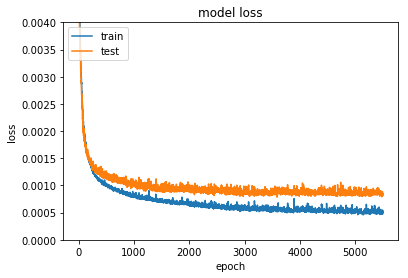

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0,0.004)
plt.show()

In [19]:
os.chdir('D:/data')
model_json = model.to_json()
model.save_weights('own_predict_weights.h5')

with open('own_predict_model.json', 'w') as outfile:
    outfile.write(model_json)

In [97]:
sum(history.history['val_loss'][-20:]) / 20

0.0011588151667850546

In [111]:
history = []